Written by AI22BTECH11023

In [28]:
# All imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from robustbench.model_zoo.cifar10 import linf as cifar10_linf_models
from robustbench.utils import load_model
from robustbench.data import load_cifar10
from torch.utils.data import TensorDataset, DataLoader
from torchattacks import PGD
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from captum.attr import Saliency
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading the CIFAR-10 dataset
# CIFAR-10 normalization statistics
mean_list = [0.4914, 0.4822, 0.4465]
std_list  = [0.2470, 0.2435, 0.2616]
mean = torch.tensor(mean_list, device=device).view(1,3,1,1)
std  = torch.tensor(std_list, device=device).view(1,3,1,1)
# Test data loader
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list)
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a high-accuracy pretrained ResNet-56 on CIFAR-10
model = torch.hub.load(
    'chenyaofo/pytorch-cifar-models',
    'cifar10_resnet56',
    pretrained=True
).to(device)
model.eval()

criterion = nn.CrossEntropyLoss()

Using cache found in C:\Users\saket/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [5]:
# Evaluate natural accuracy
correct = total = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        preds = model(images).argmax(dim=1)
    correct += (preds == labels).sum().item()

    total += labels.size(0)

print(f"Clean accuracy: {100 * correct/total:.2f}%")

Clean accuracy: 94.25%


In [ ]:
def check_pgd_attack(model, testloader, epsilon=0.031, alpha=0.007, num_iter=10):
    # Initialize the PGD attack
    pgd = PGD(model, eps=epsilon, alpha=alpha, steps=num_iter)

    # Evaluate the model under PGD attack
    correct = total = 0
    i = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd(images, labels)

        with torch.no_grad():
            preds = model(adv_images).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        i += 1
    print(f"PGD attack accuracy: {100 * correct/total:.2f}%")
    
check_pgd_attack(model, testloader, epsilon=0.031, alpha=0.007, num_iter=10)

PGD attack accuracy: 8.30%


Using Grad-CAM on layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


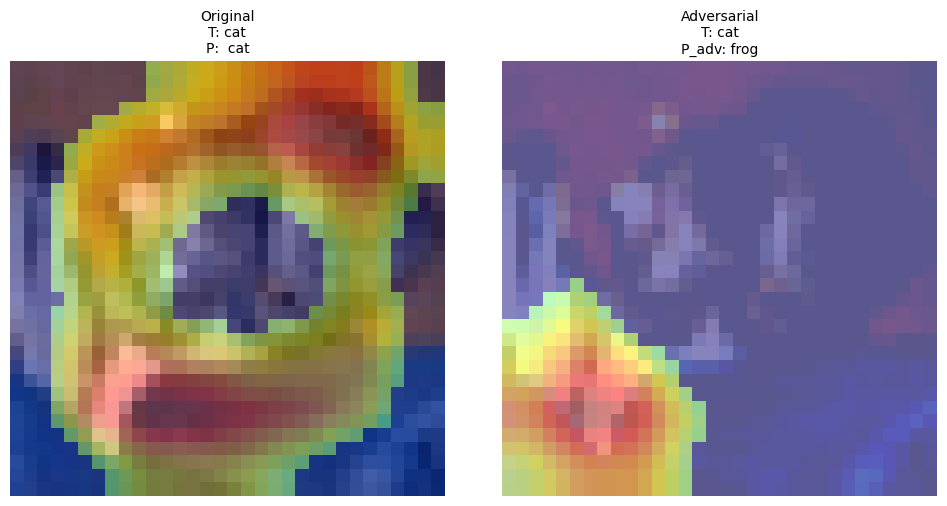

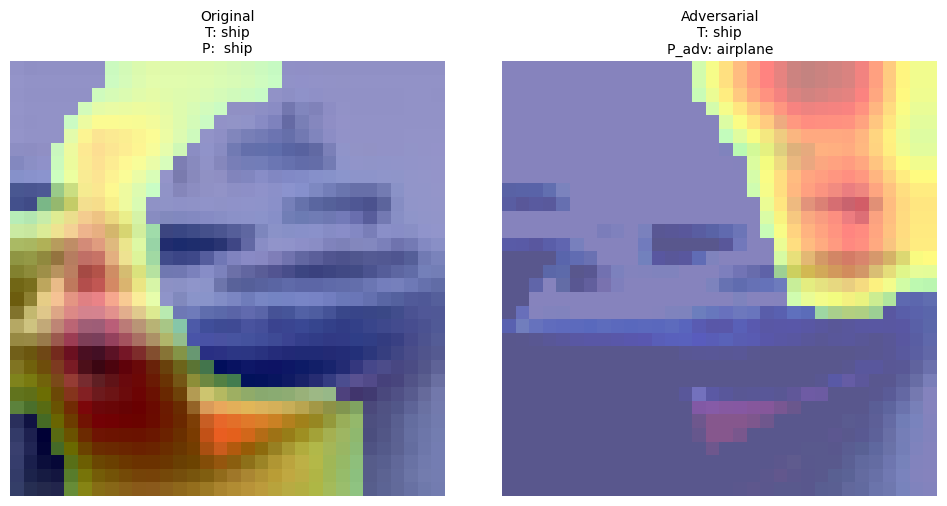

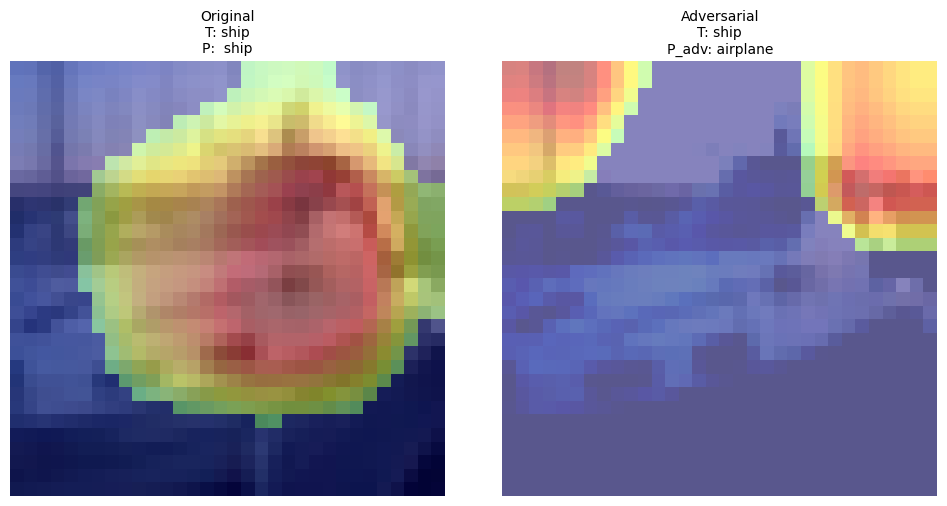

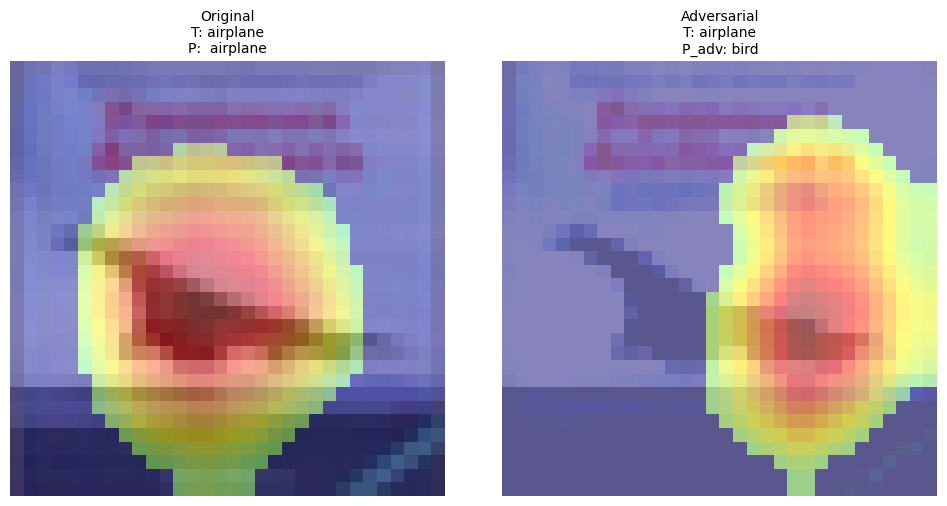

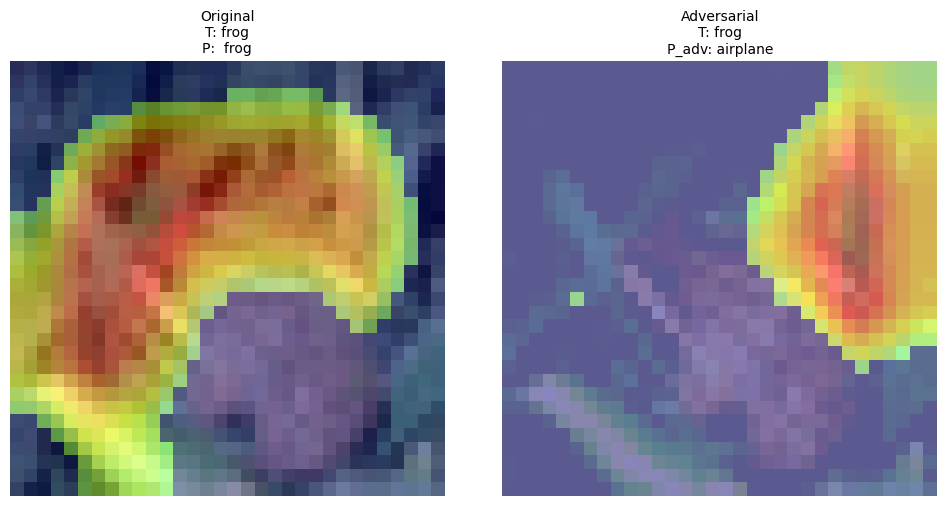

In [21]:
def grad_cam(model, attack, n_images=5):
# 1) Pick the correct target layer for CifarResNet
# target_layer = model.layer3[-1].conv2  # last conv in layer3 :contentReference[oaicite:0]{index=0}
    try:
        target_layer = model.layer3[-1].conv2
    except:
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                target_layer = module
        # sanity check
    print("Using Grad-CAM on layer:", target_layer)

    # 2) Instantiate GradCAM
    cam = GradCAM(
        model=model,
        target_layers=[target_layer]
    )

    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)
    imgs5, labs5 = images[:n_images], labels[:n_images]

    # 4) Generate saliency-guided adversarials (or vanilla ones)
    adv5 = attack(imgs5, labs5)  

    # 5) Build targets for each sample
    targets = [ClassifierOutputTarget(int(l.cpu())) for l in labs5]

    # 6) Compute Grad-CAM heatmaps
    heatmaps_orig = cam(input_tensor=imgs5,  targets=targets)  # shape (5, H, W)
    heatmaps_adv  = cam(input_tensor=adv5,    targets=targets)

    # 7) Denormalize to [0,1] for plotting
    orig_disp = (imgs5 * std + mean).cpu().permute(0,2,3,1).numpy()
    adv_disp  = (adv5  * std + mean).cpu().permute(0,2,3,1).numpy()

    # 8) Plot each image in its own figure
    class_names = CIFAR10(root='./data', train=False, download=True).classes

    for i in range(n_images):
        # 1) Threshold heatmaps to keep only strong activations
        hm_o = heatmaps_orig[i].copy()
        hm_a = heatmaps_adv[i].copy()
        hm_o[hm_o < 0.5] = 0
        hm_a[hm_a < 0.5] = 0

        # 2) Overlay with higher image weight and 'jet' colormap
        overlay_orig = show_cam_on_image(
            orig_disp[i],
            hm_o,
            use_rgb=True,
            image_weight=0.6,
        )
        overlay_adv = show_cam_on_image(
            adv_disp[i],
            hm_a,
            use_rgb=True,
            image_weight=0.6,
        )

        # 3) Recompute predictions
        p_o = model(imgs5[i:i+1]).argmax(1).item()
        p_a = model(adv5[i:i+1]).argmax(1).item()

        # 4) Plot focused overlays
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(overlay_orig)
        ax1.axis('off')
        ax1.set_title(
            f"Original\nT: {class_names[labs5[i]]}\nP:  {class_names[p_o]}",
            fontsize=10
        )
        ax2.imshow(overlay_adv)
        ax2.axis('off')
        ax2.set_title(
            f"Adversarial\nT: {class_names[labs5[i]]}\nP_adv: {class_names[p_a]}",
            fontsize=10
        )
        plt.tight_layout()
        plt.show()
attack = PGD(model, eps=0.031, alpha=0.007, steps=10)
grad_cam(model, attack)

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


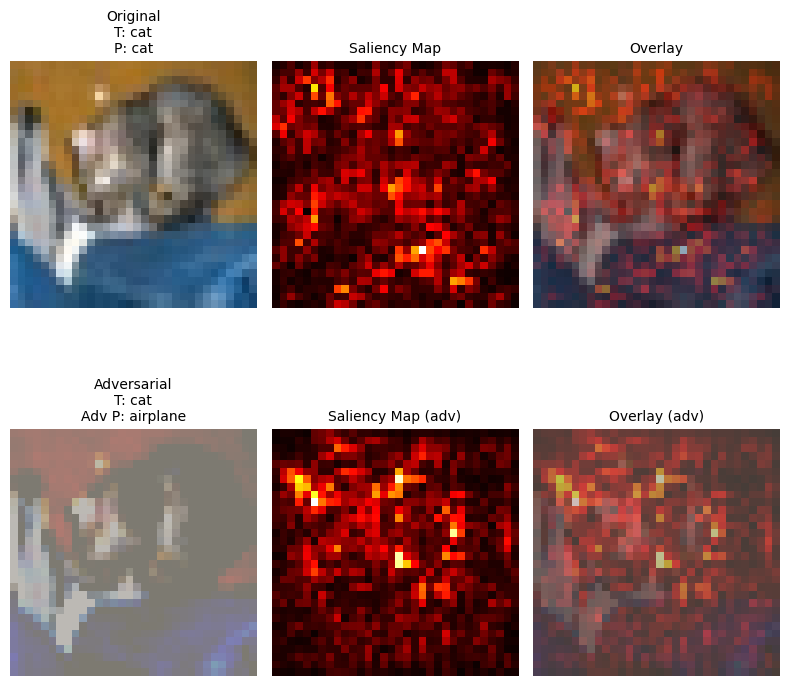

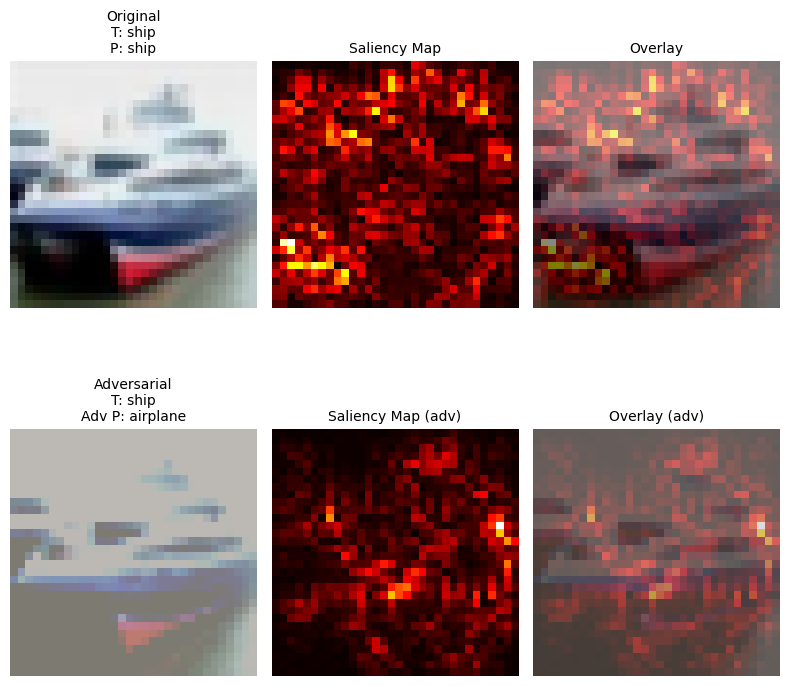

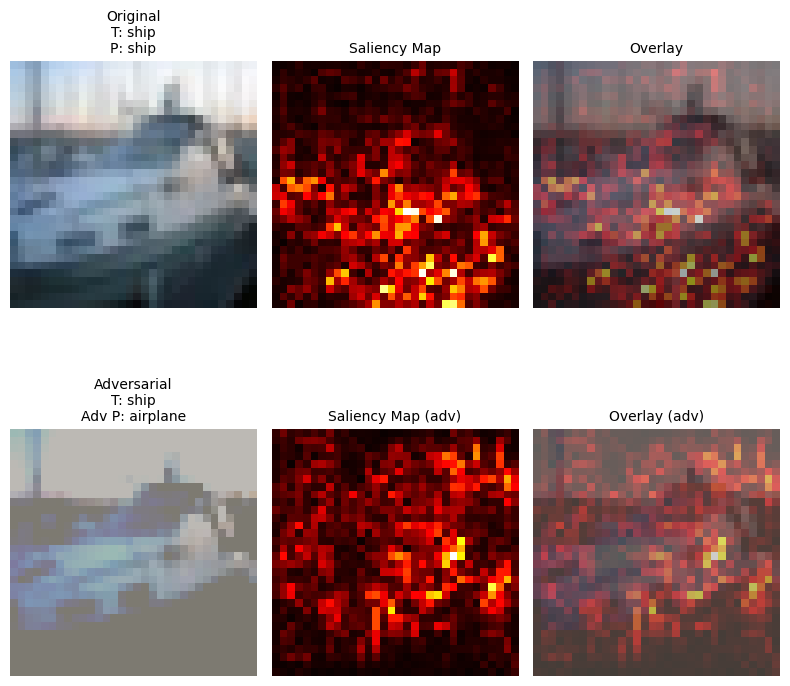

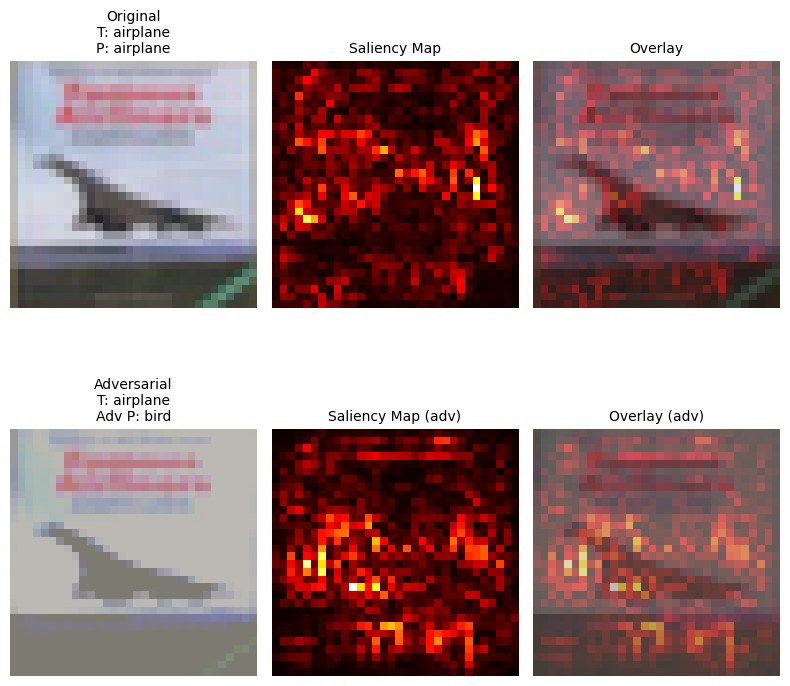

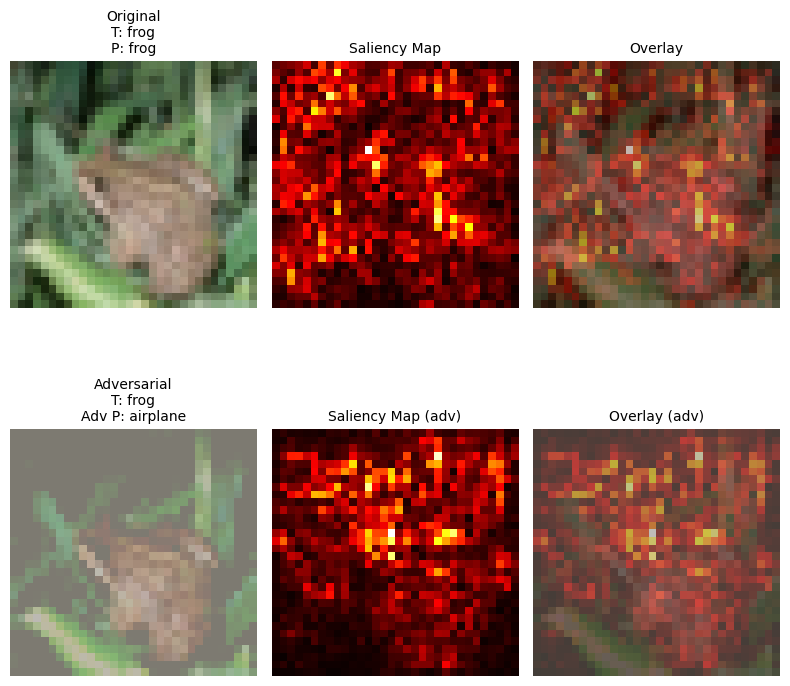

In [20]:
def saliency_maps(model, attack, n_images=5):
# Assumes model, testloader, device, sg_pgd, mean_list, and std_list are already defined

# 1) Setup saliency explainer and normalization tensors
    saliency = Saliency(model)
    mean_tensor = torch.tensor(mean_list, device=device).view(1,3,1,1)
    std_tensor  = torch.tensor(std_list,  device=device).view(1,3,1,1)
    criterion = torch.nn.CrossEntropyLoss()

    # 2) Fetch a batch and select first 5 images
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)
    images5, labels5 = images[:n_images], labels[:n_images]

    # 3) Generate saliency-guided adversarial examples
    adv_images5 = attack(images5, labels5)

    # 4) Compute saliency maps for originals and adversarials
    orig_sal = saliency.attribute(images5, target=labels5).abs().sum(dim=1, keepdim=True)
    adv_sal  = saliency.attribute(adv_images5, target=labels5).abs().sum(dim=1, keepdim=True)

    # 5) Denormalize for display
    orig_disp = (images5 * std_tensor + mean_tensor).cpu()
    adv_disp  = (adv_images5 * std_tensor + mean_tensor).cpu()
    orig_sal_np = orig_sal.cpu().numpy()  # shape (5,1,H,W)
    adv_sal_np  = adv_sal.cpu().numpy()

    # 6) Predictions
    with torch.no_grad():
        preds_orig = model(images5).argmax(dim=1).cpu()
        preds_adv  = model(adv_images5).argmax(dim=1).cpu()
    labels5_cpu = labels5.cpu()
    class_names = testloader.dataset.classes

    # 7) Plot per-image figures with overlay
    for i in range(n_images):
        fig, axes = plt.subplots(2, 3, figsize=(8, 8))
        
        # Original image
        axes[0,0].imshow(orig_disp[i].permute(1,2,0).clamp(0,1))
        axes[0,0].axis('off')
        axes[0,0].set_title(
            f"Original\nT: {class_names[labels5_cpu[i]]}\nP: {class_names[preds_orig[i]]}",
            fontsize=10
        )
        # Original saliency map
        axes[0,1].imshow(orig_sal_np[i,0], cmap='hot')
        axes[0,1].axis('off')
        axes[0,1].set_title("Saliency Map", fontsize=10)
        # Original overlay
        axes[0,2].imshow(orig_disp[i].permute(1,2,0).clamp(0,1))
        axes[0,2].imshow(orig_sal_np[i,0], cmap='hot', alpha=0.5)
        axes[0,2].axis('off')
        axes[0,2].set_title("Overlay", fontsize=10)
        
        # Adversarial image
        axes[1,0].imshow(adv_disp[i].permute(1,2,0).clamp(0,1))
        axes[1,0].axis('off')
        axes[1,0].set_title(
            f"Adversarial\nT: {class_names[labels5_cpu[i]]}\nAdv P: {class_names[preds_adv[i]]}",
            fontsize=10
        )
        # Adversarial saliency map
        axes[1,1].imshow(adv_sal_np[i,0], cmap='hot')
        axes[1,1].axis('off')
        axes[1,1].set_title("Saliency Map (adv)", fontsize=10)
        # Adversarial overlay
        axes[1,2].imshow(adv_disp[i].permute(1,2,0).clamp(0,1))
        axes[1,2].imshow(adv_sal_np[i,0], cmap='hot', alpha=0.5)
        axes[1,2].axis('off')
        axes[1,2].set_title("Overlay (adv)", fontsize=10)
        
        plt.tight_layout()
        plt.show()
saliency_maps(model, attack)

In [9]:
# 3) Pick one that exists—e.g. 'Carmon2019Unlabeled'
print("Available CIFAR-10 L∞ models:")
for name in cifar10_linf_models.keys():
    print("  ", name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_robust = load_model(
    model_name='Carmon2019Unlabeled',
    dataset='cifar10',
    threat_model='Linf'
).to(device).eval()
# :contentReference[oaicite:1]{index=1}

Available CIFAR-10 L∞ models:
   Andriushchenko2020Understanding
   Carmon2019Unlabeled
   Sehwag2020Hydra
   Wang2020Improving
   Hendrycks2019Using
   Rice2020Overfitting
   Zhang2019Theoretically
   Engstrom2019Robustness
   Chen2020Adversarial
   Huang2020Self
   Pang2020Boosting
   Wong2020Fast
   Ding2020MMA
   Zhang2019You
   Zhang2020Attacks
   Wu2020Adversarial_extra
   Wu2020Adversarial
   Gowal2020Uncovering_70_16
   Gowal2020Uncovering_70_16_extra
   Gowal2020Uncovering_34_20
   Gowal2020Uncovering_28_10_extra
   Sehwag2021Proxy
   Sehwag2021Proxy_R18
   Sehwag2021Proxy_ResNest152
   Sitawarin2020Improving
   Chen2020Efficient
   Cui2020Learnable_34_20
   Cui2020Learnable_34_10
   Zhang2020Geometry
   Rebuffi2021Fixing_28_10_cutmix_ddpm
   Rebuffi2021Fixing_106_16_cutmix_ddpm
   Rebuffi2021Fixing_70_16_cutmix_ddpm
   Rebuffi2021Fixing_70_16_cutmix_extra
   Sridhar2021Robust
   Sridhar2021Robust_34_15
   Rebuffi2021Fixing_R18_ddpm
   Rade2021Helper_R18_extra
   Rade2021Helpe

In [10]:
# Evaluate natural accuracy
correct = total = 0
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        preds = model_robust(images).argmax(dim=1)
    correct += (preds == labels).sum().item()

    total += labels.size(0)

print(f"Clean accuracy: {100 * correct/total:.2f}%")

Clean accuracy: 70.37%


In [33]:
check_pgd_attack(model_robust, testloader, epsilon=0.031, alpha=0.007, num_iter=10)

PGD attack accuracy: 62.47%


Using Grad-CAM on layer: Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


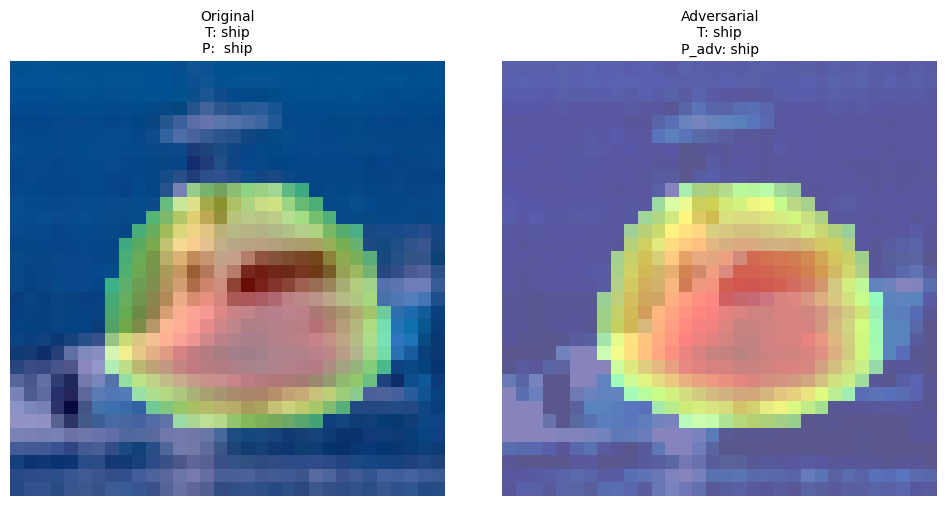

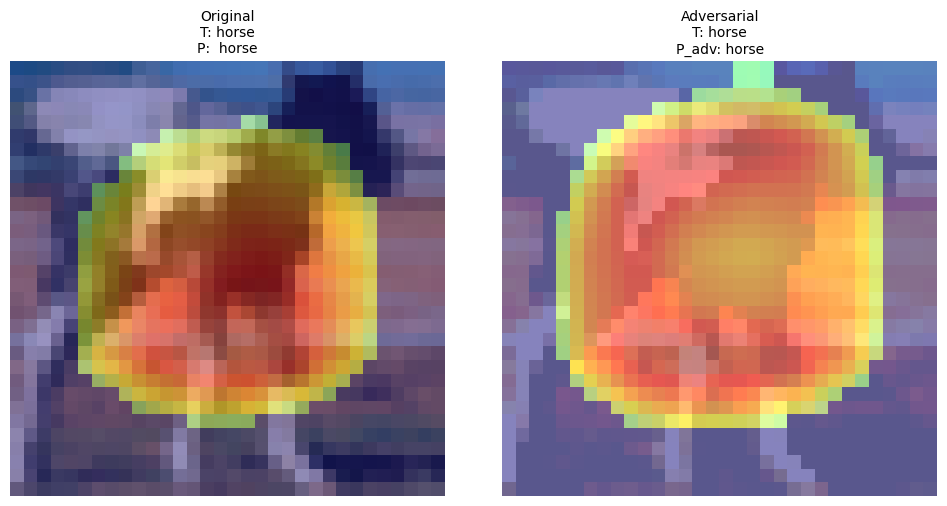

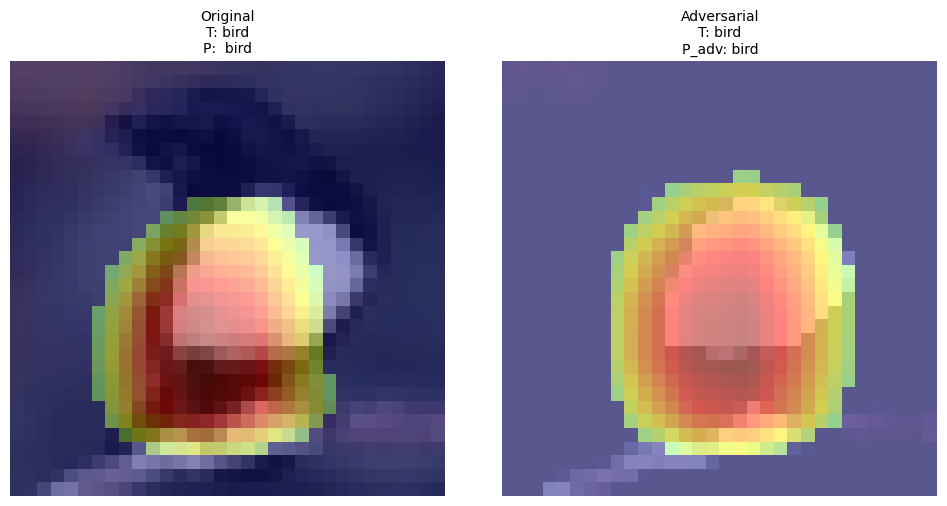

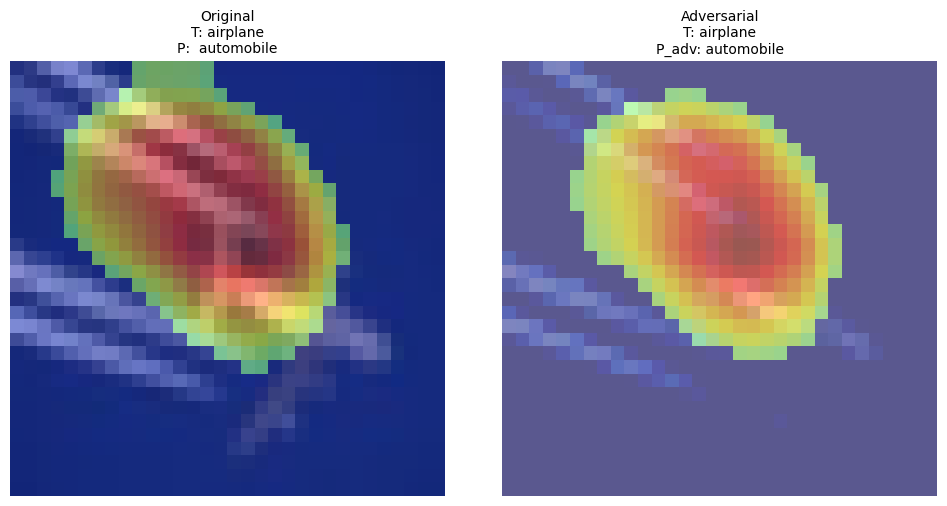

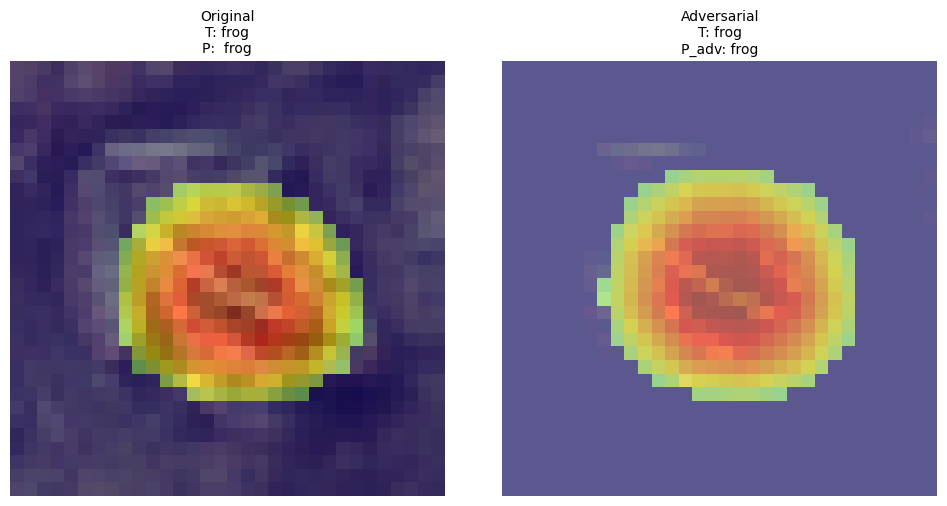

In [ ]:
grad_cam(model_robust, attack)

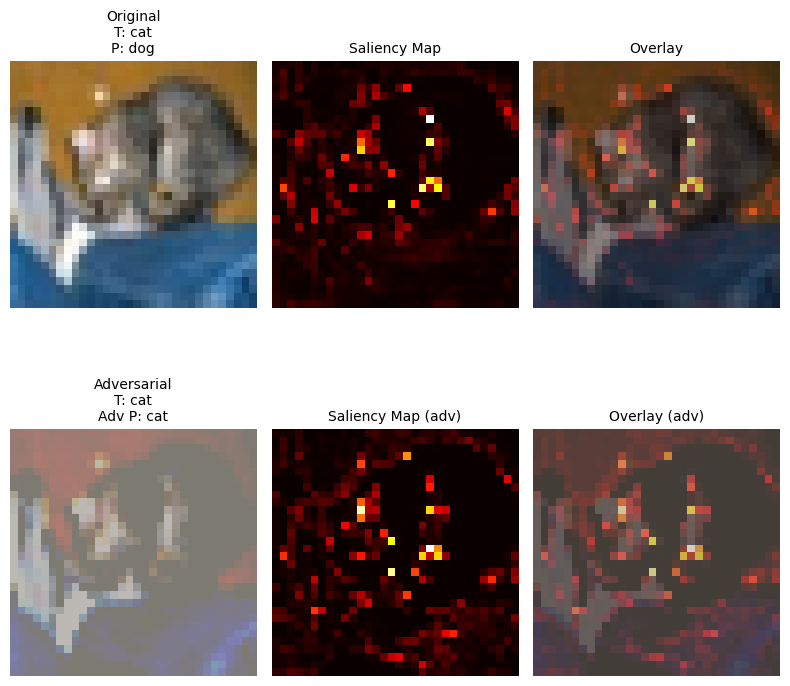

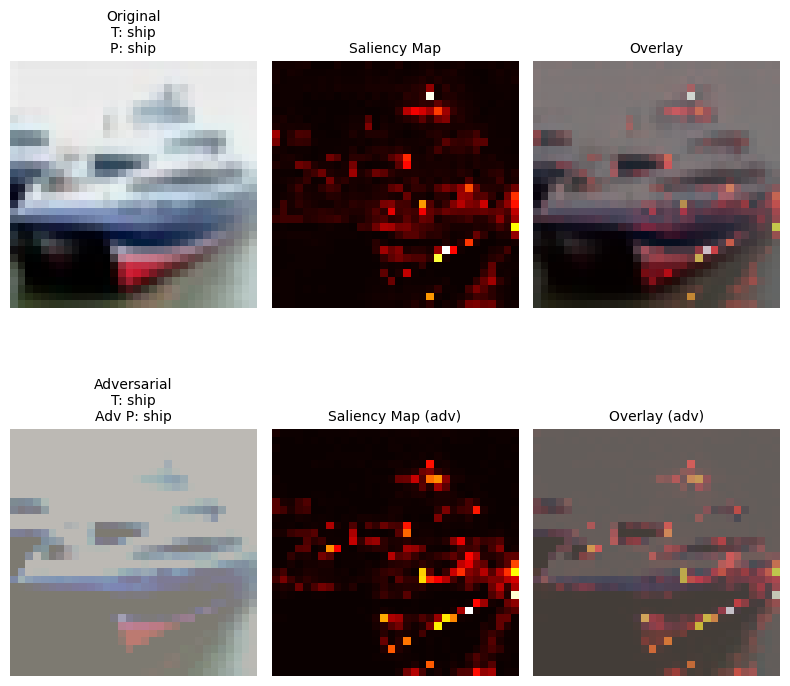

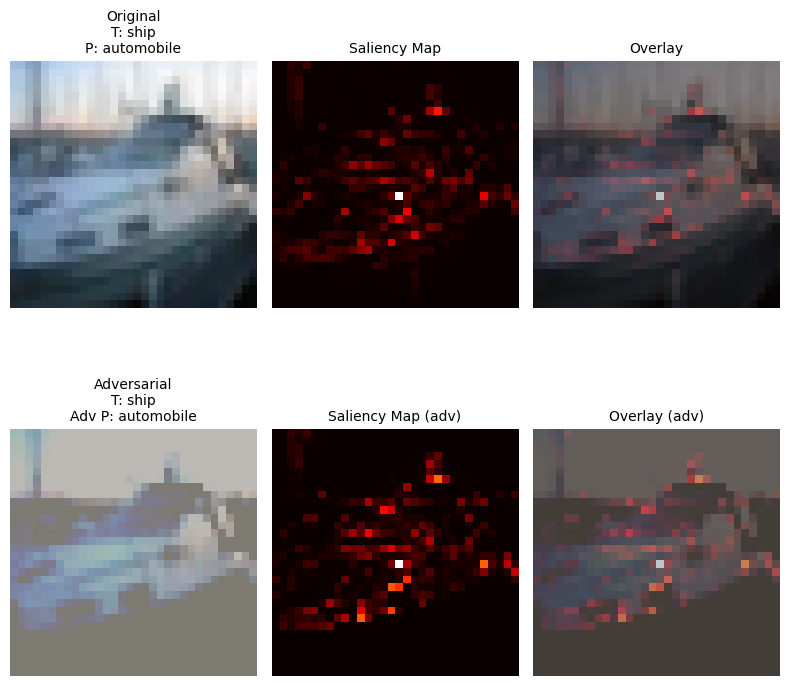

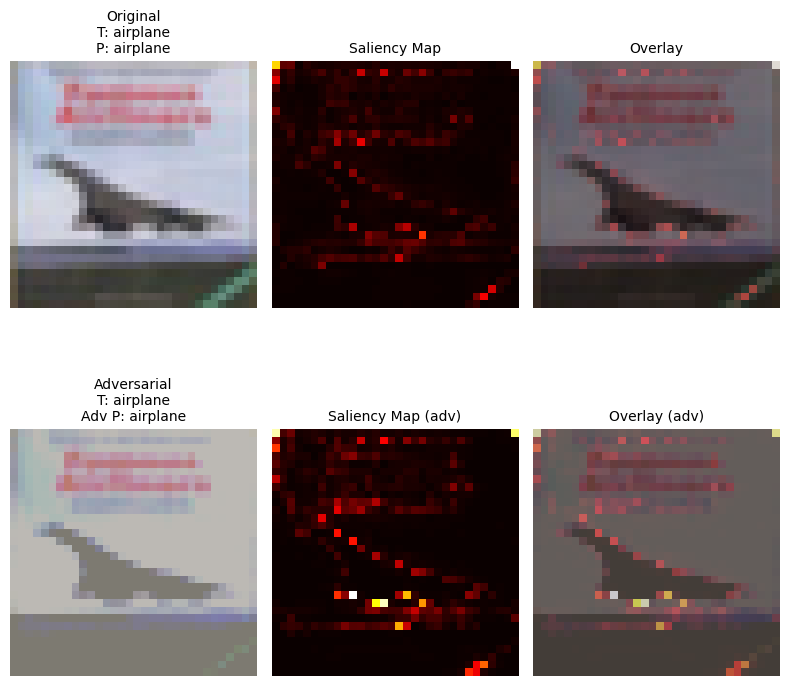

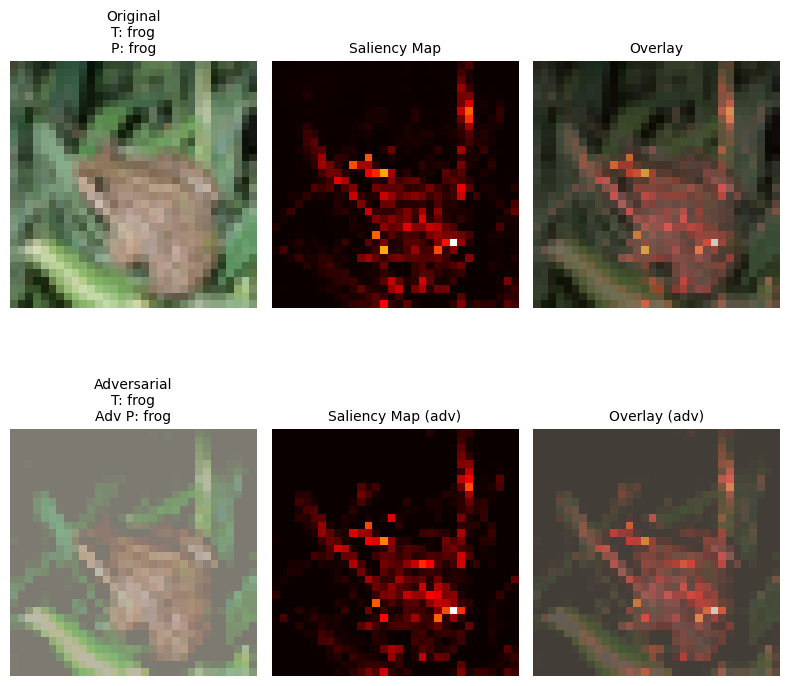

In [ ]:
saliency_maps(model_robust, attack)

In [14]:

saliency = Saliency(model_robust)

# only works with the robust model, to make it work with the normal model, you need to change model_robust to model
def sg_pgd(images, labels, eps=8/255, alpha=2/255, steps=10, lam=3.0):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    eps_norm   = eps / std
    alpha_norm = alpha / std
    ori = images.clone().detach()
    adv = images.clone().detach()
    # Compute saliency map on original images
    sal_map = saliency.attribute(ori, target=labels)
    sal_abs = sal_map.abs().sum(dim=1, keepdim=True)
    sal_norm = sal_abs / (sal_abs.view(sal_abs.size(0), -1).max(dim=1)[0]
                          .view(-1,1,1,1) + 1e-8)

    for _ in range(steps):
        adv.requires_grad_()
        outputs = model_robust(adv)
        loss = criterion(outputs, labels)
        model_robust.zero_grad()
        loss.backward()
        grad_sign = adv.grad.data.sign()

        # Saliency-weighted update + projection
        adv = adv + alpha_norm * grad_sign * (1 + lam * sal_norm)
        eta = torch.clamp(adv - ori, -eps_norm, eps_norm)
        adv = torch.clamp(ori + eta, (0-mean)/std, (1-mean)/std).detach()

    return adv

c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


SG-PGD attack accuracy: 24.81%


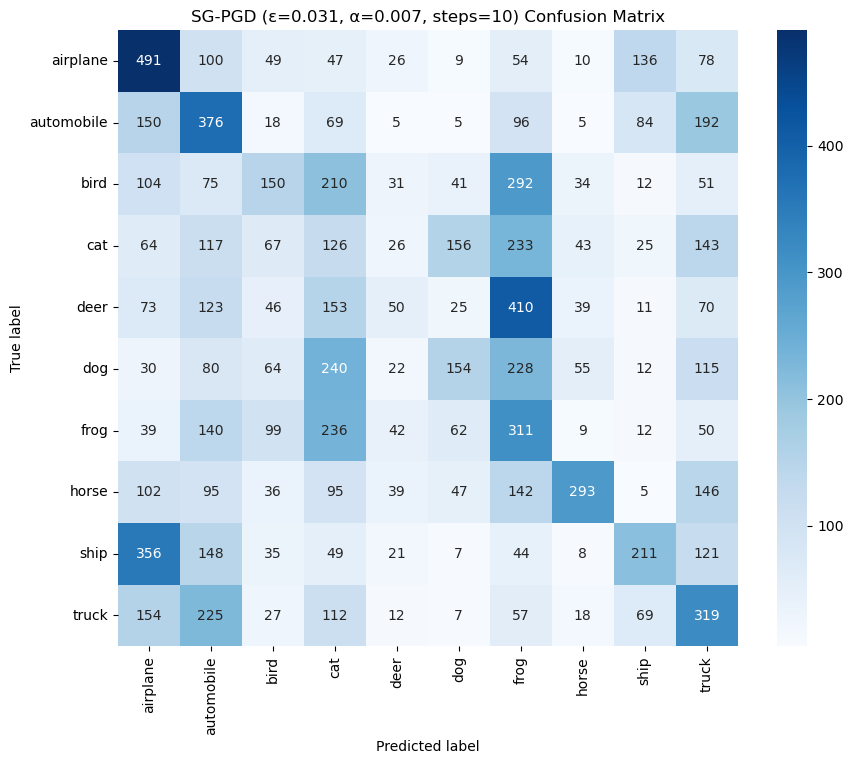

In [31]:
def check_spgd_attack(model, testloader, epsilon=0.031, alpha=0.007, num_iter=10):
    # Initialize the PGD attack
    # Evaluate the model under PGD attack
    true_labels = []
    pred_labels = []
    correct = total = 0
    i = 0
    class_names = testloader.dataset.classes
    for images, labels in testloader:
        # if(i == 20):
        #     break
        images, labels = images.to(device), labels.to(device)
        adv_images = sg_pgd(images, labels)
        
        with torch.no_grad():
            preds = model(adv_images).argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        i += 1
    print(f"SG-PGD attack accuracy: {100 * correct/total:.2f}%")
    cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))
    # Plotting
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'SG-PGD (ε={epsilon}, α={alpha}, steps={num_iter}) Confusion Matrix')
    plt.show()

check_spgd_attack(model_robust, testloader, epsilon=0.031, alpha=0.007, num_iter=10)

Using Grad-CAM on layer: Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


c:\Users\saket\anaconda3\anaconda\envs\gpu_env\Lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


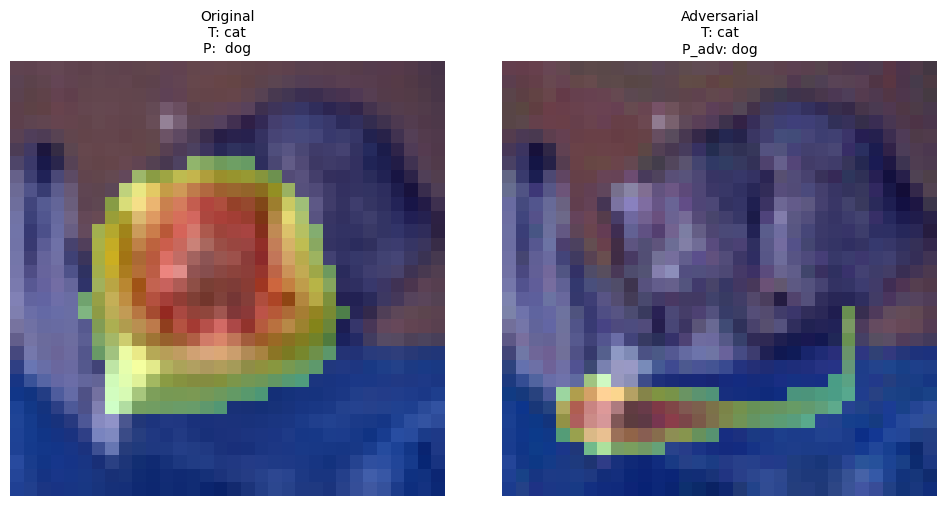

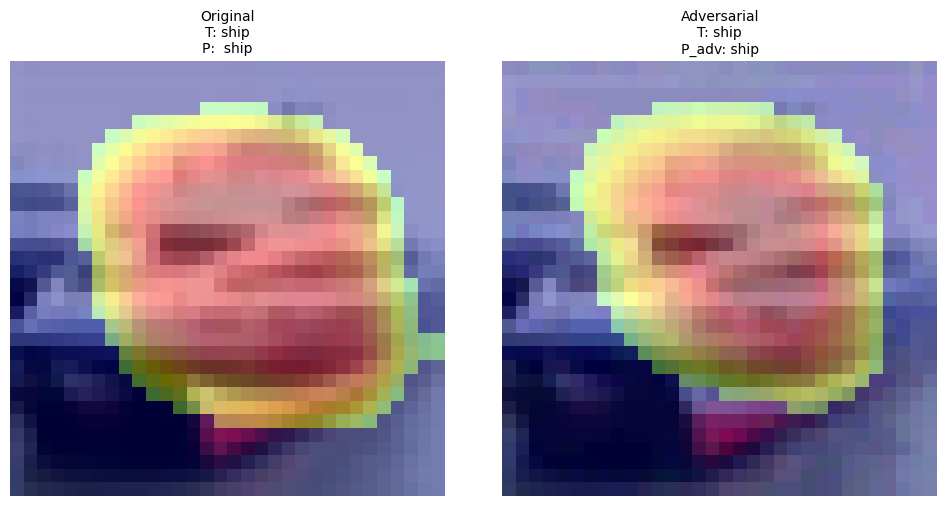

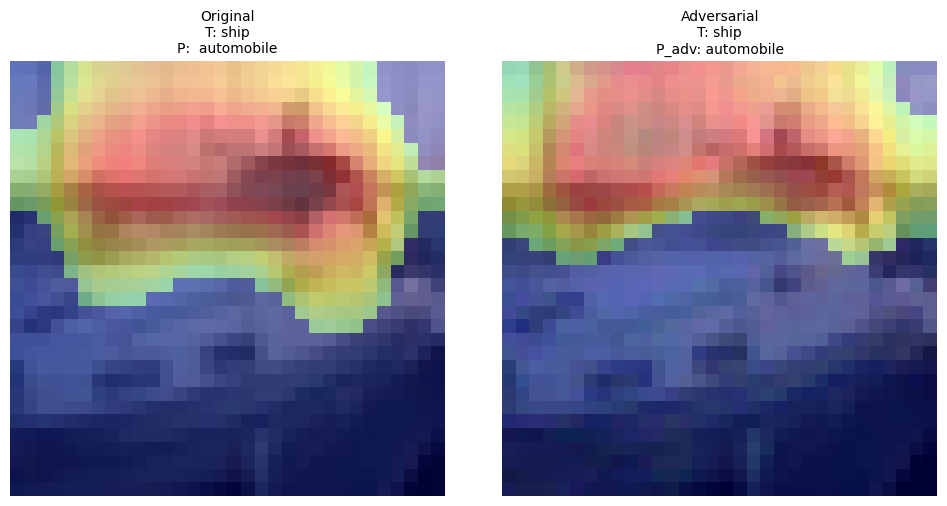

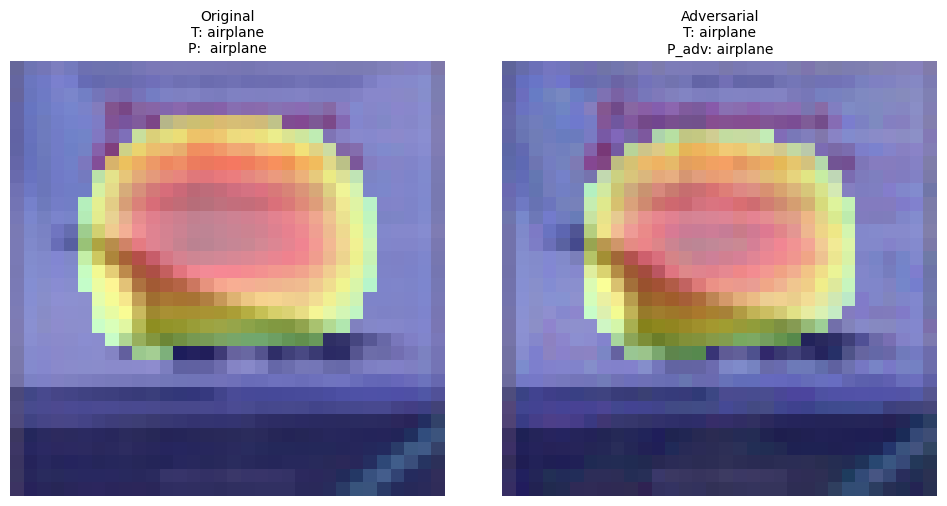

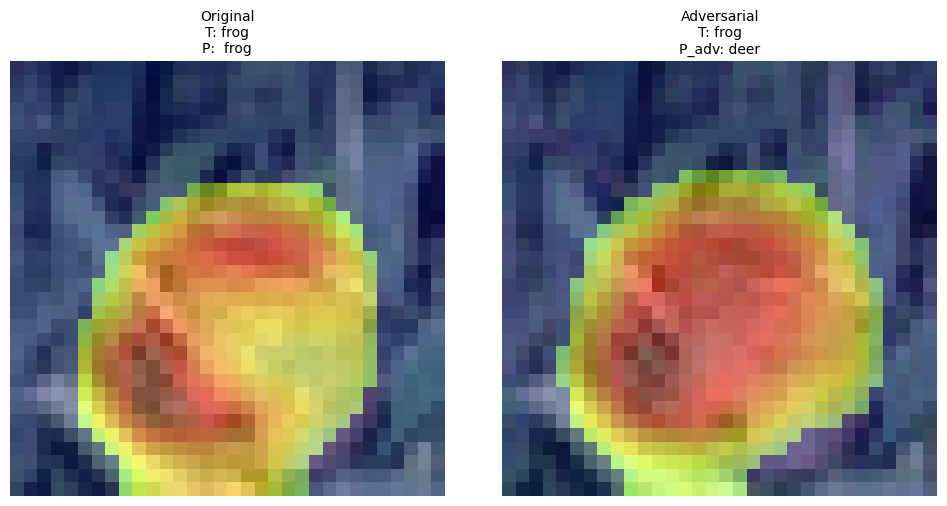

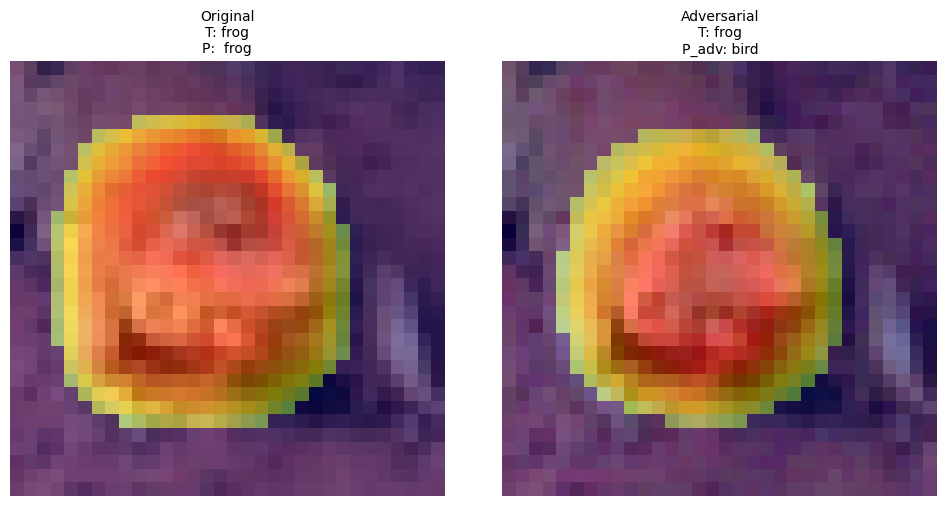

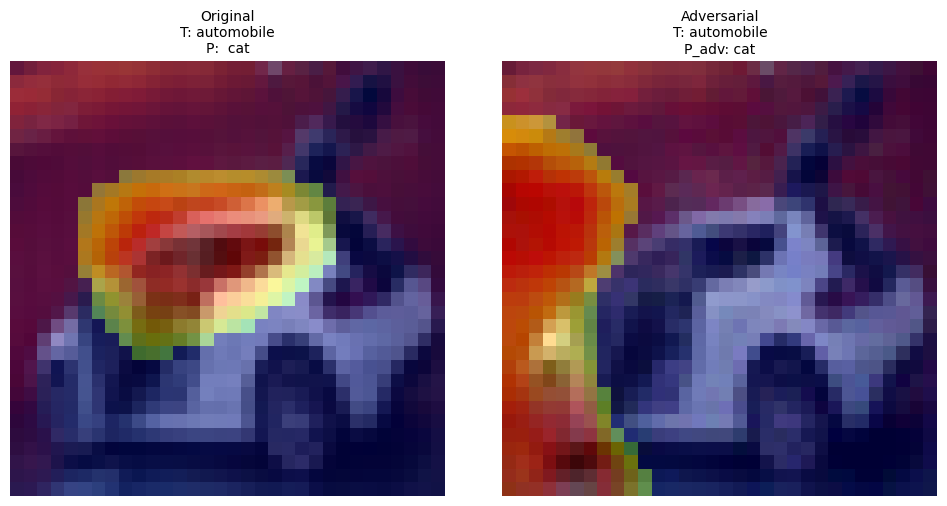

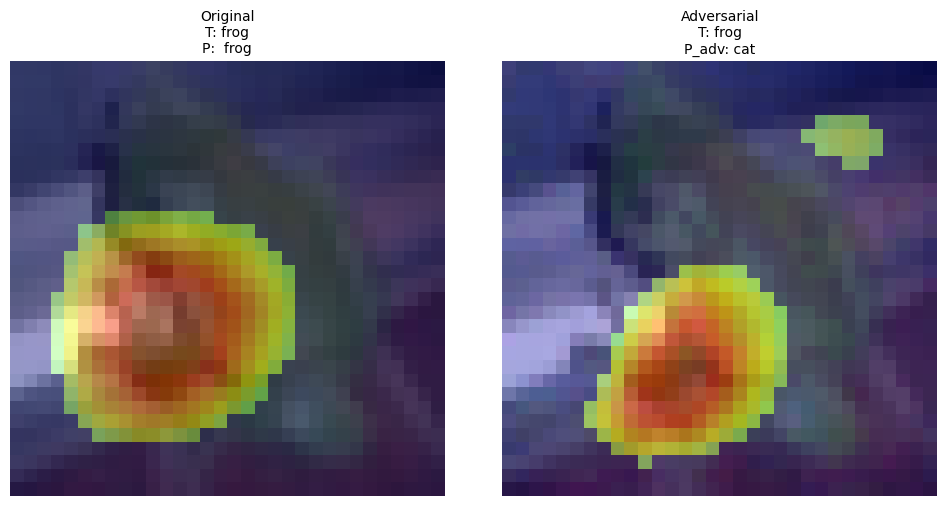

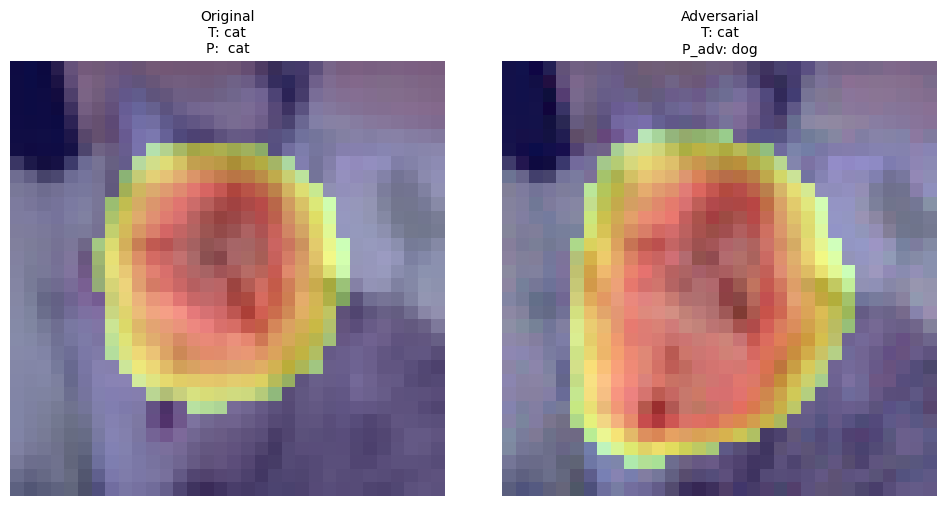

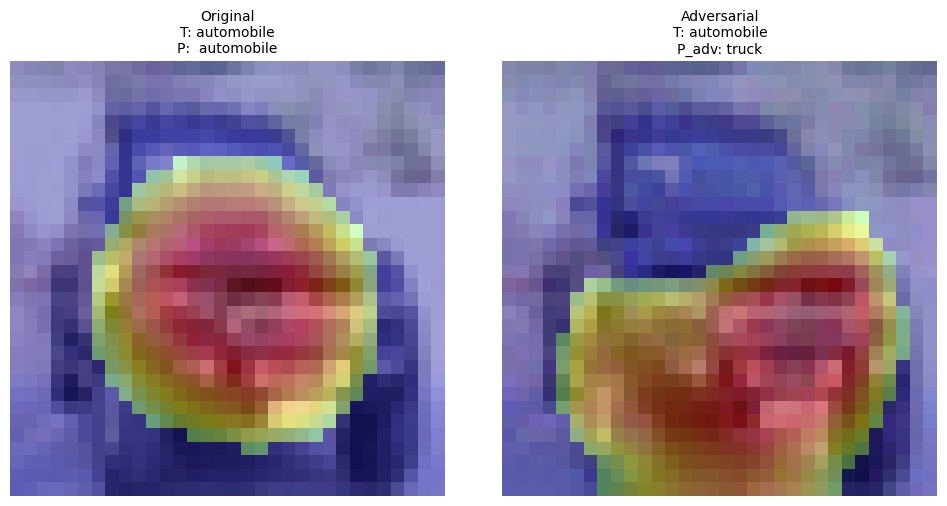

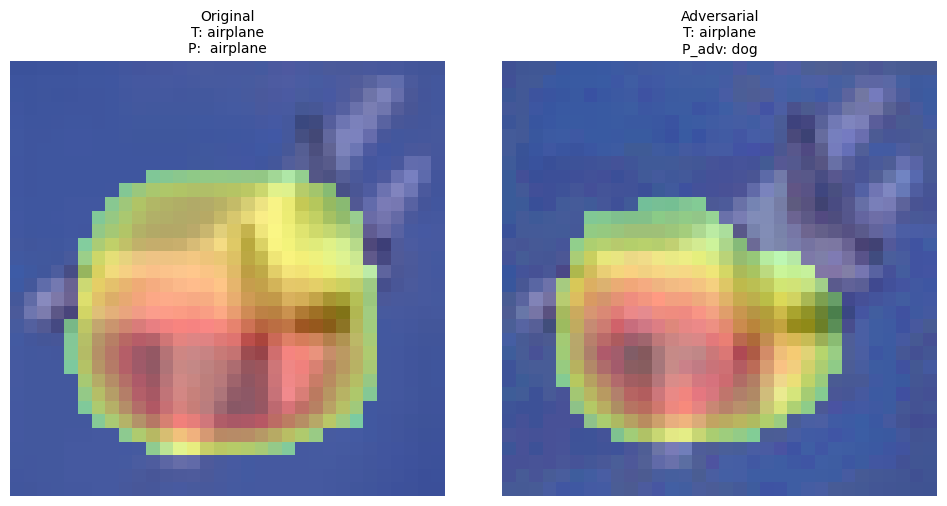

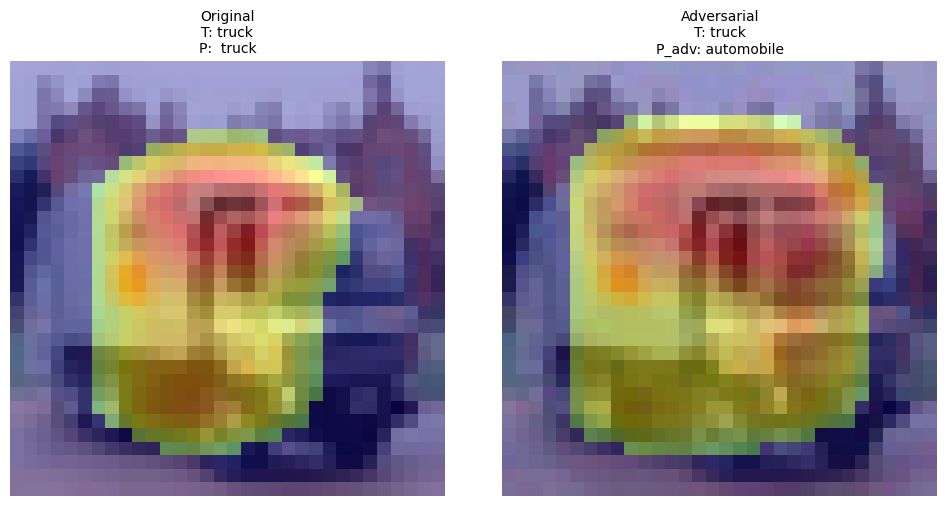

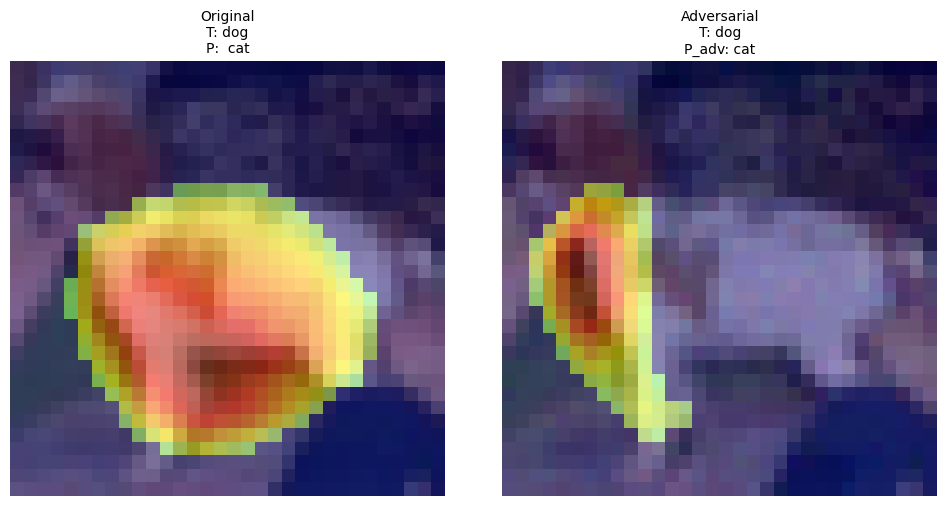

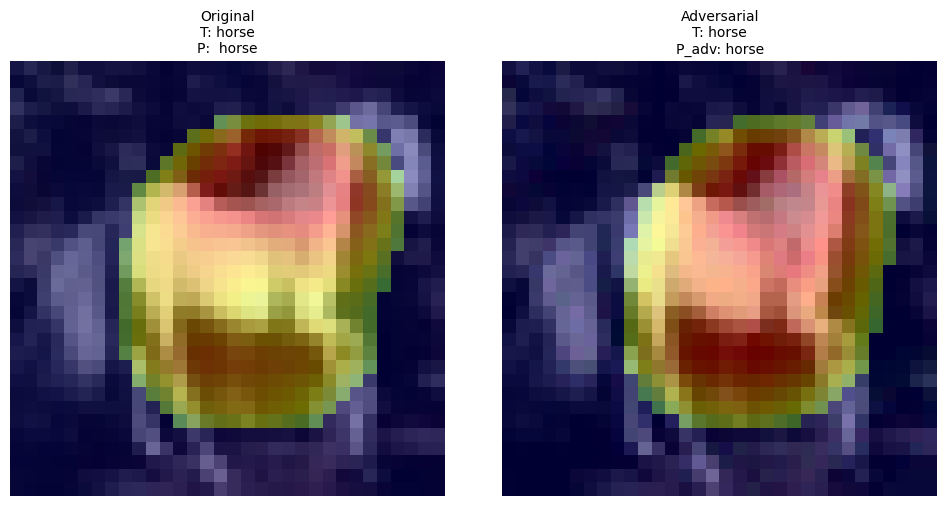

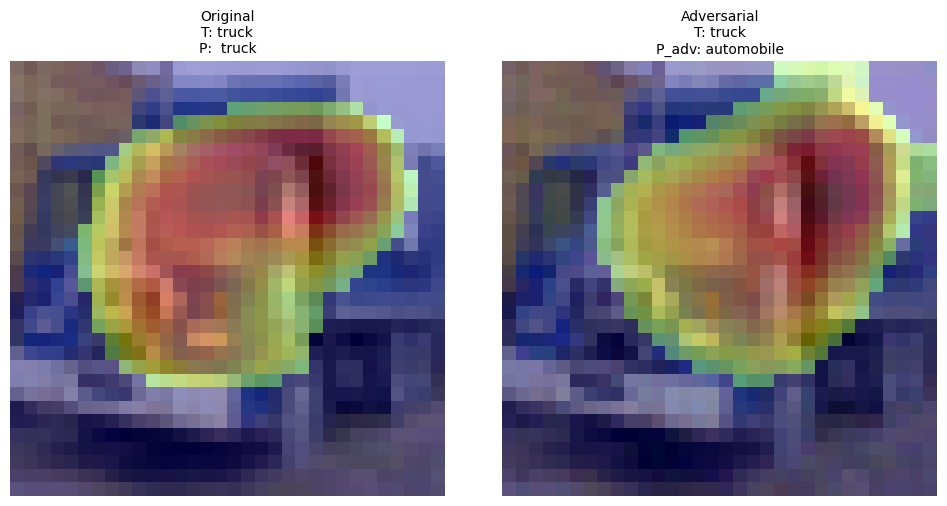

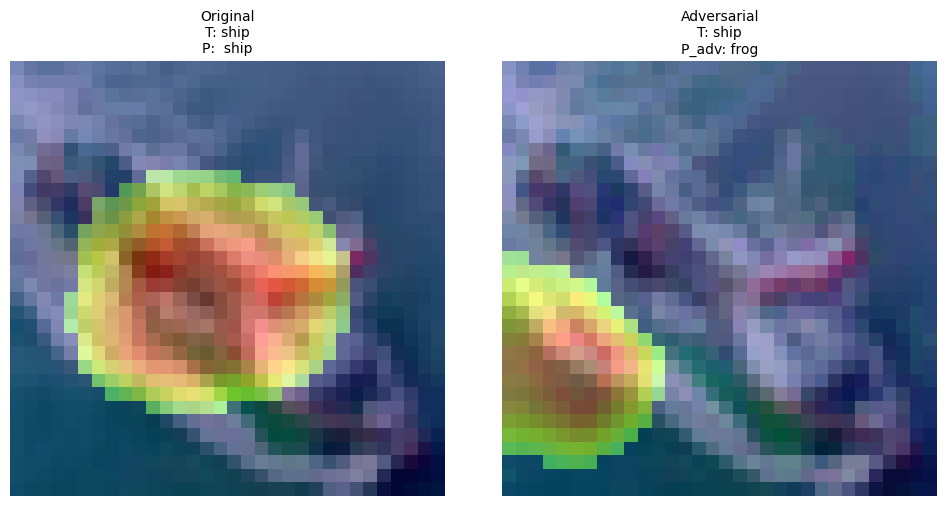

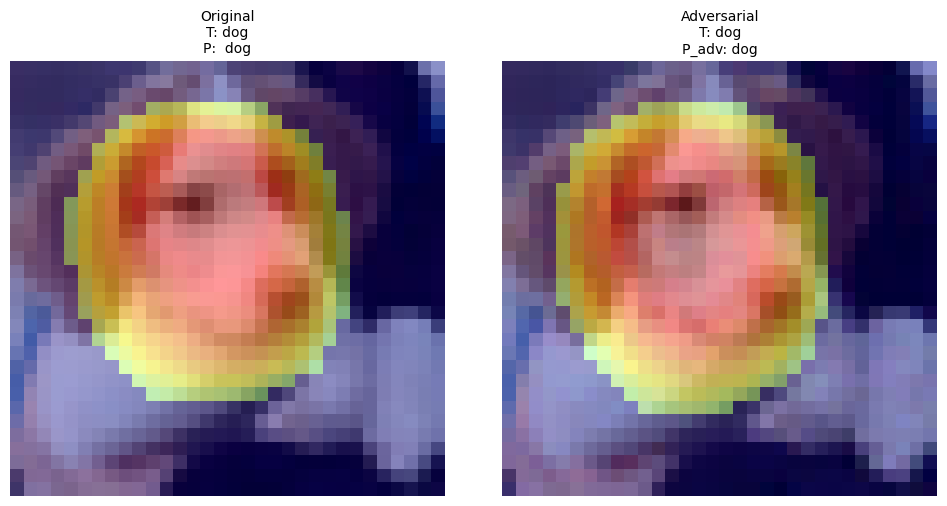

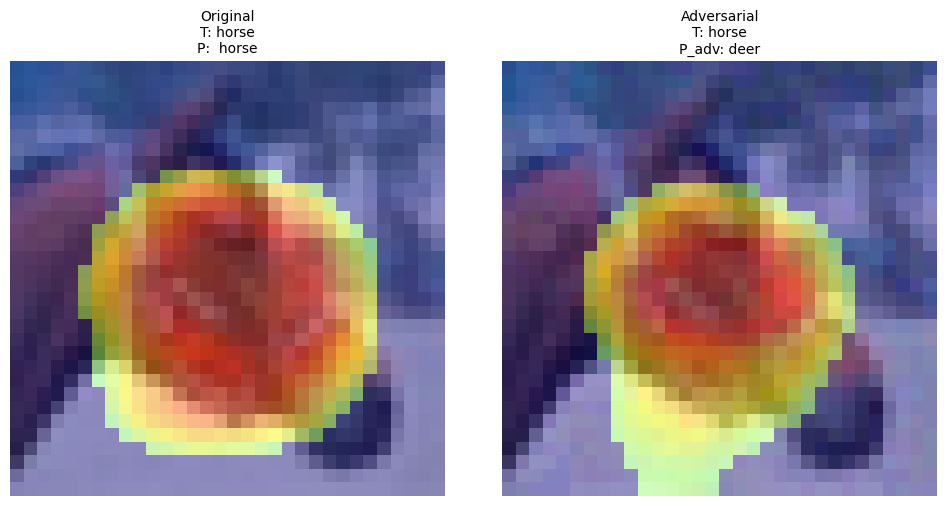

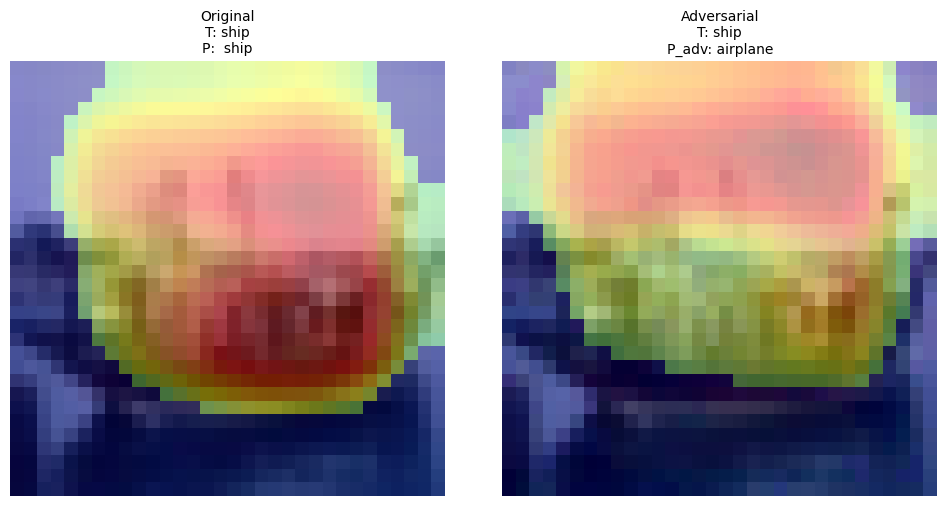

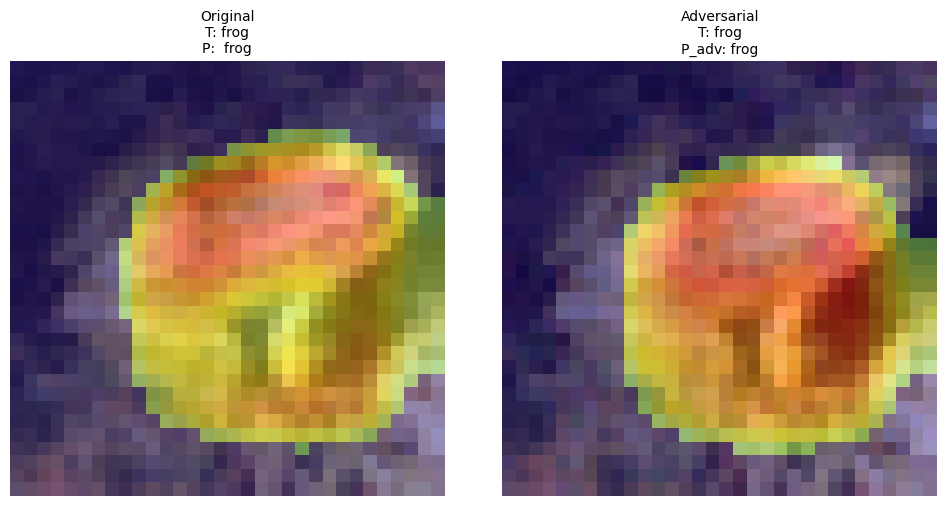

In [24]:
grad_cam(model_robust, sg_pgd, n_images=20) 
# PS : sg_pgd will only work with robust, not original, unless you change the saliency function to use the original model.

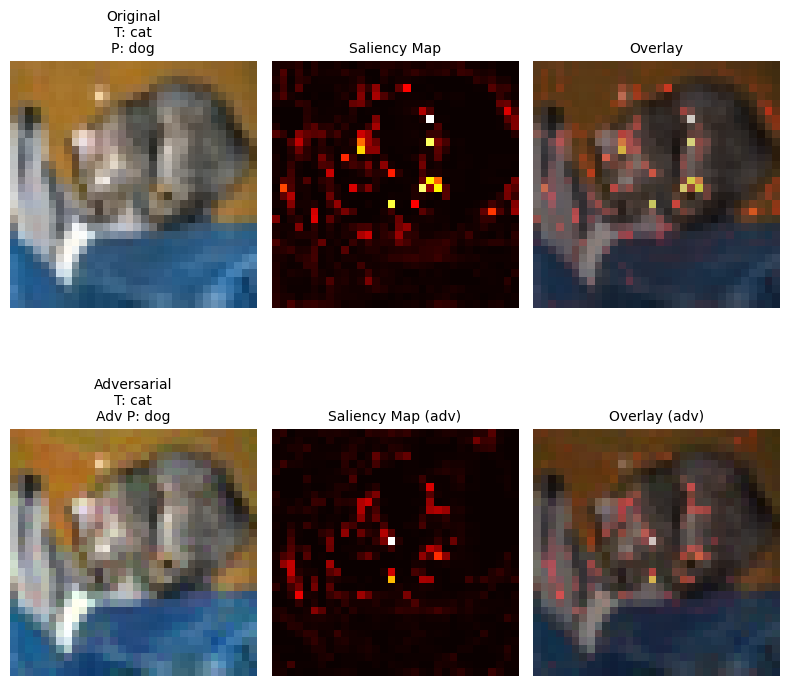

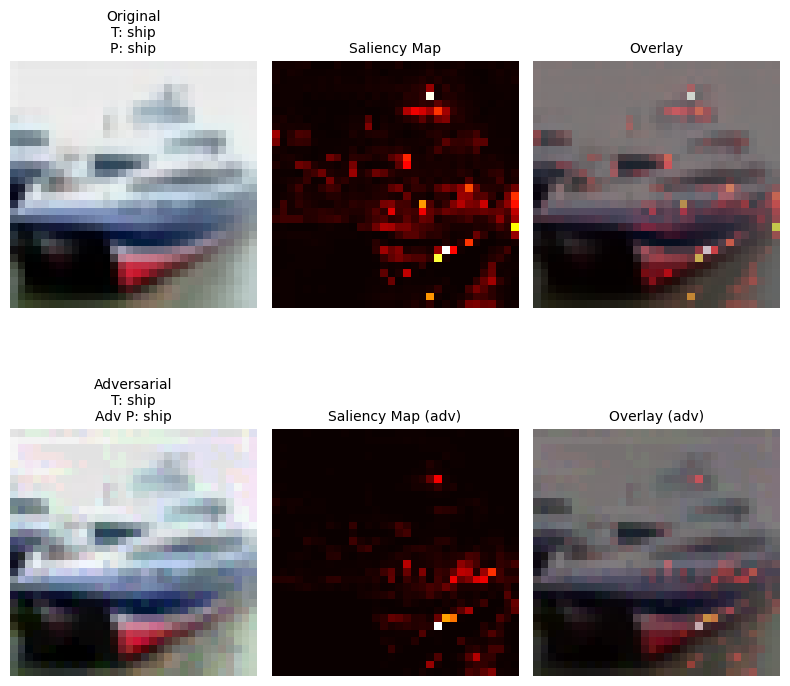

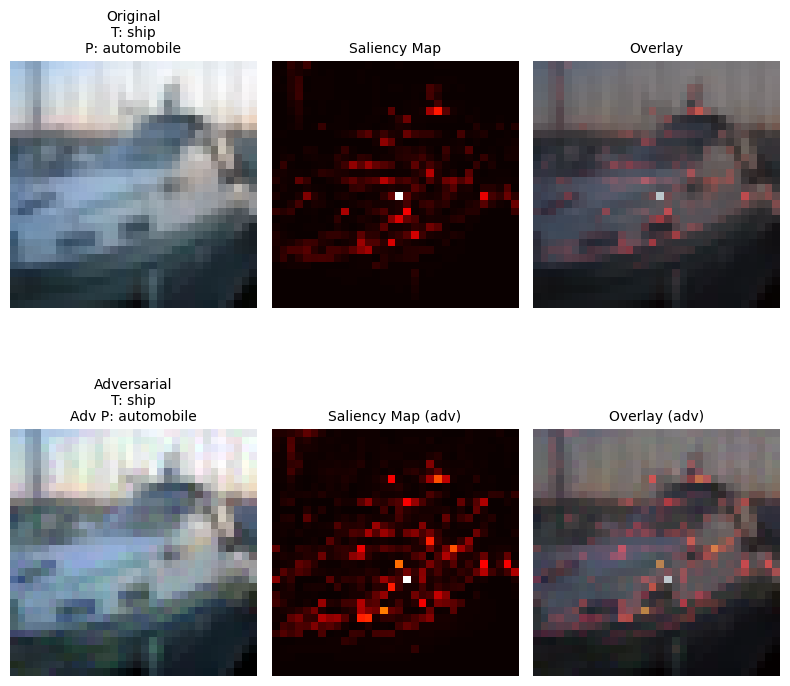

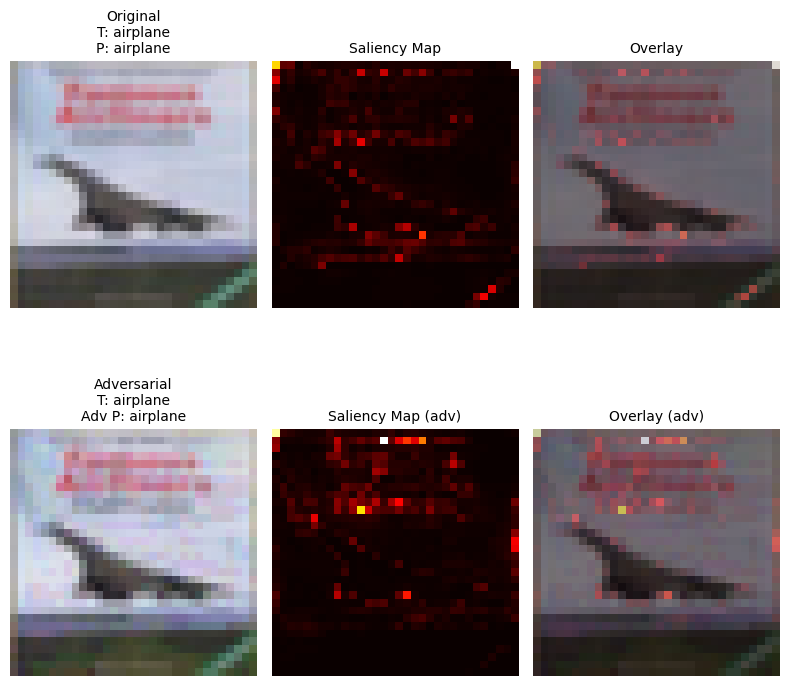

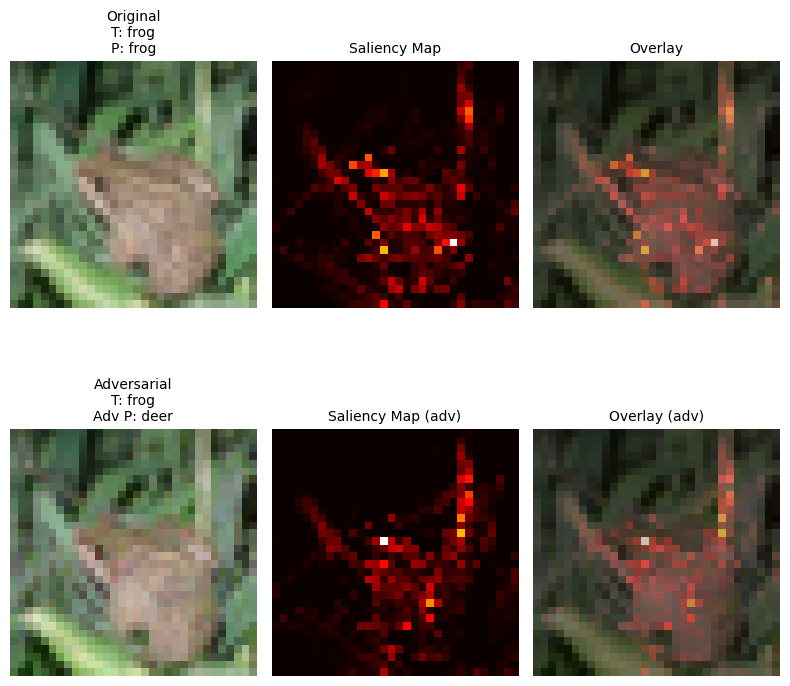

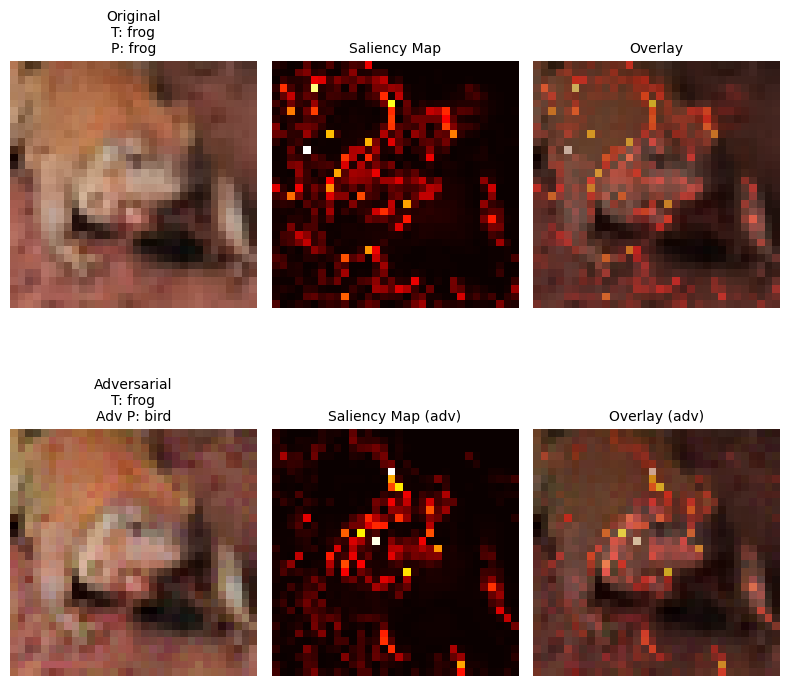

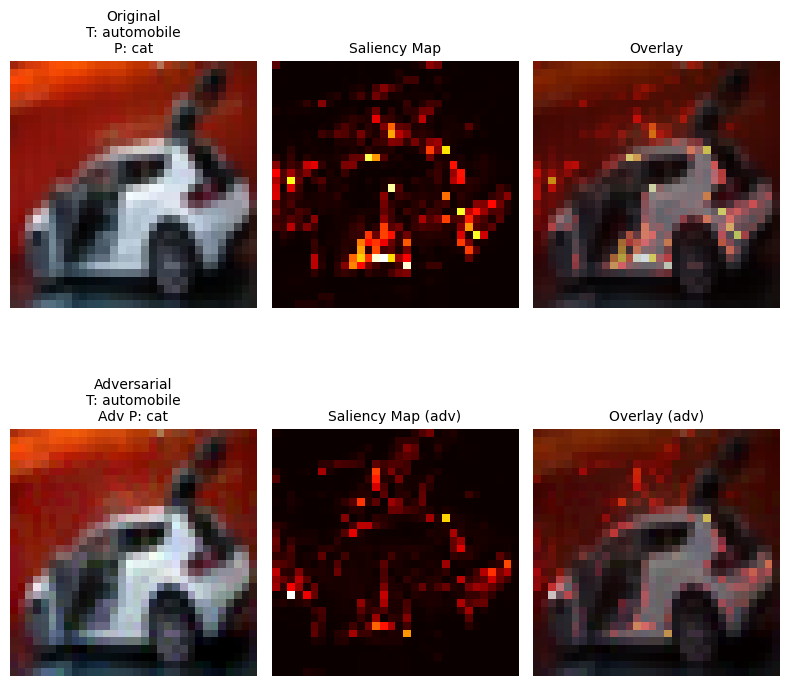

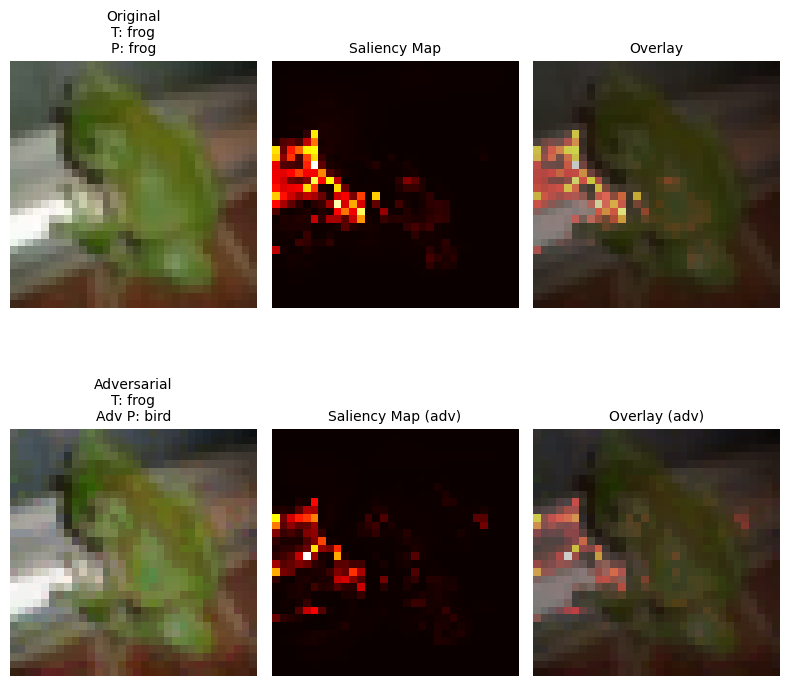

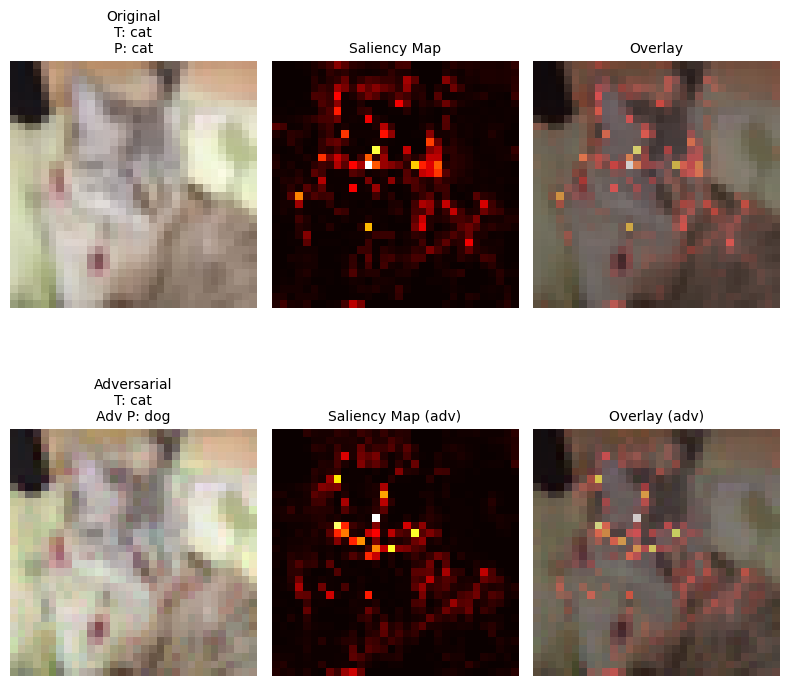

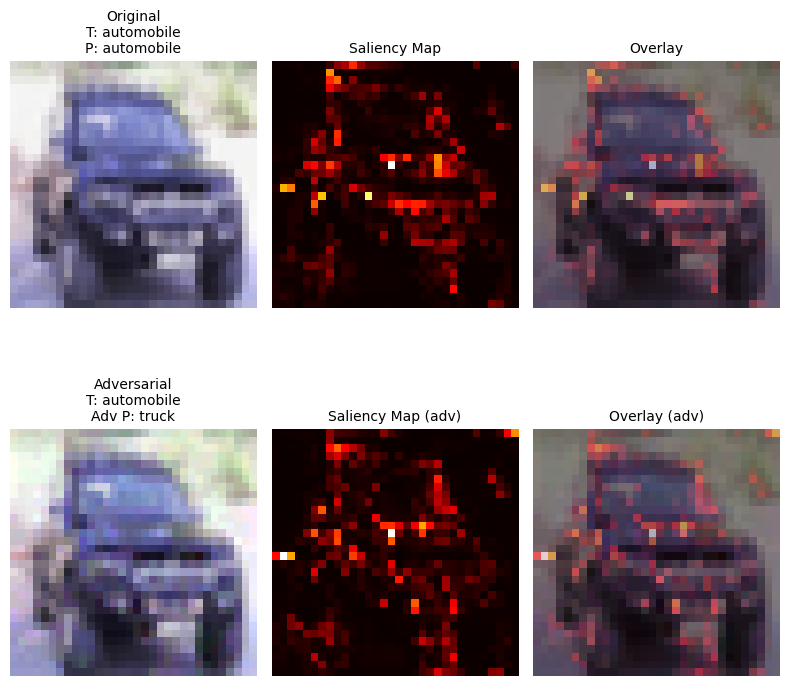

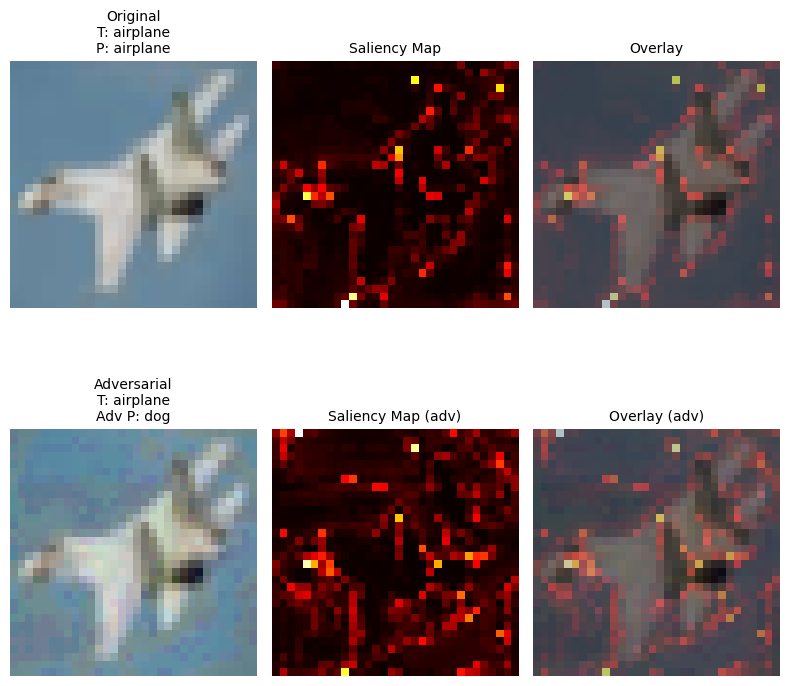

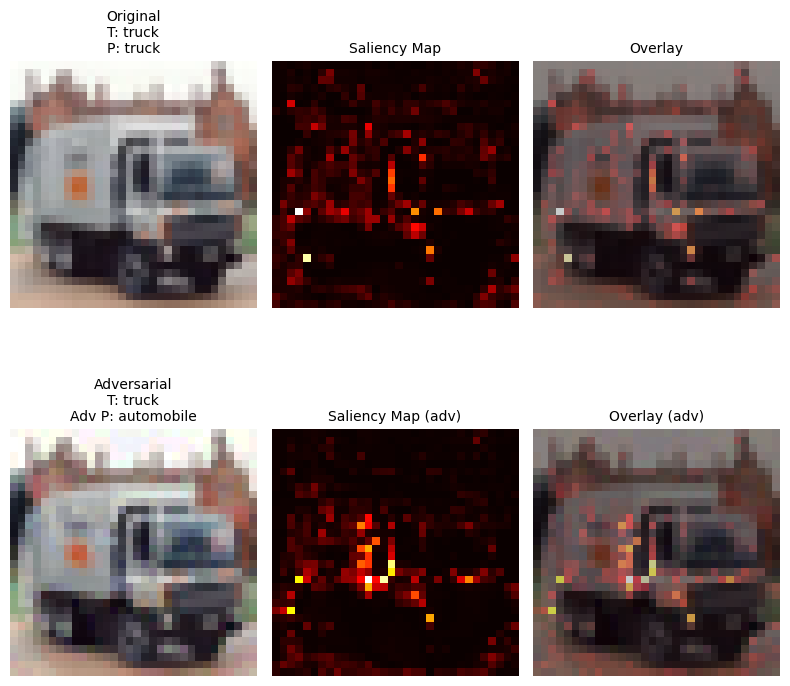

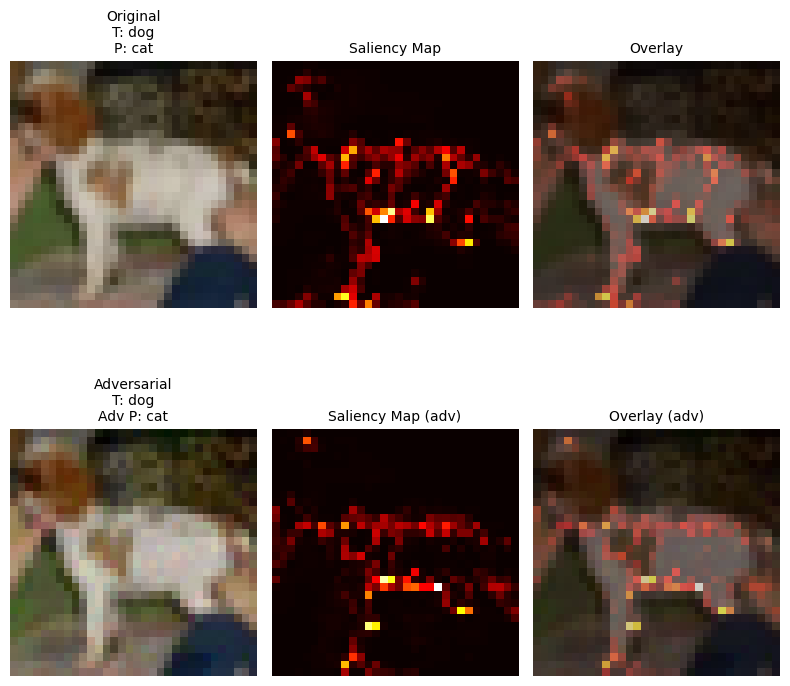

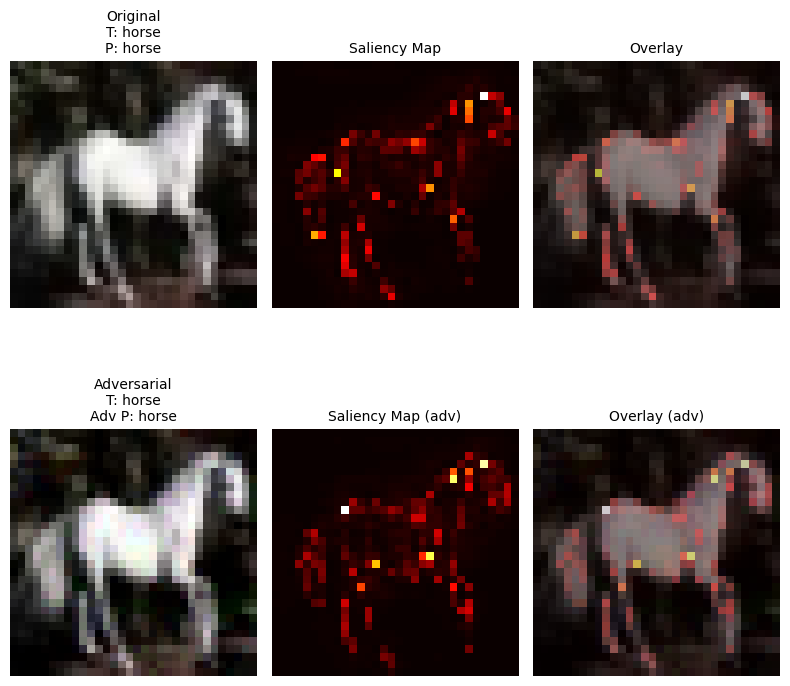

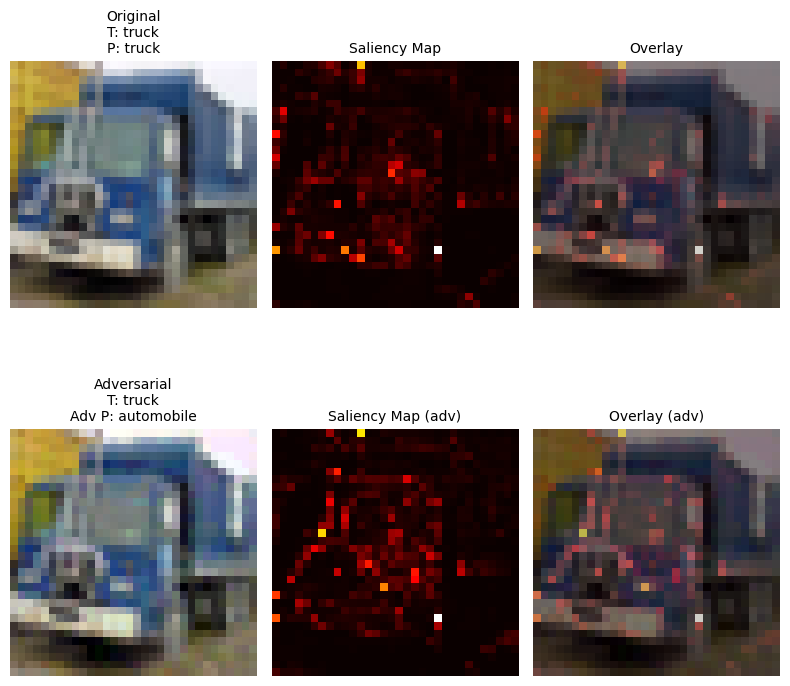

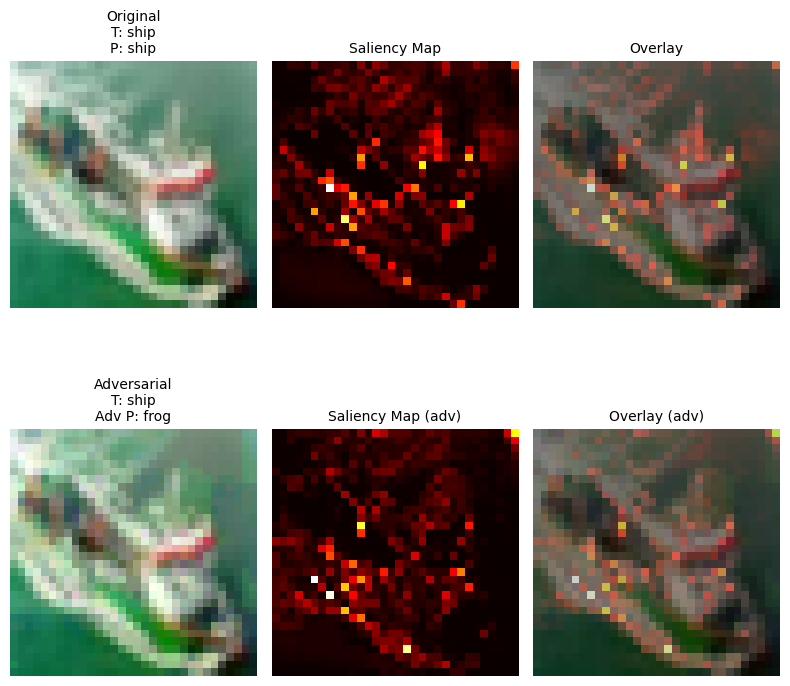

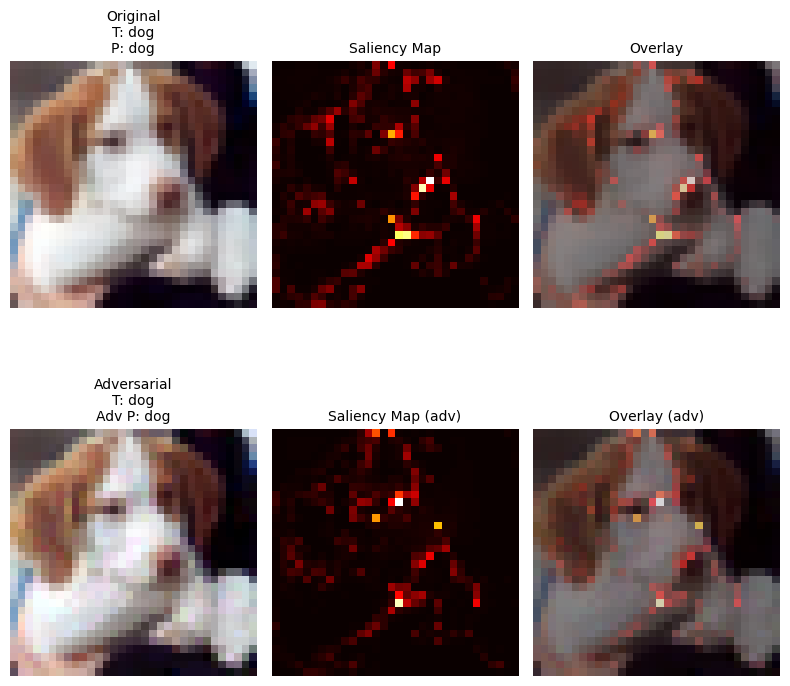

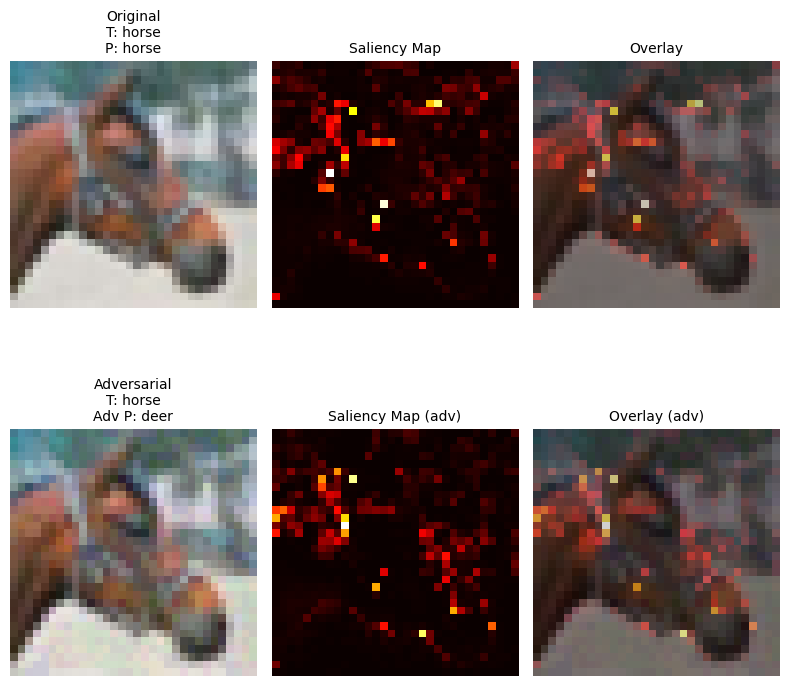

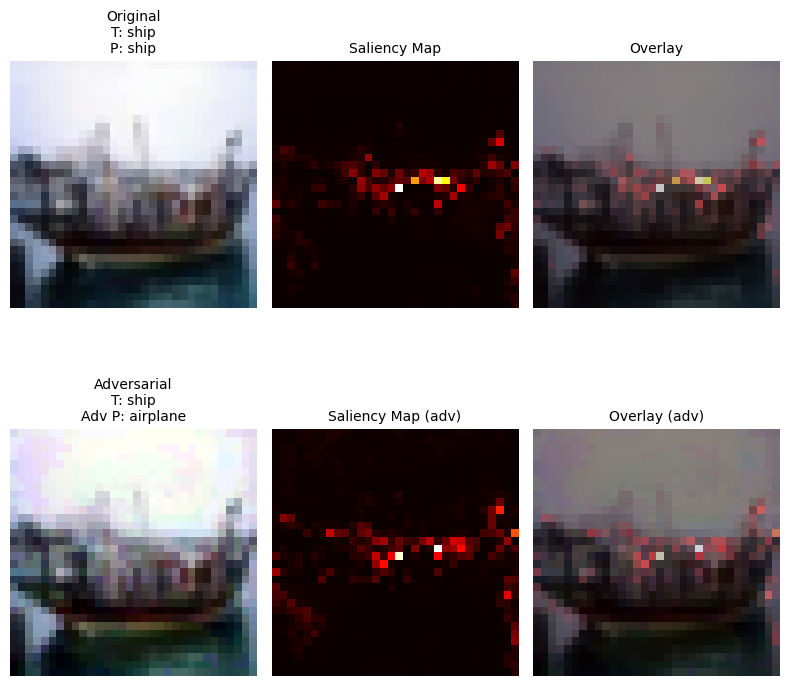

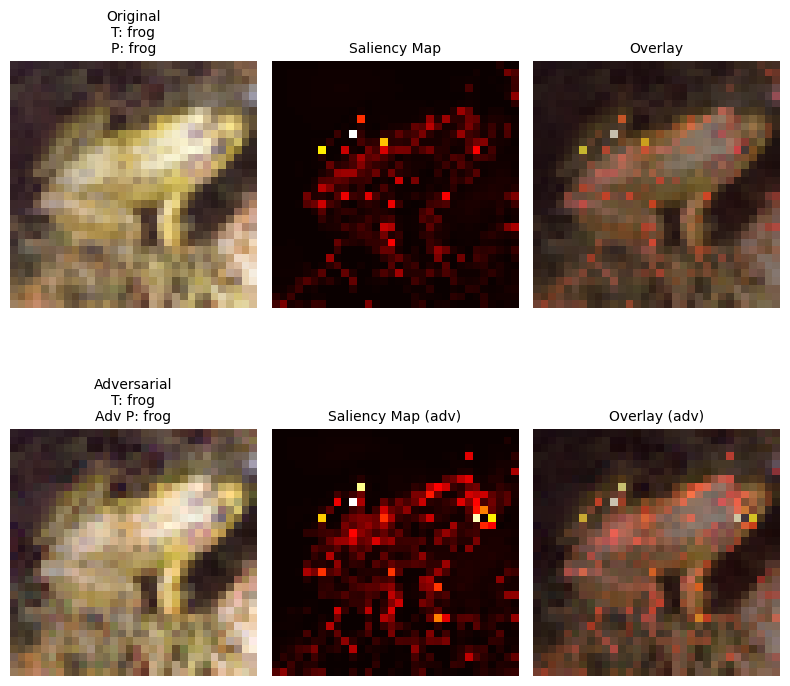

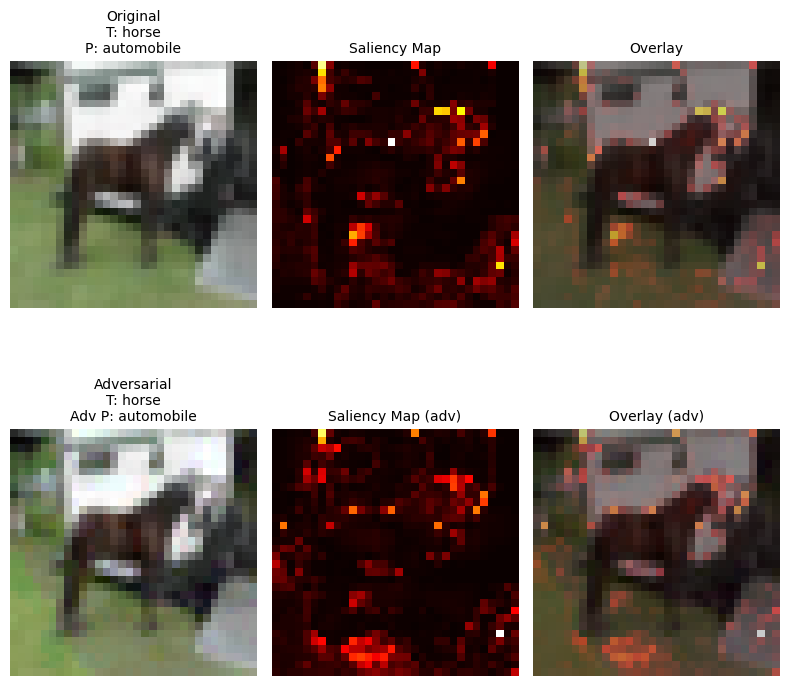

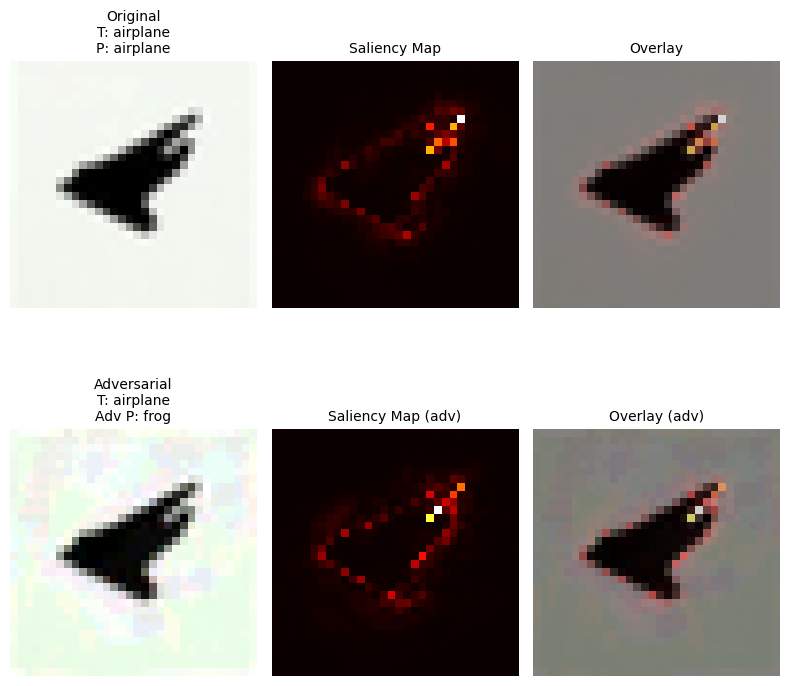

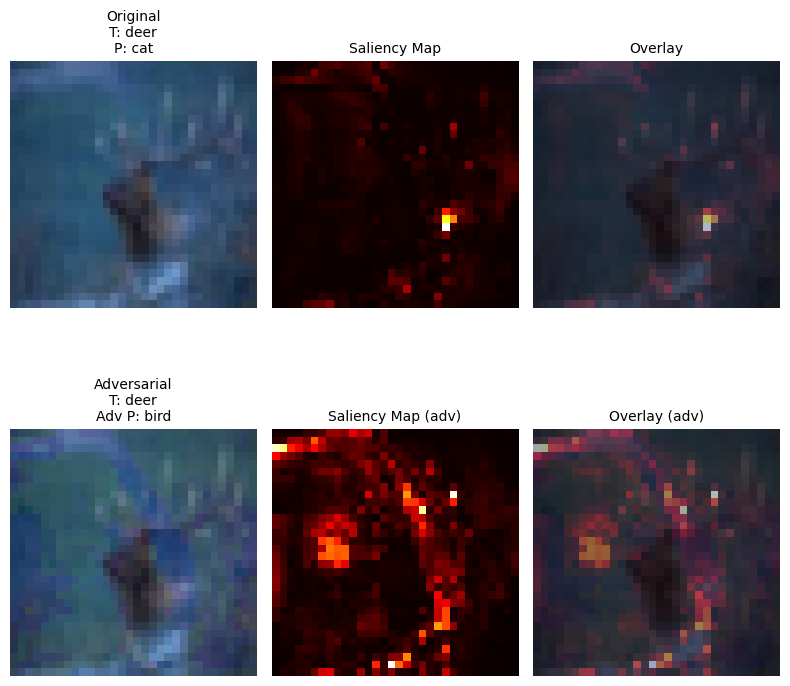

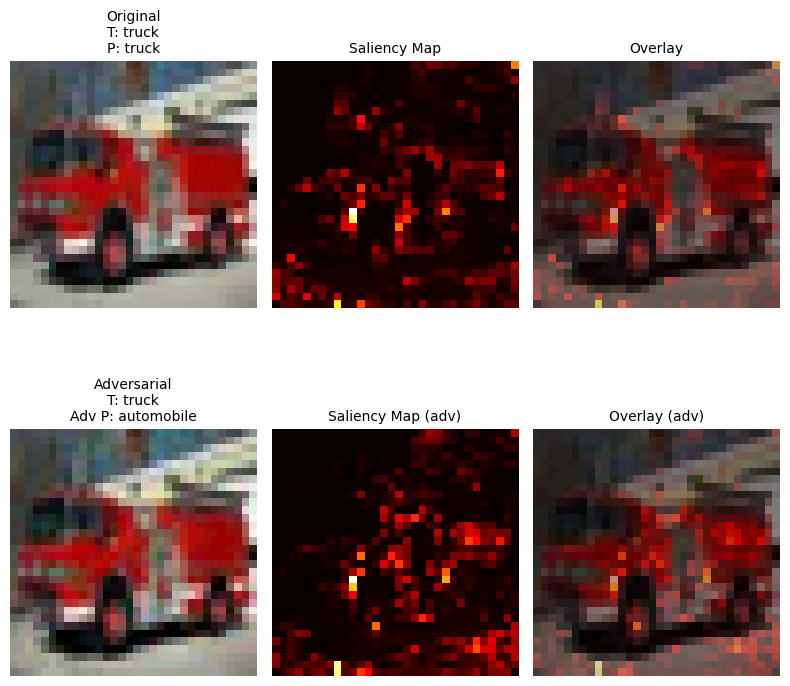

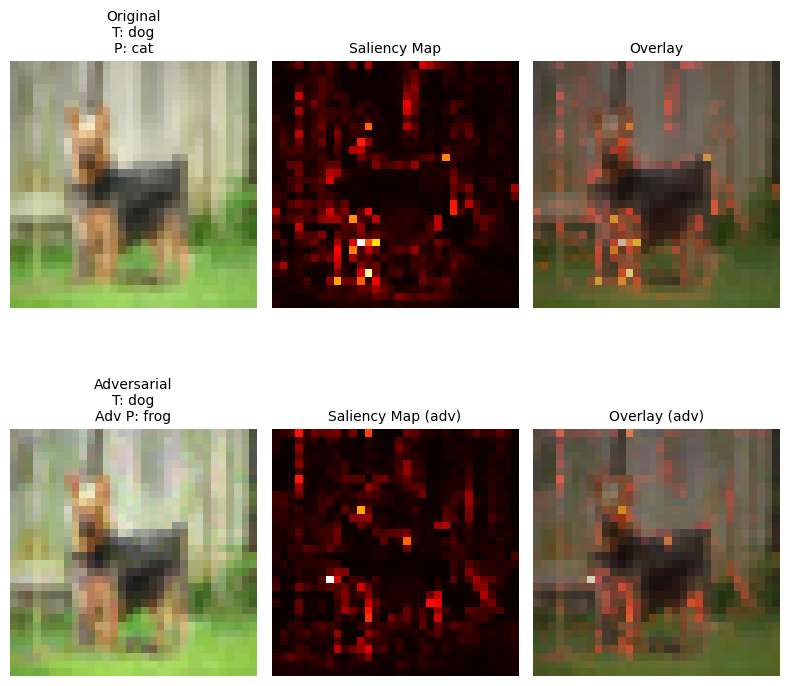

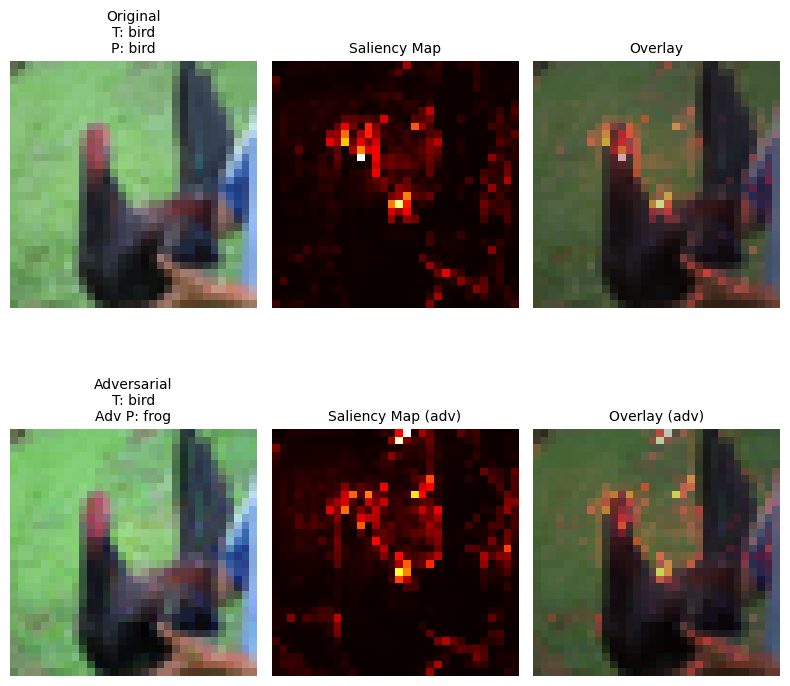

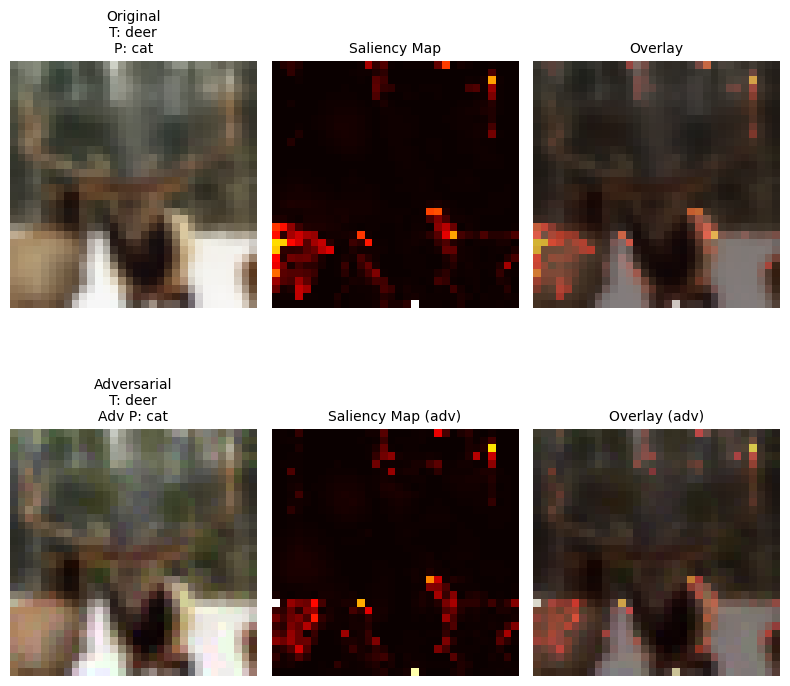

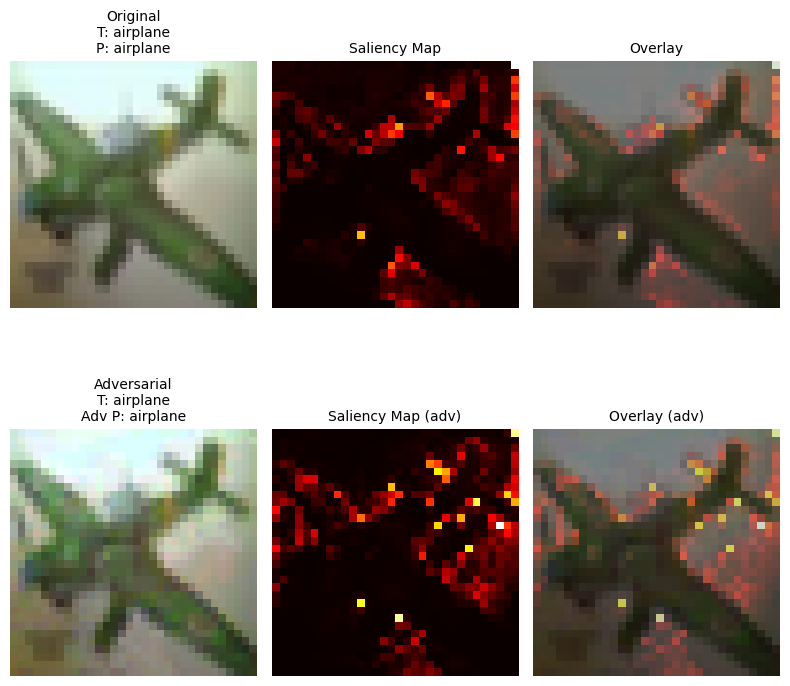

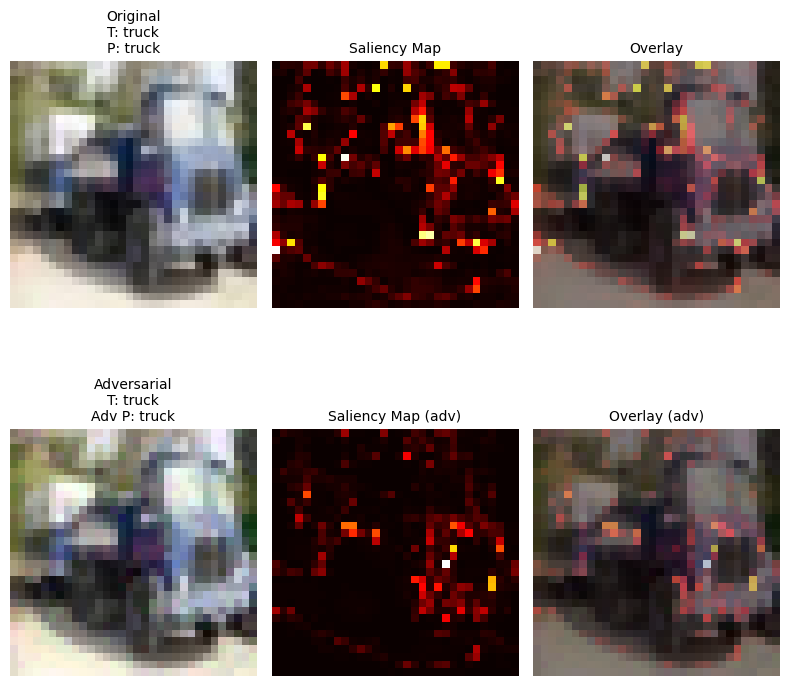

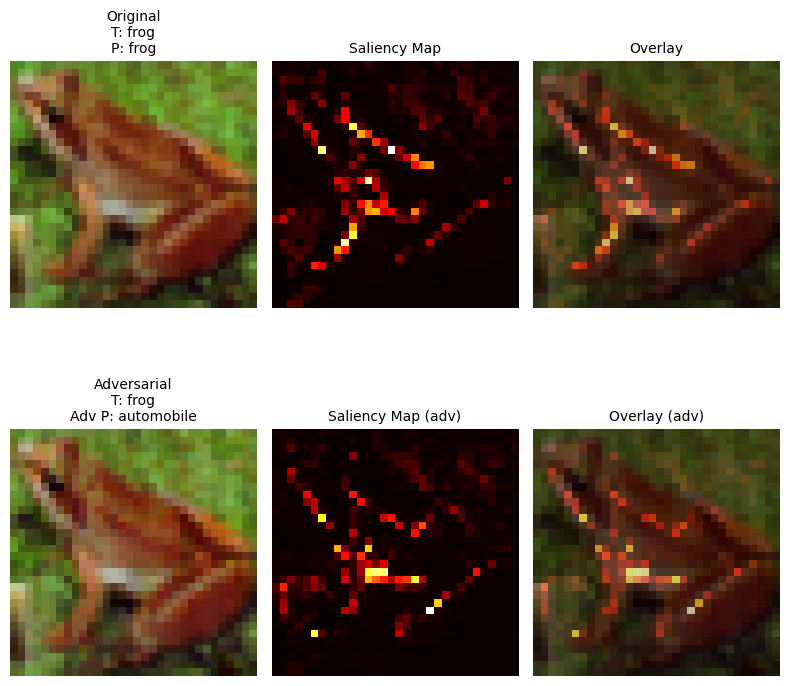

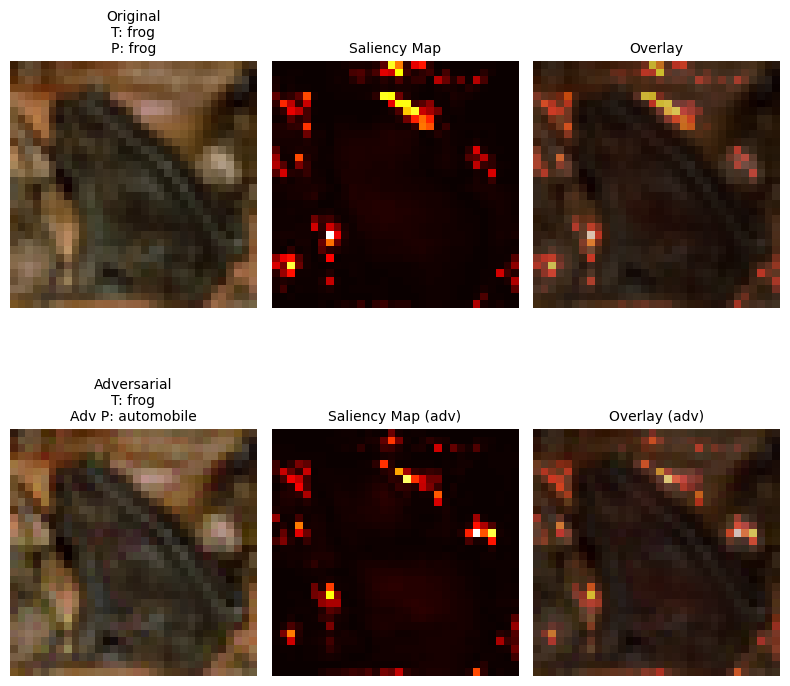

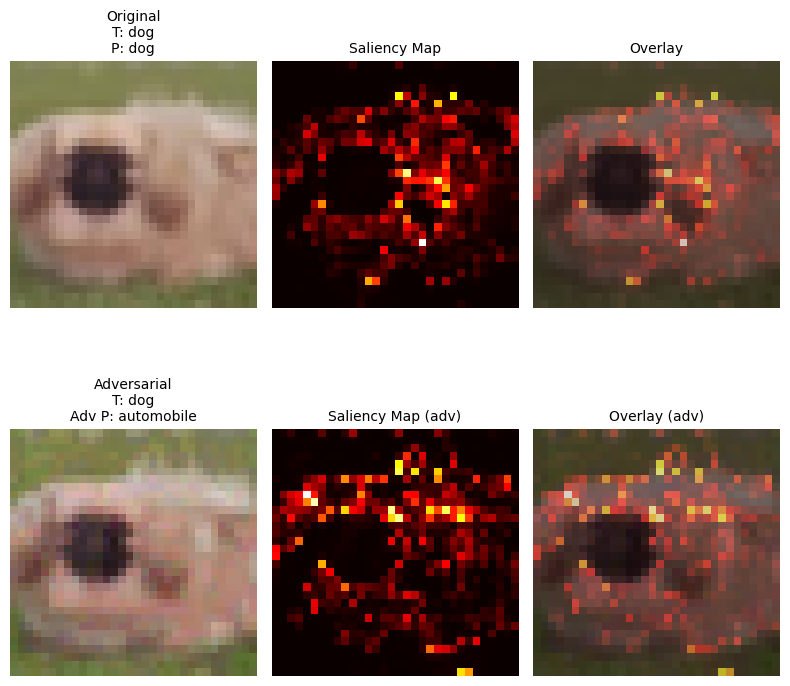

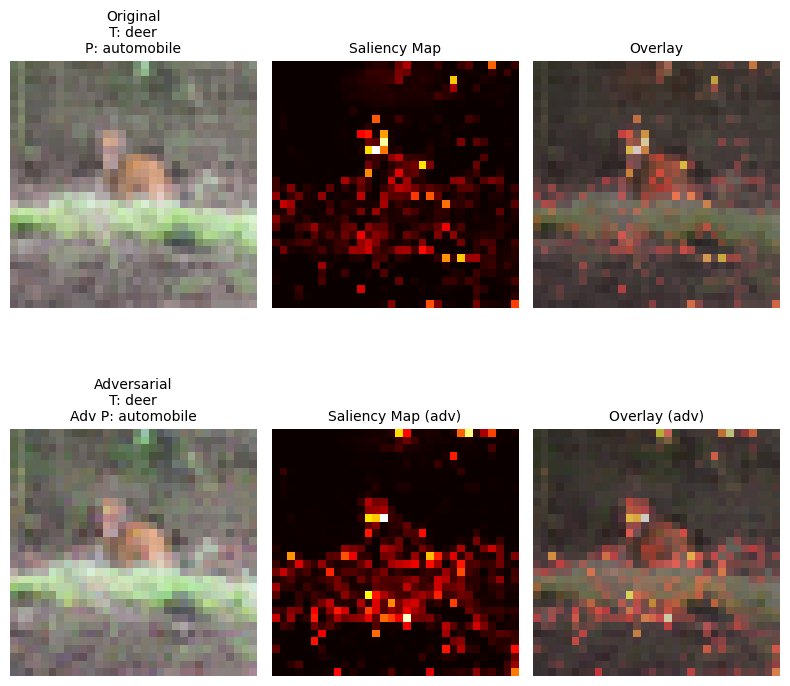

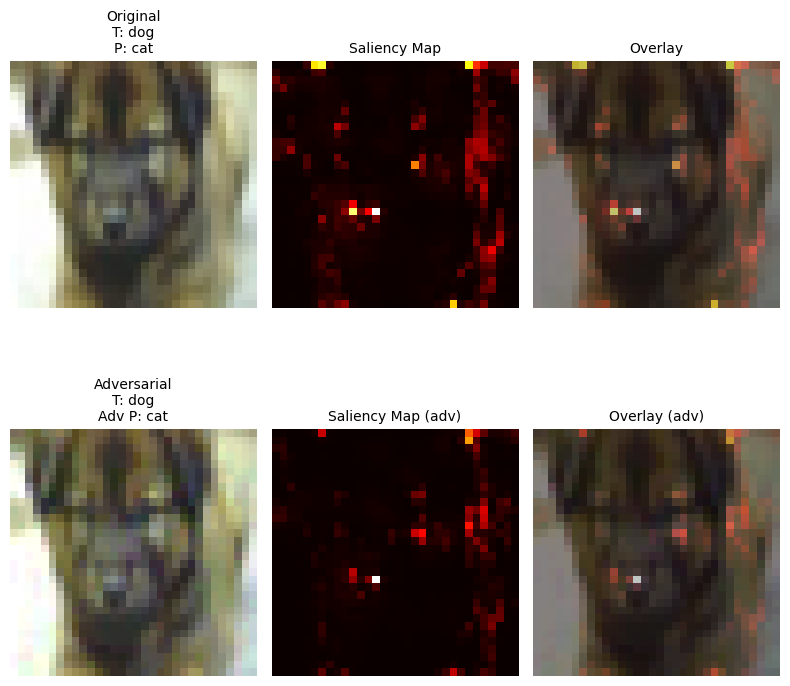

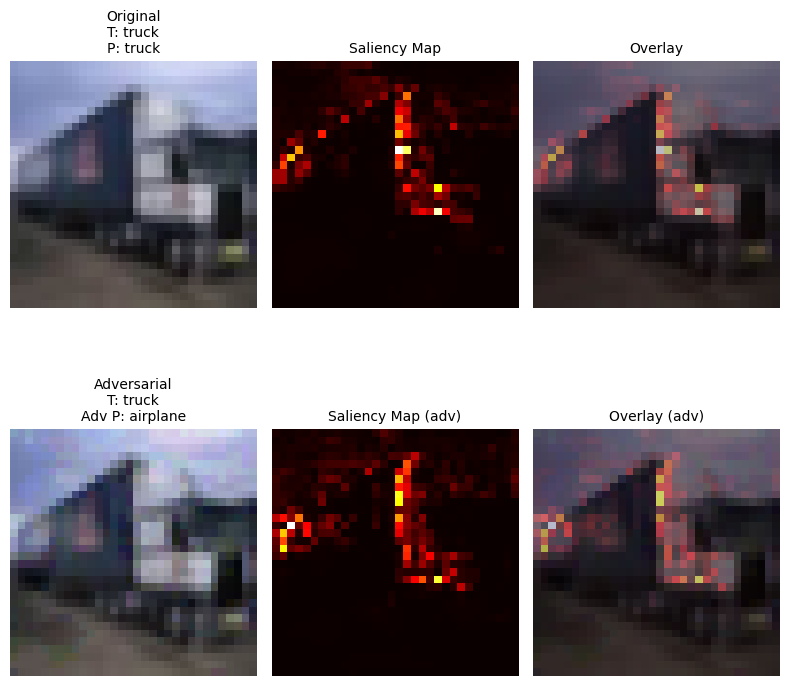

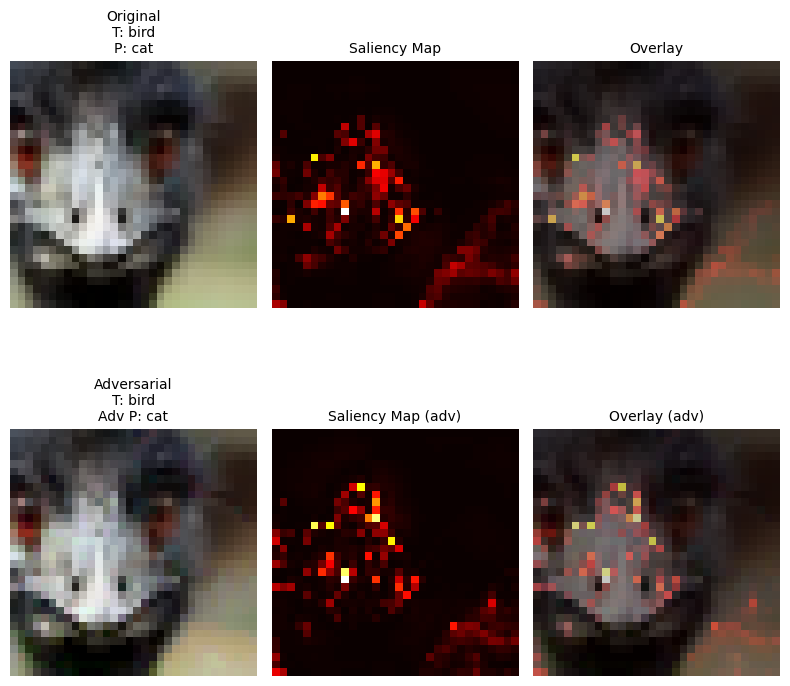

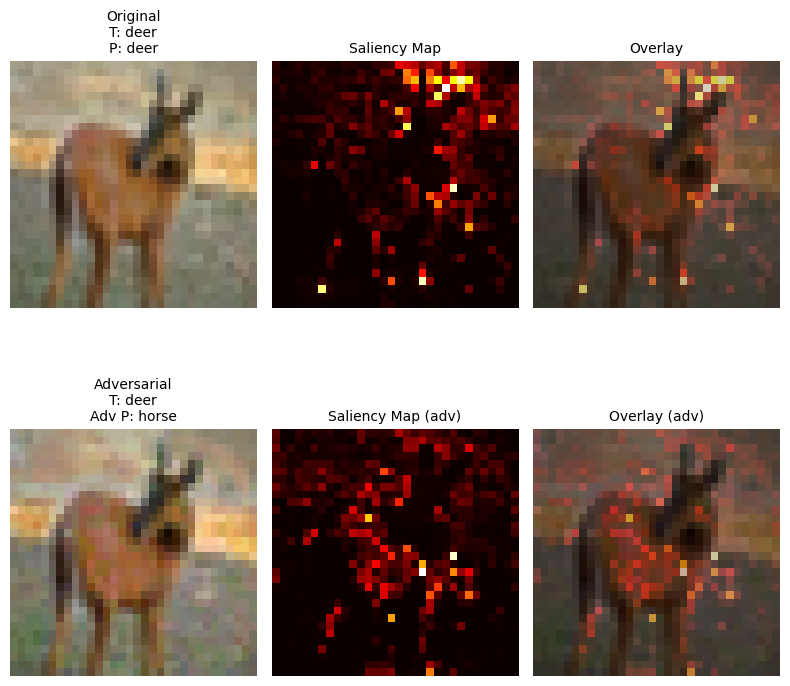

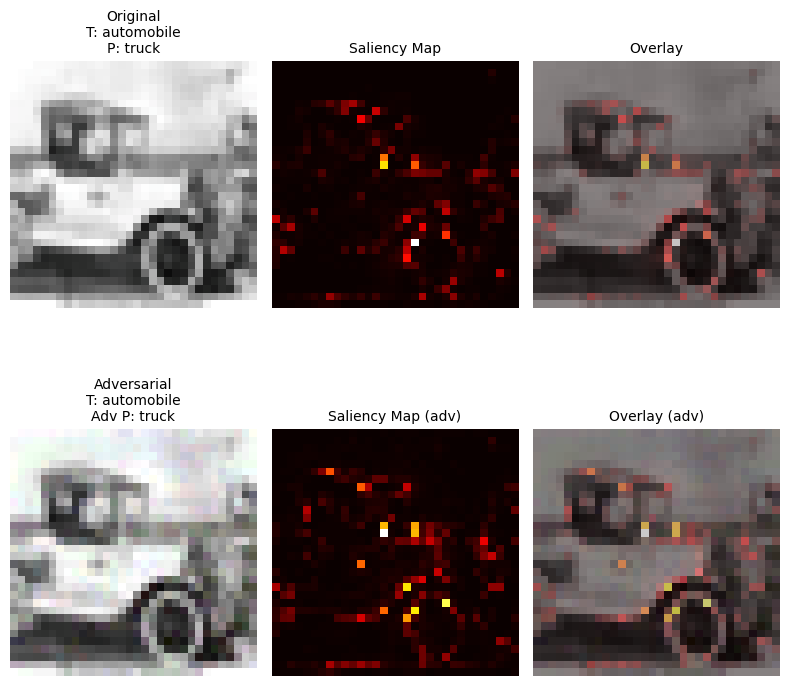

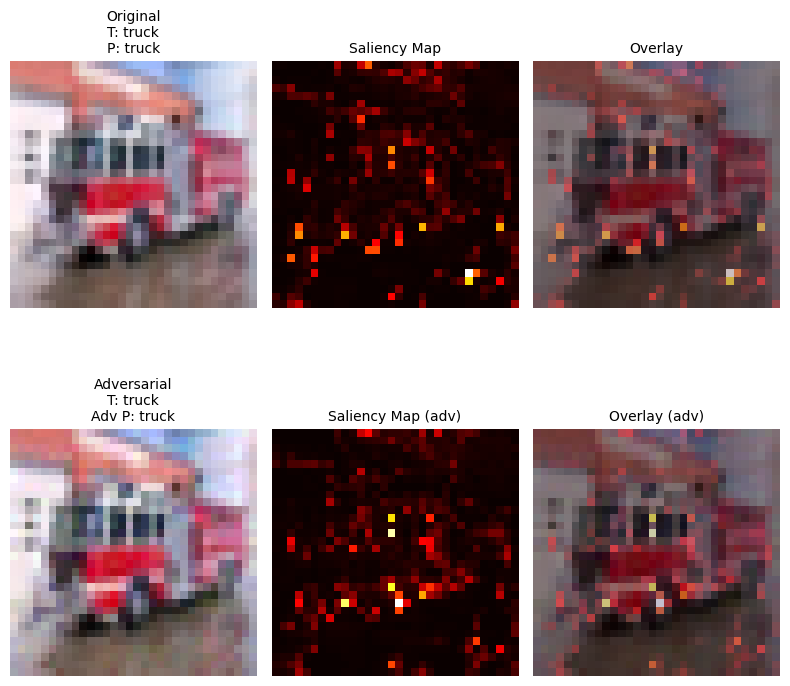

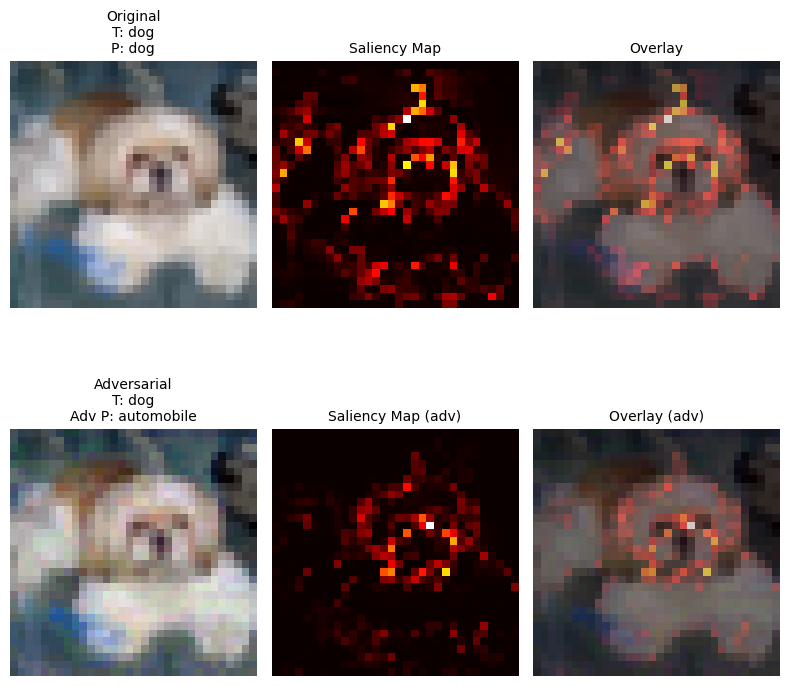

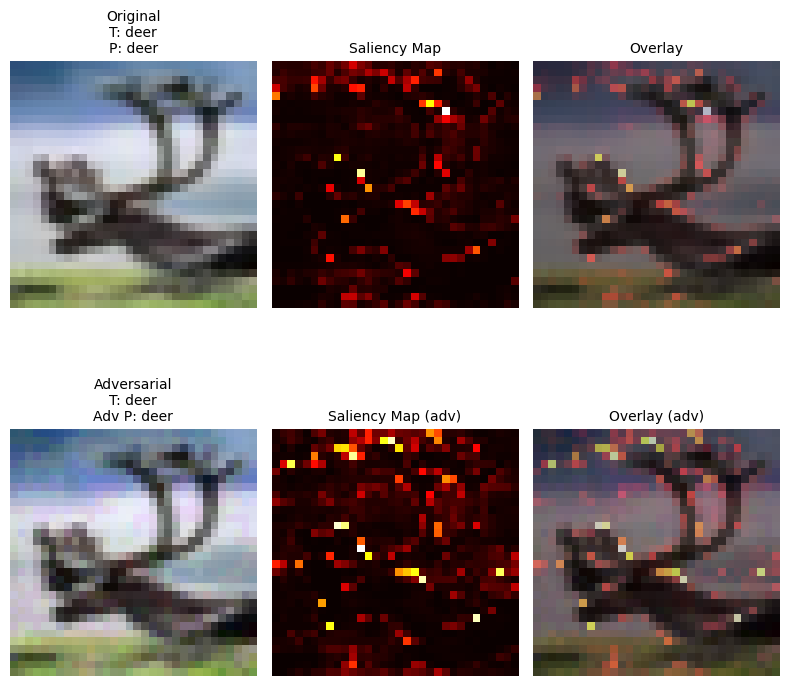

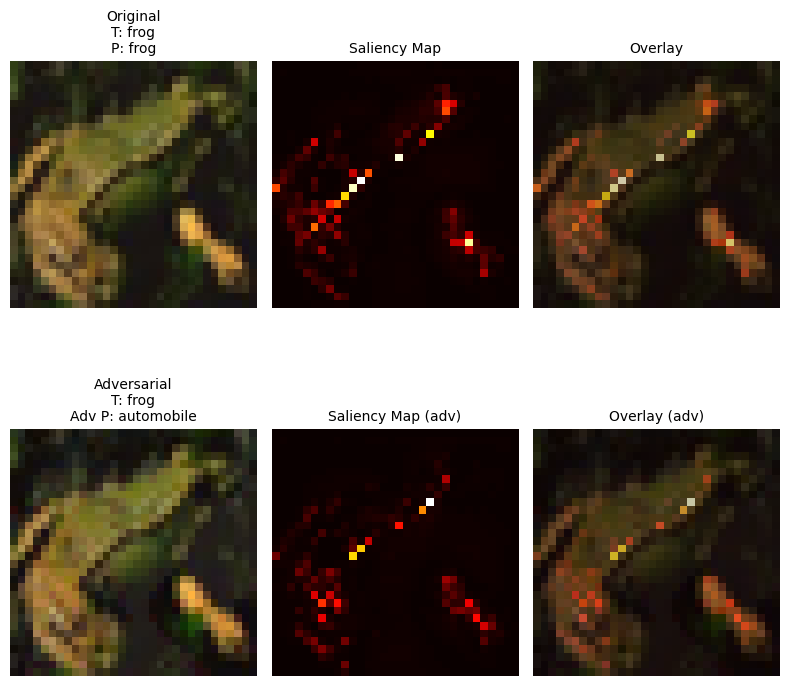

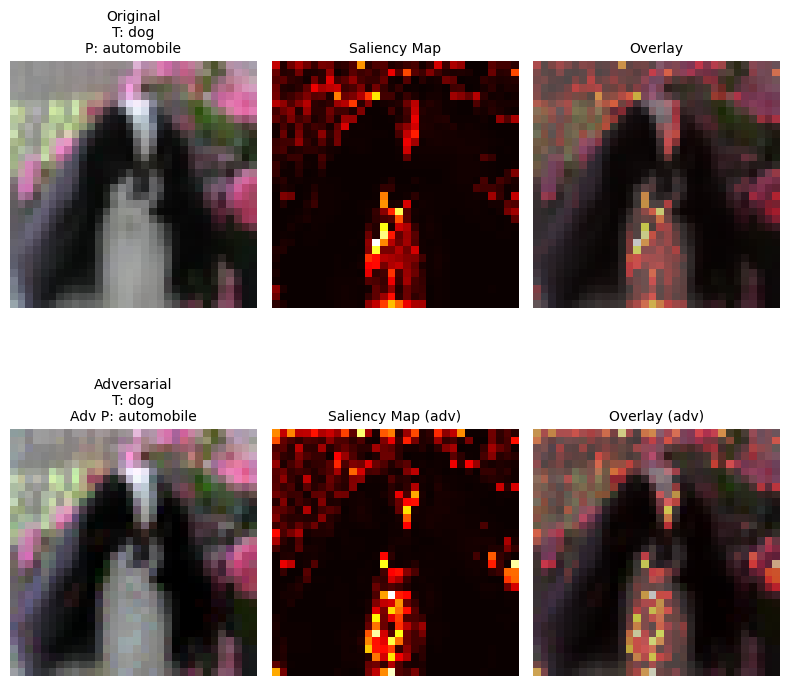

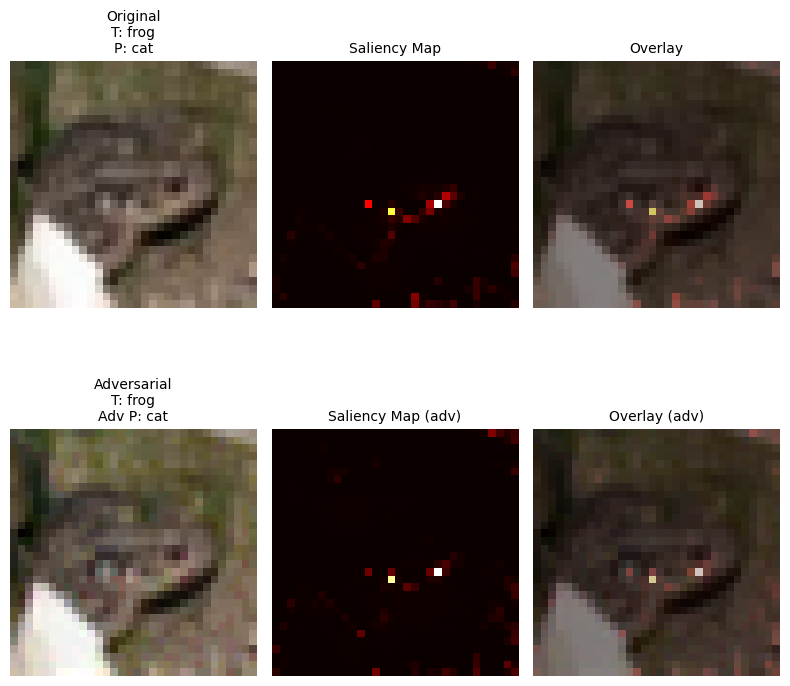

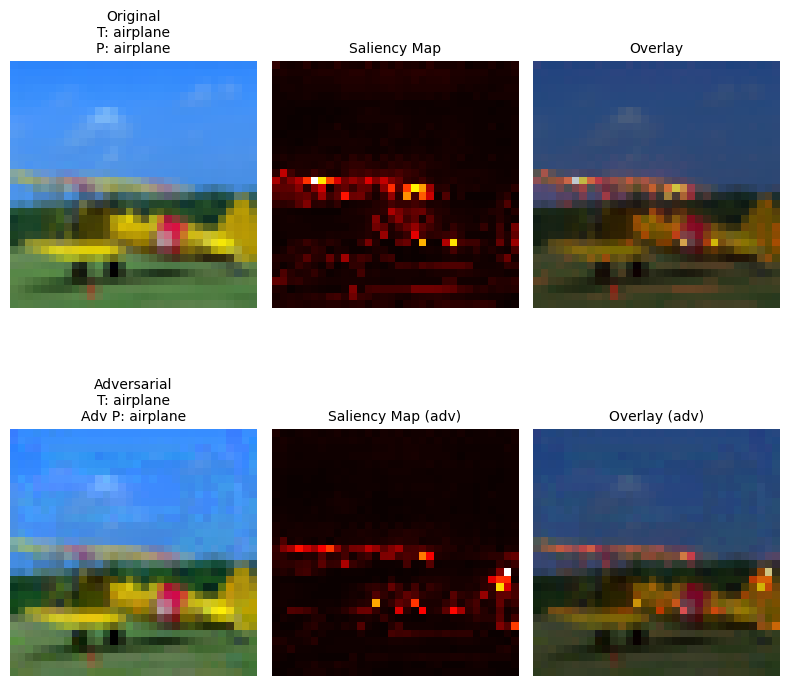

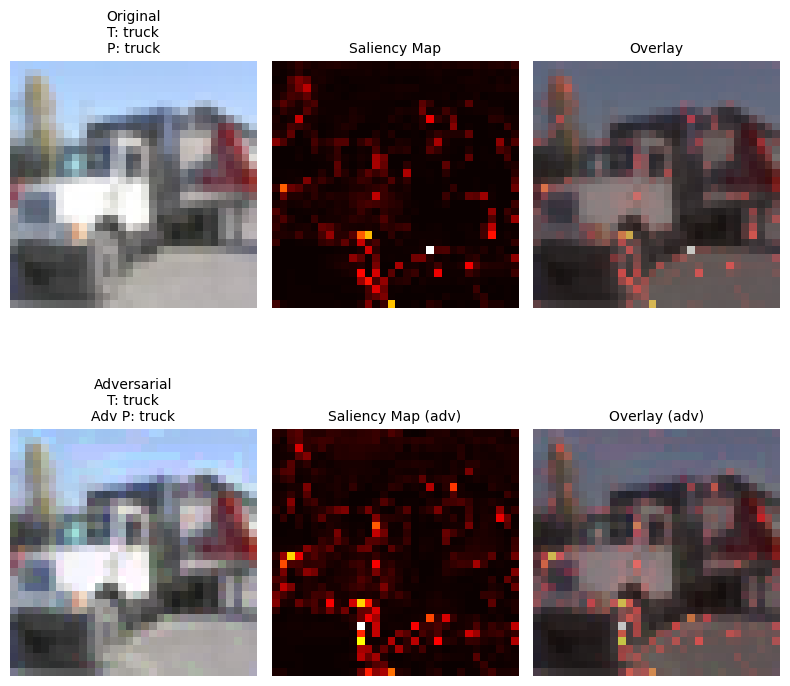

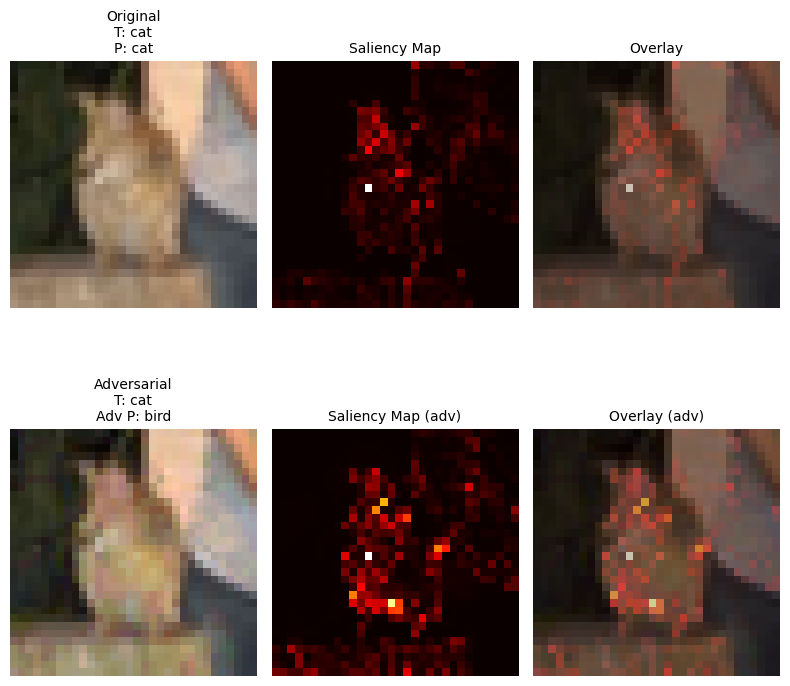

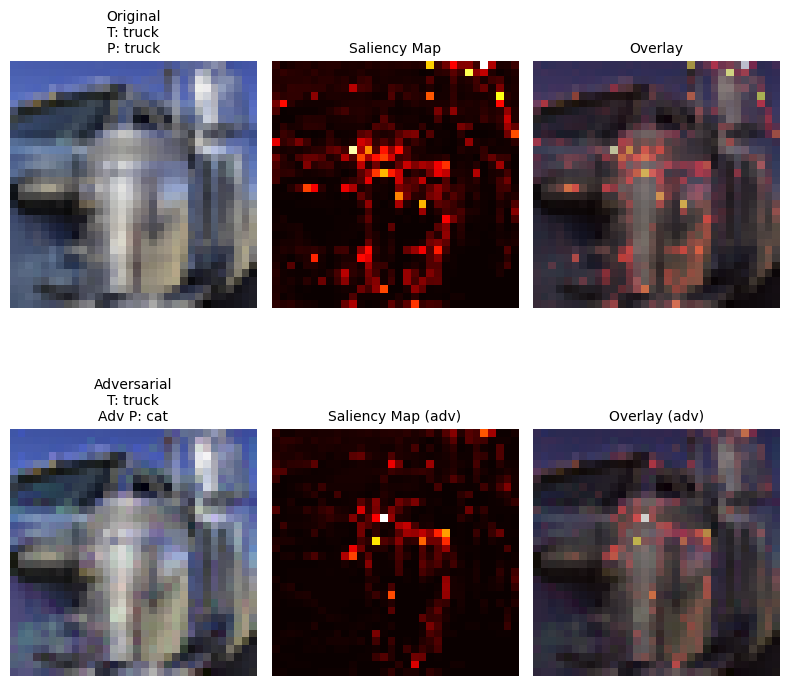

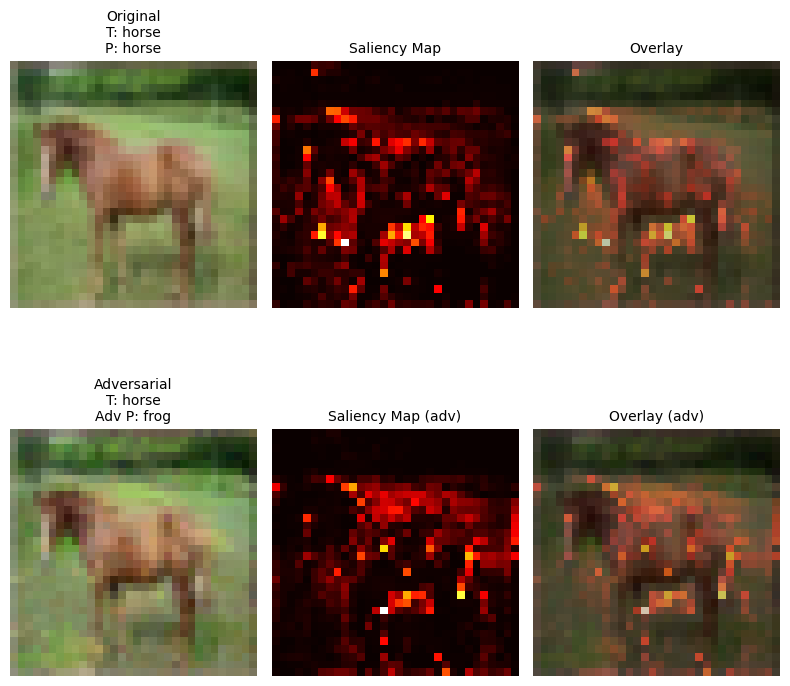

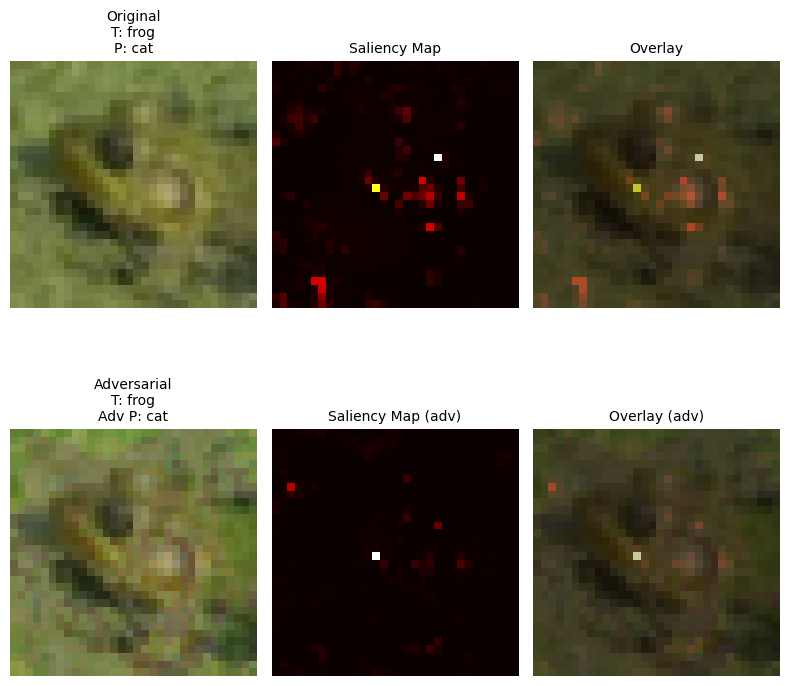

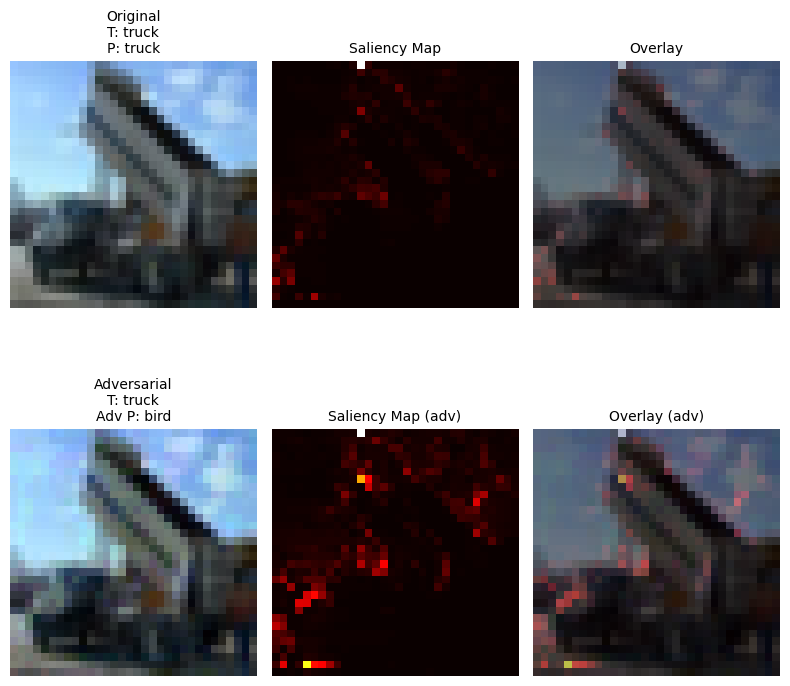

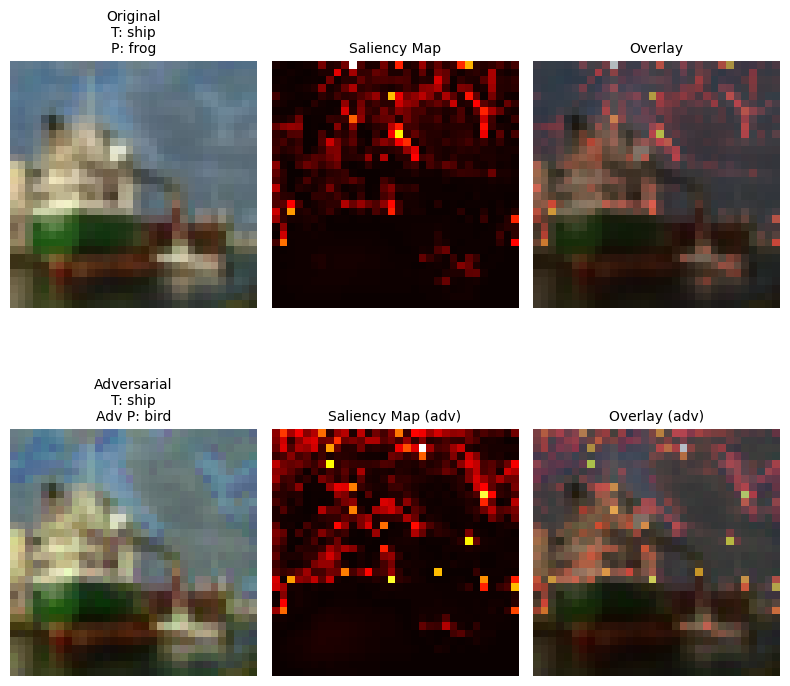

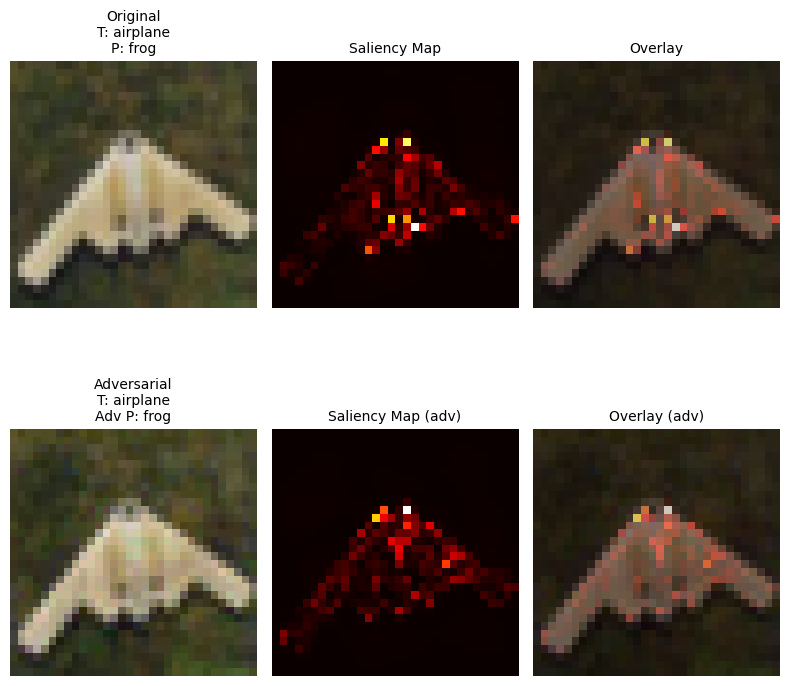

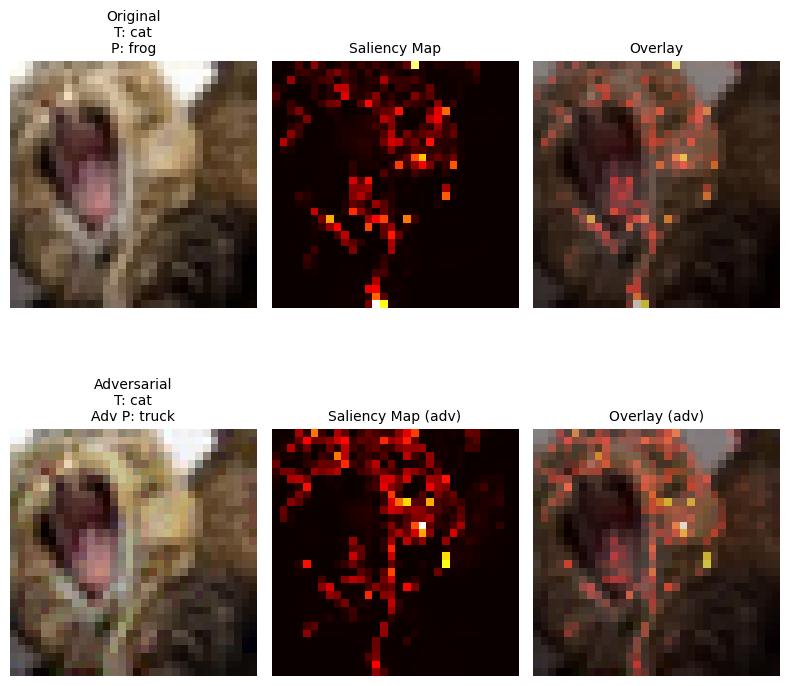

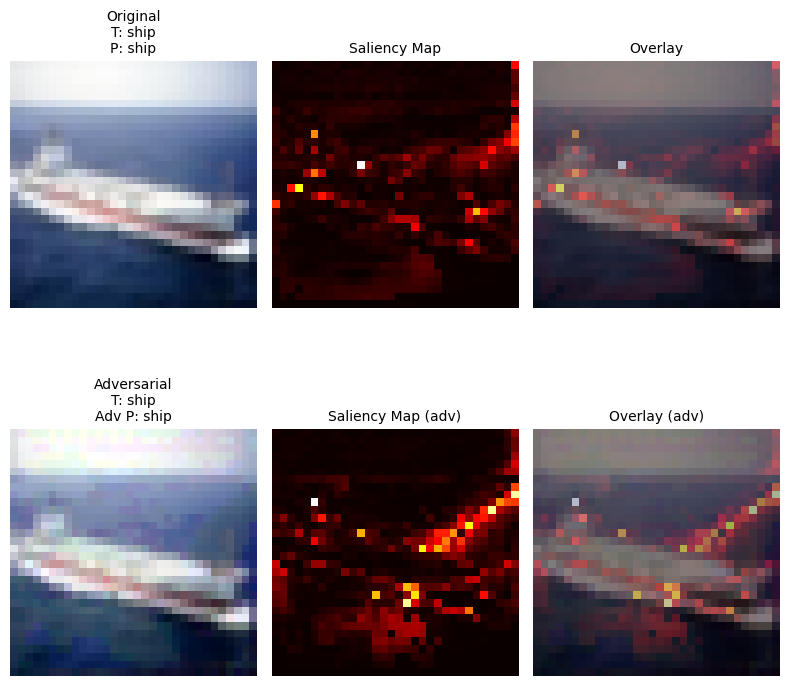

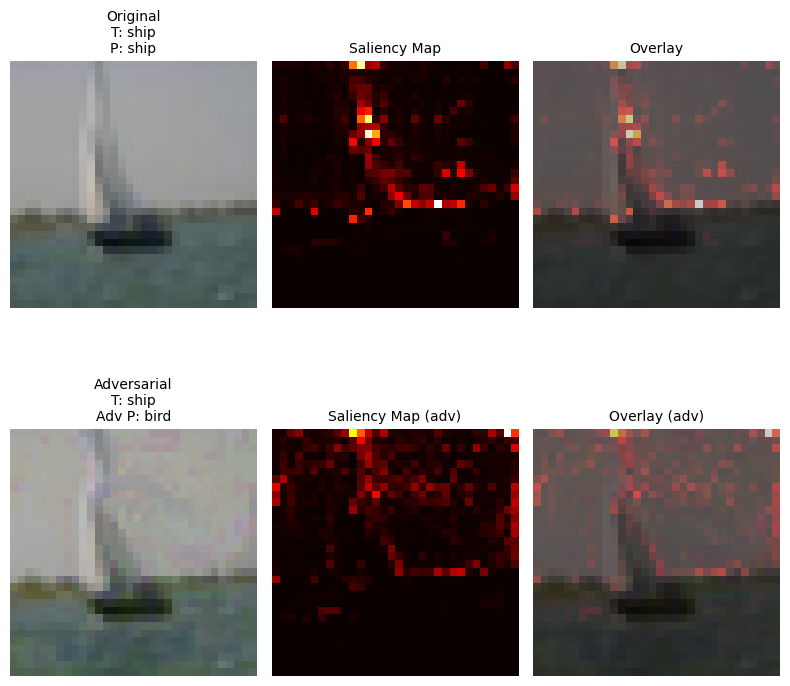

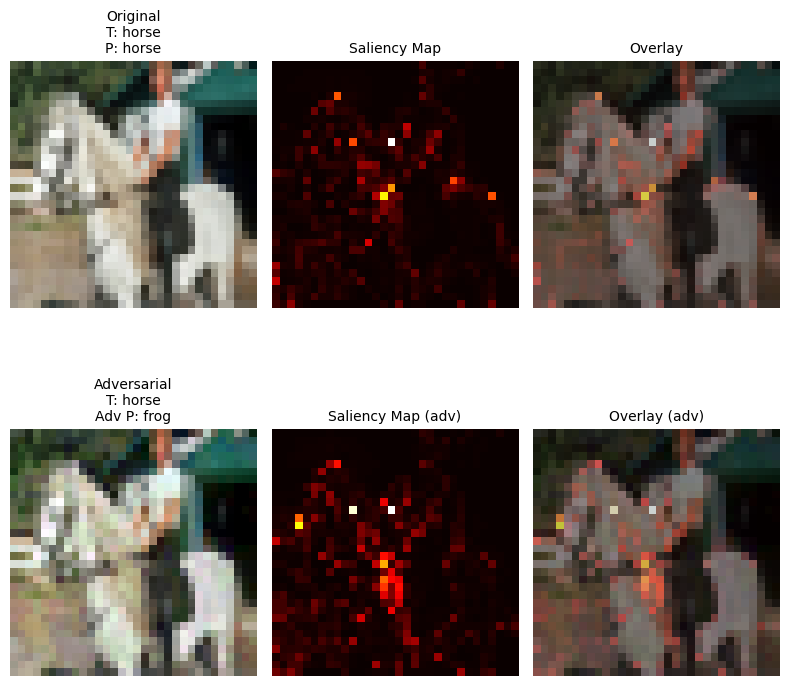

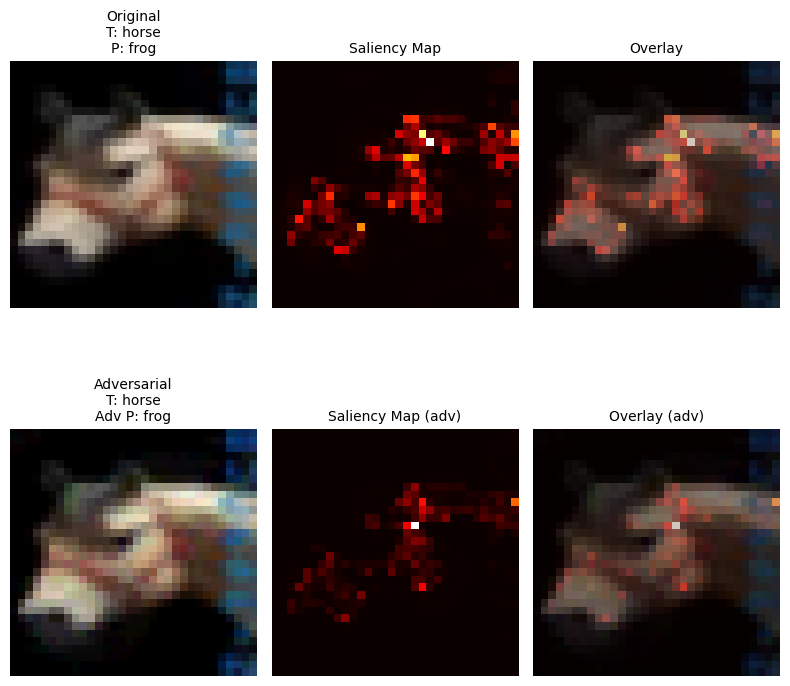

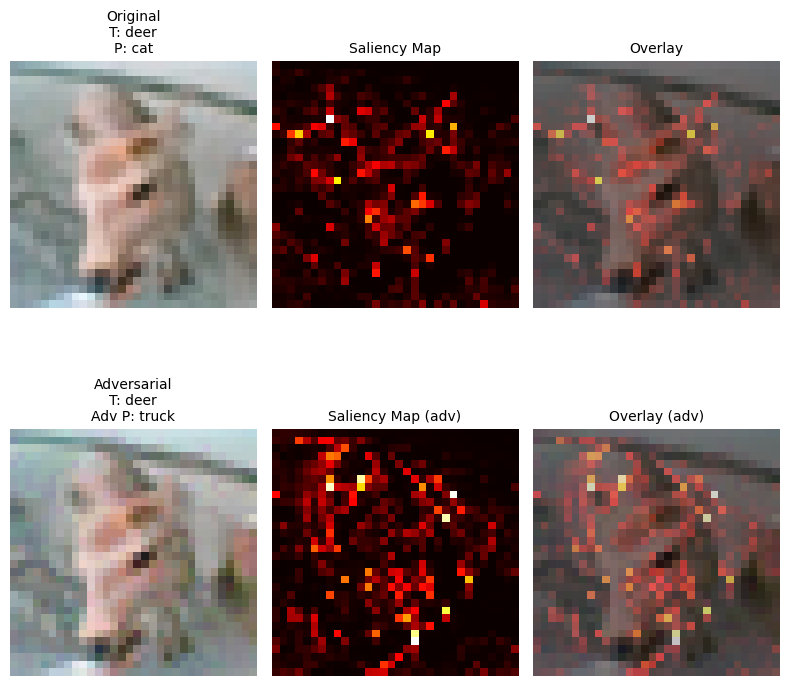

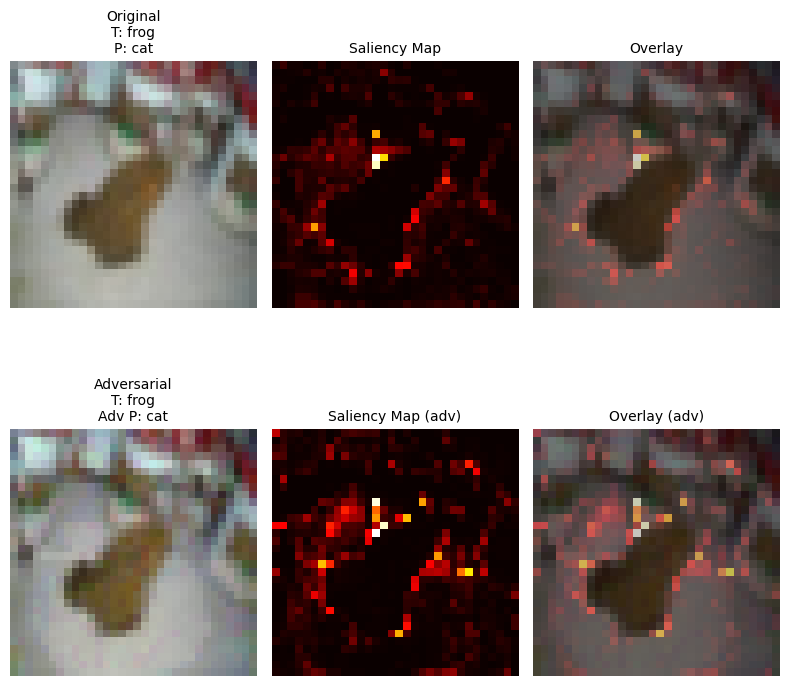

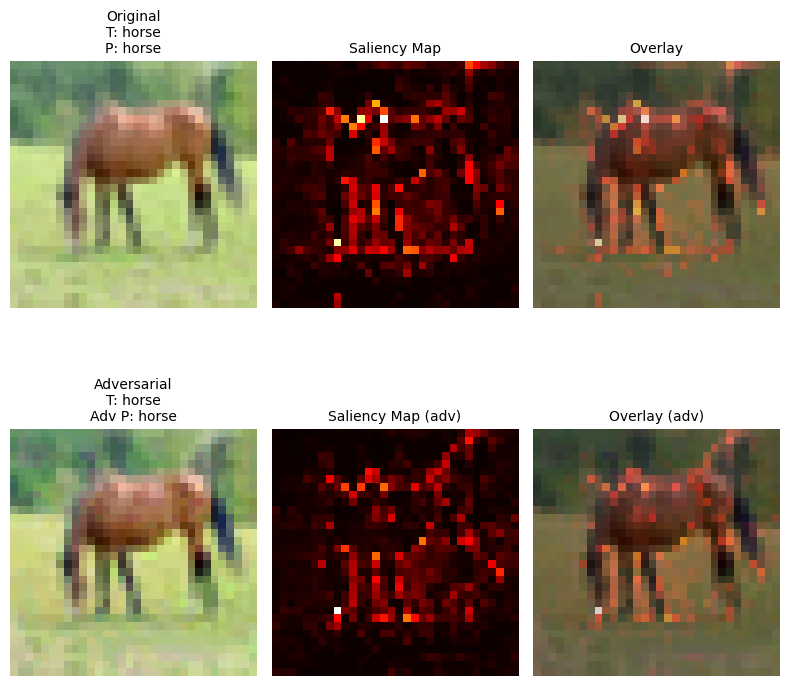

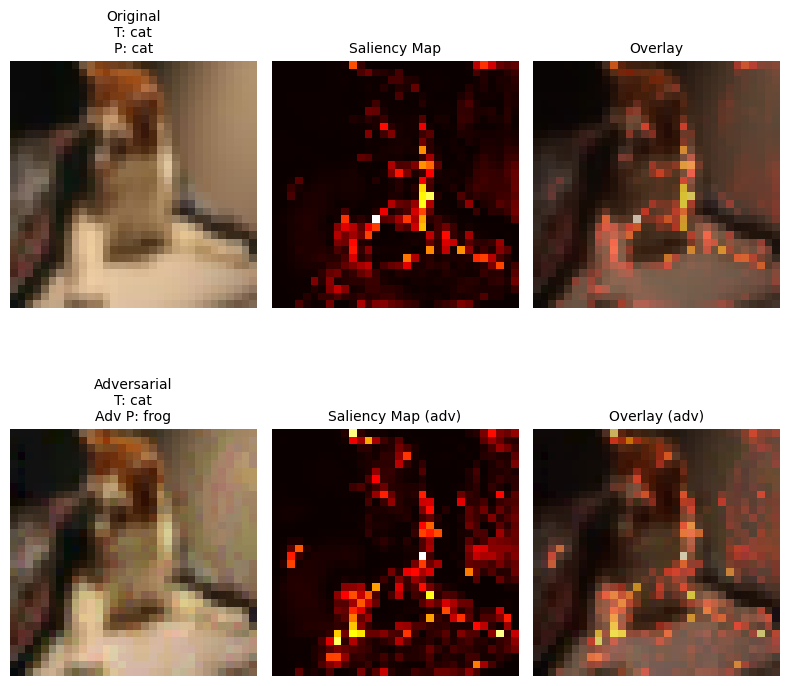

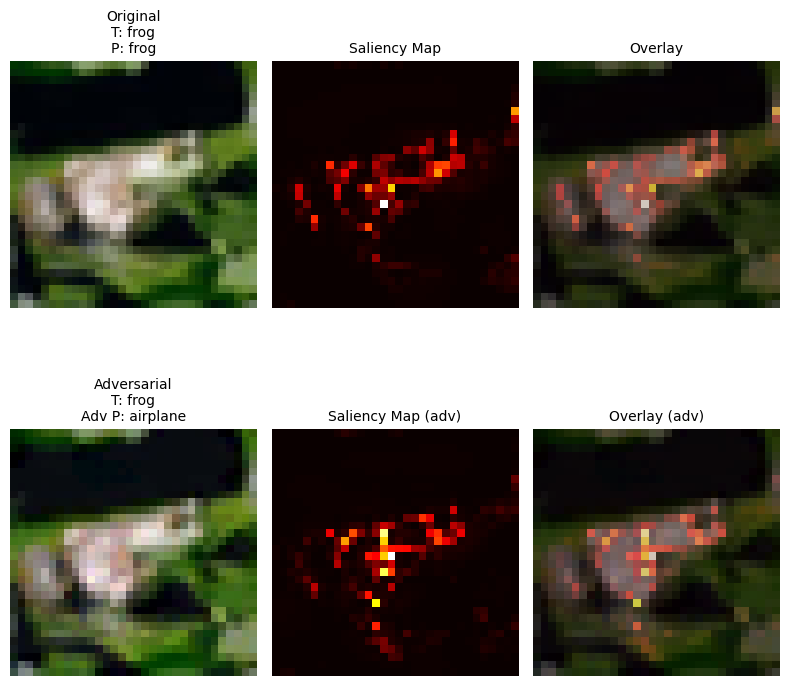

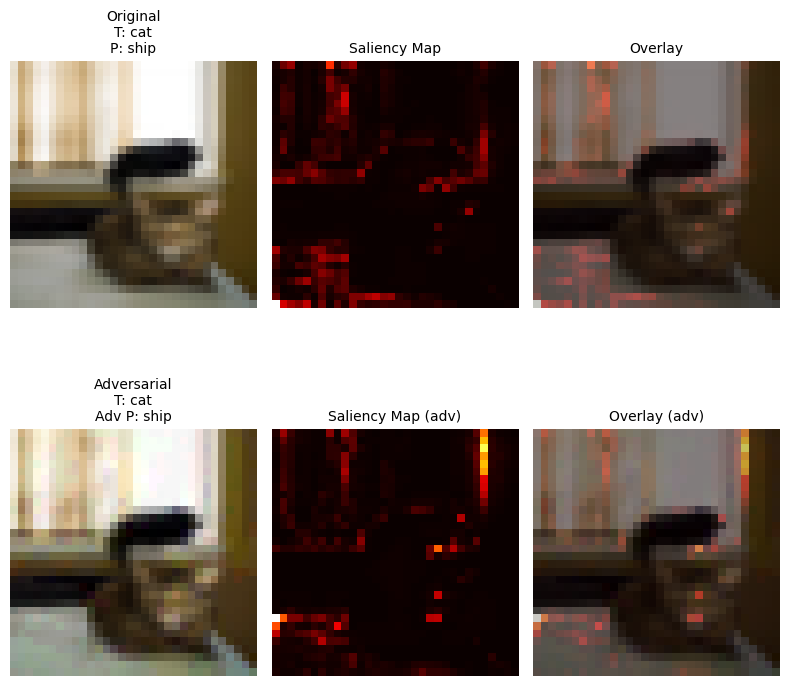

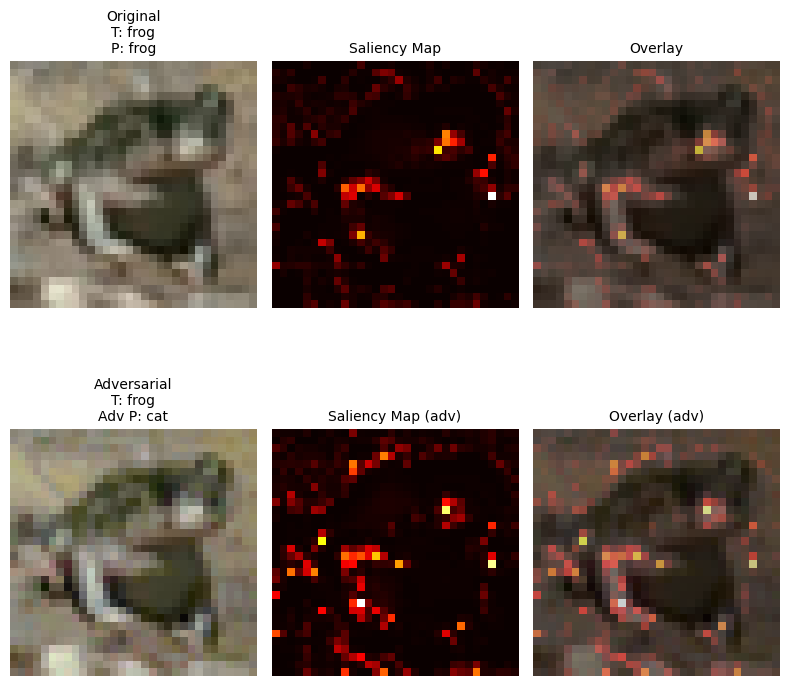

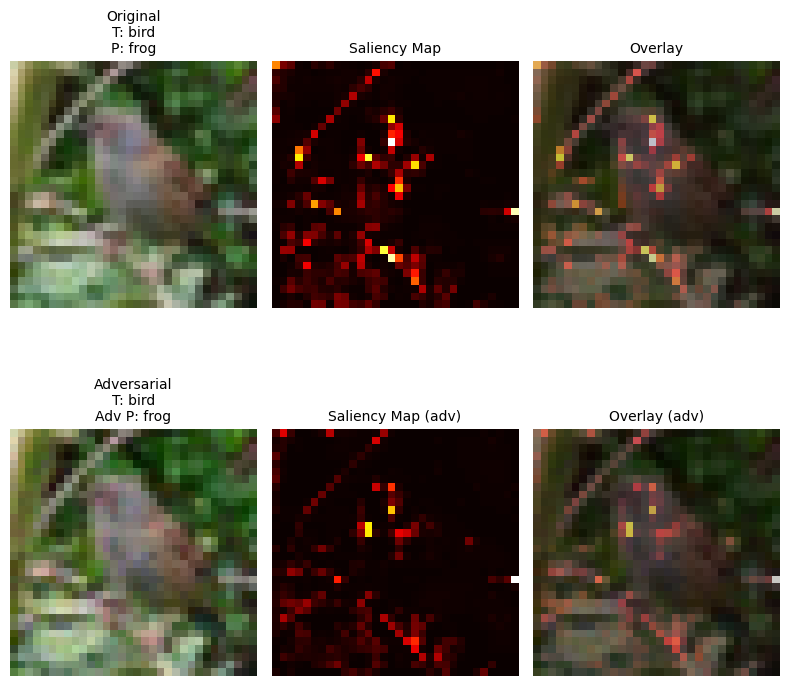

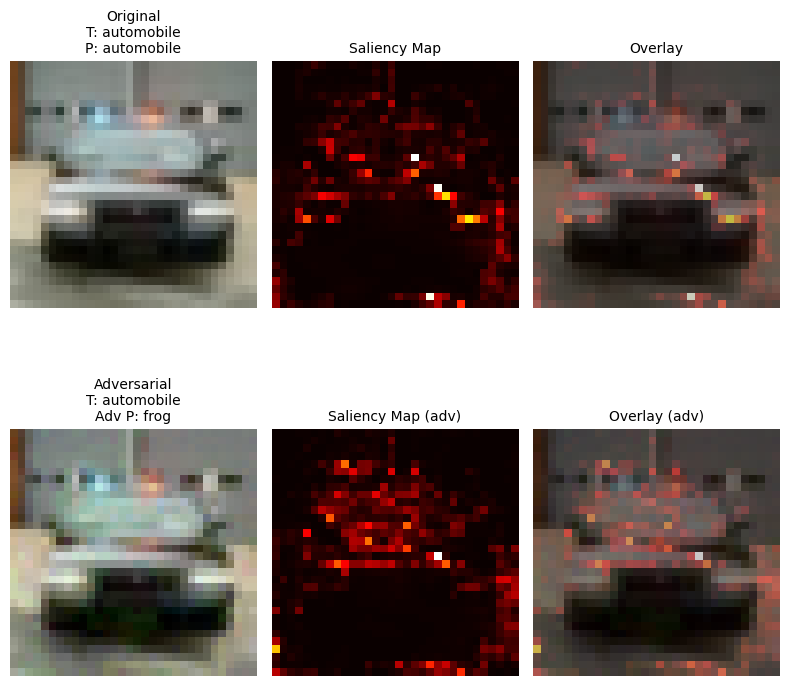

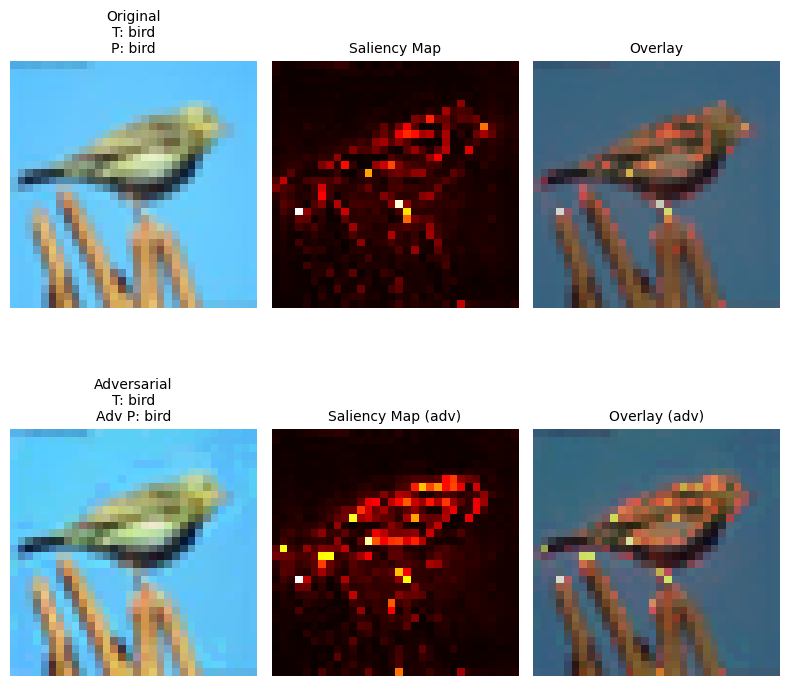

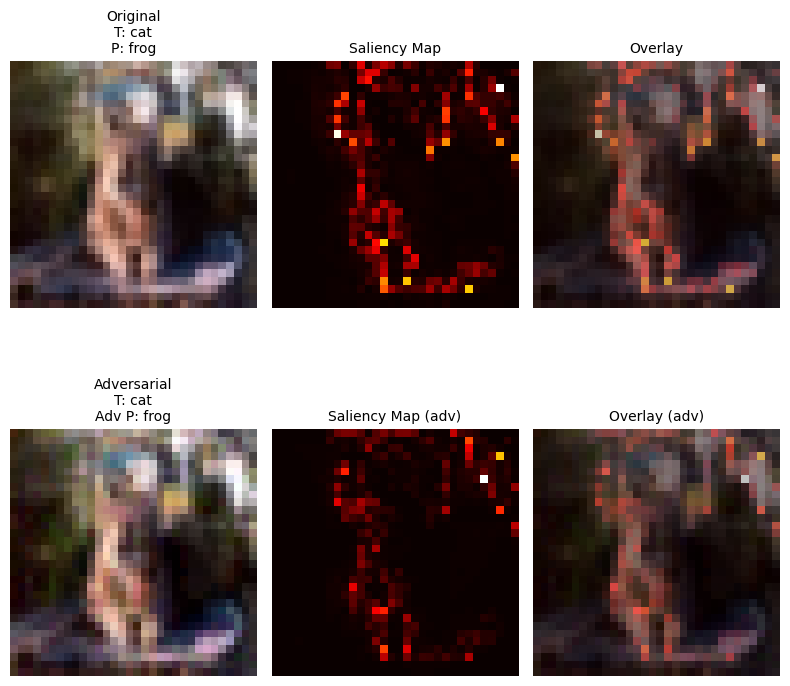

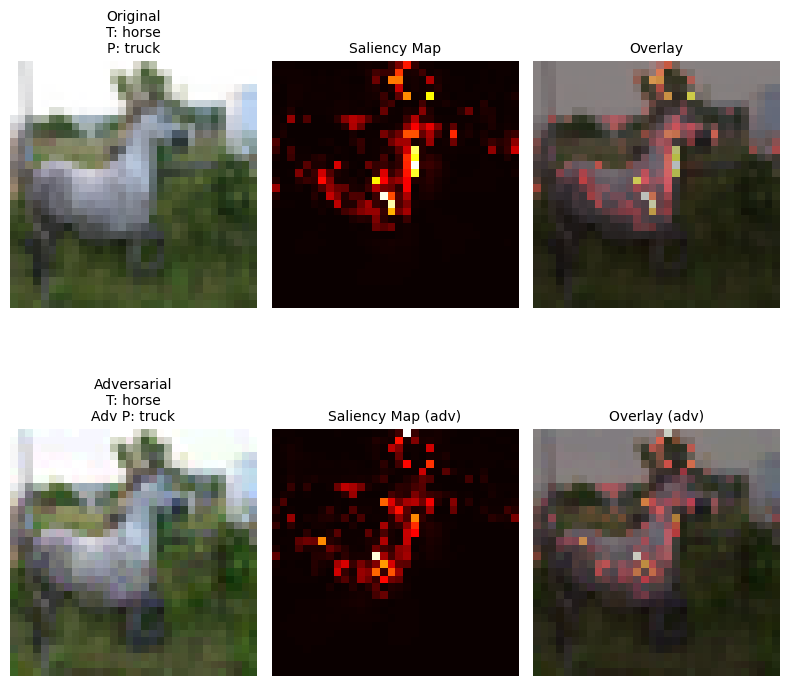

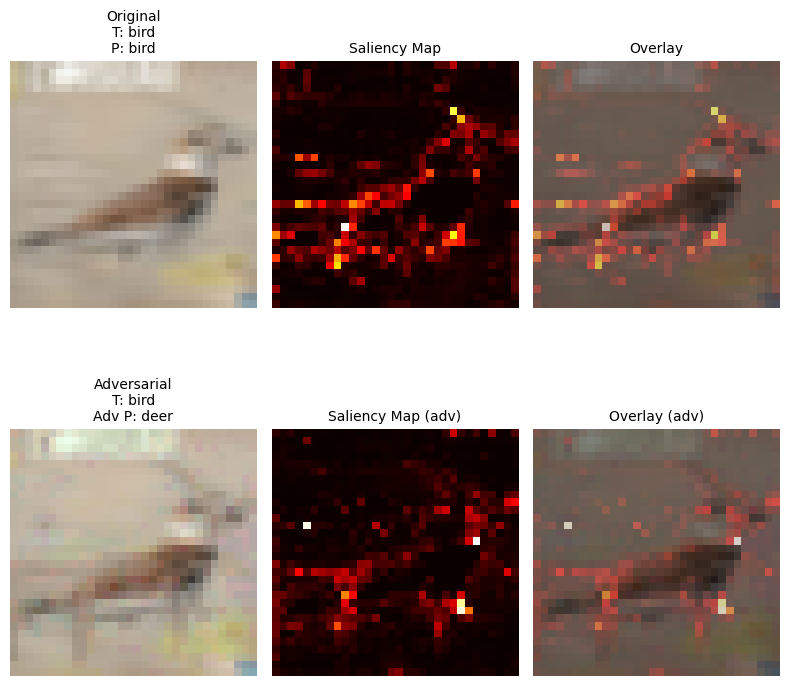

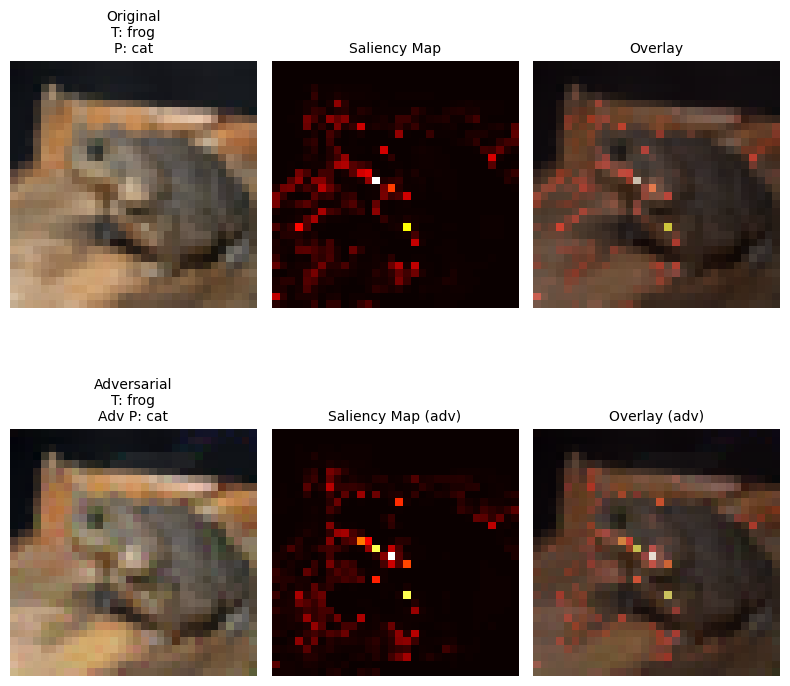

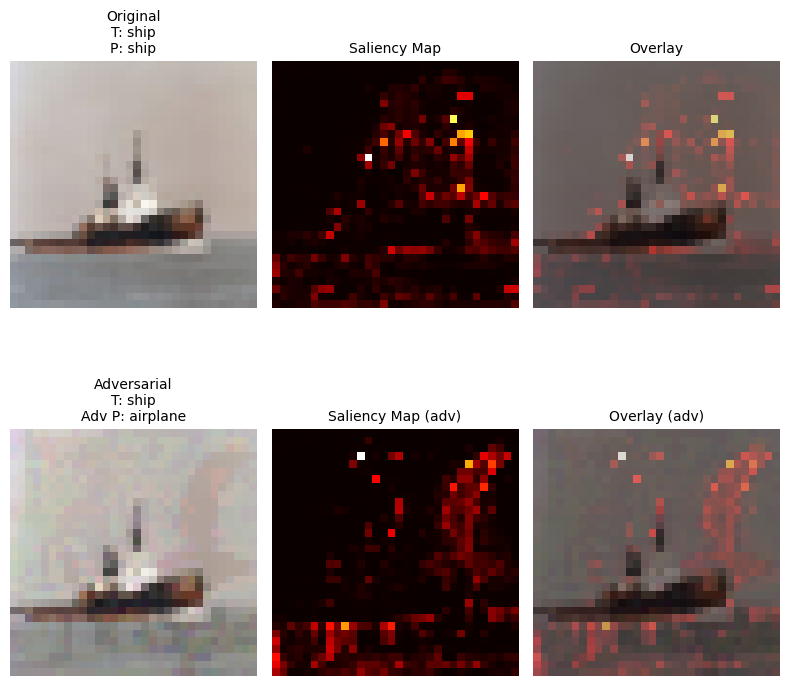

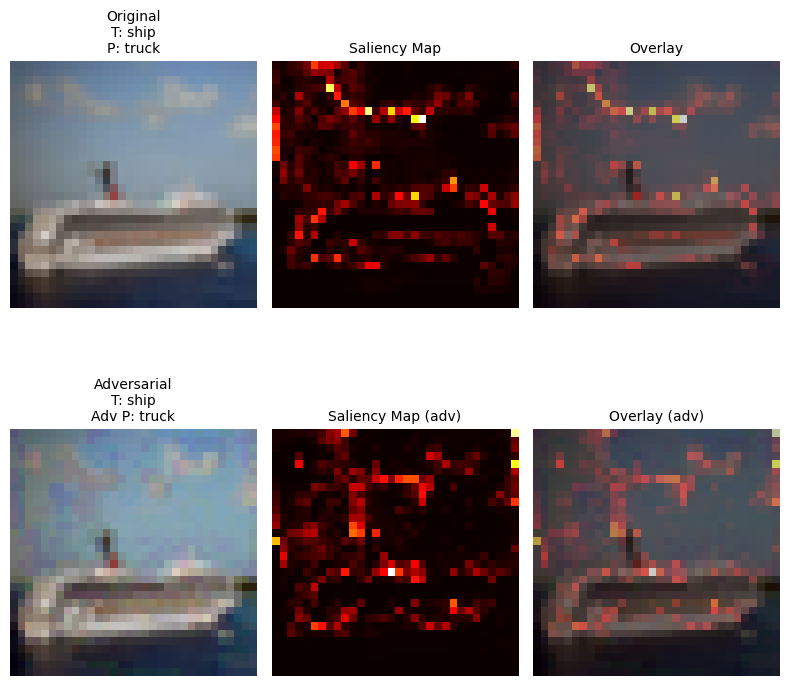

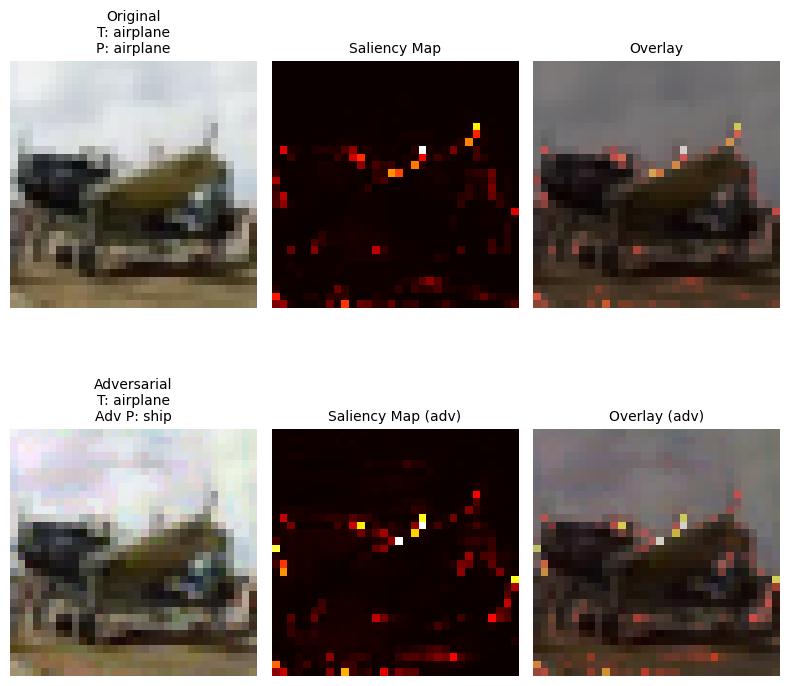

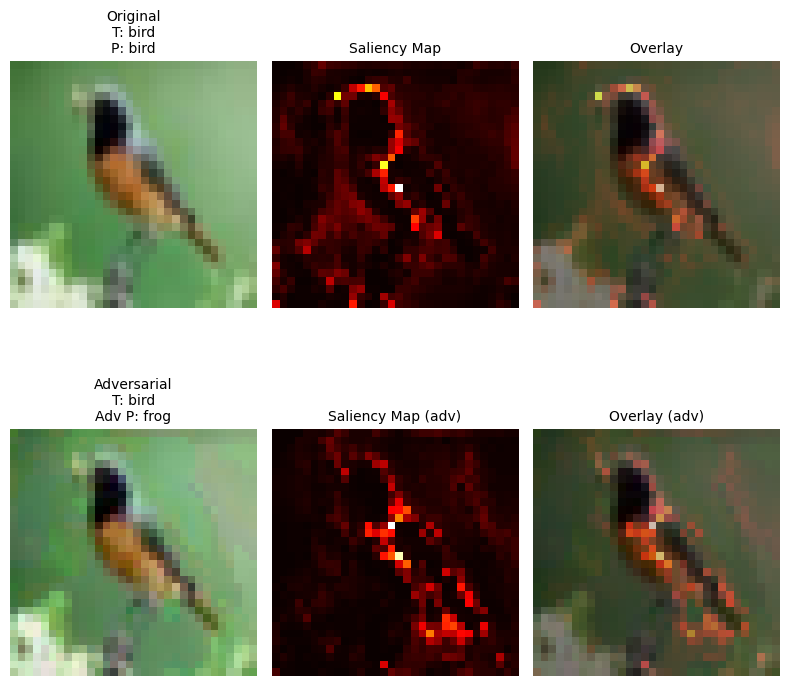

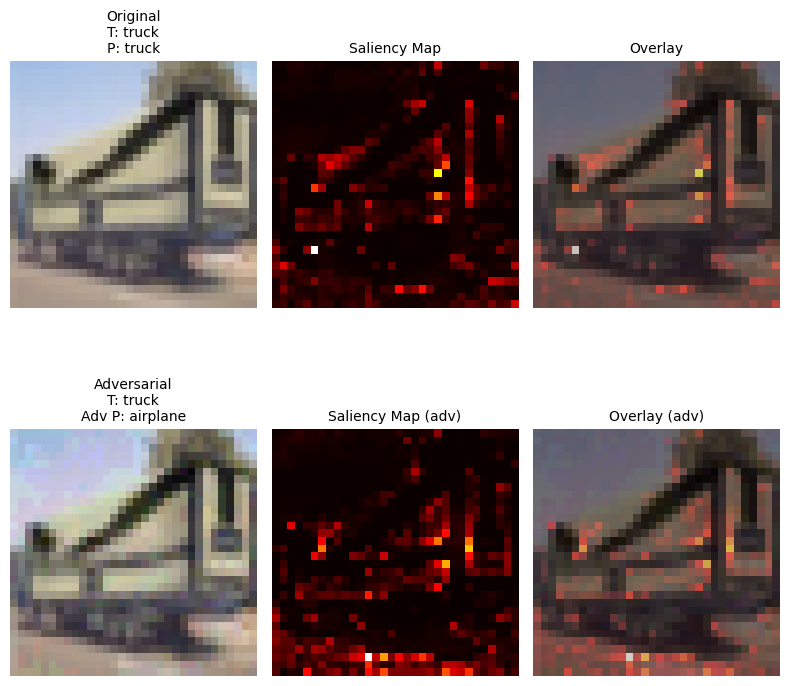

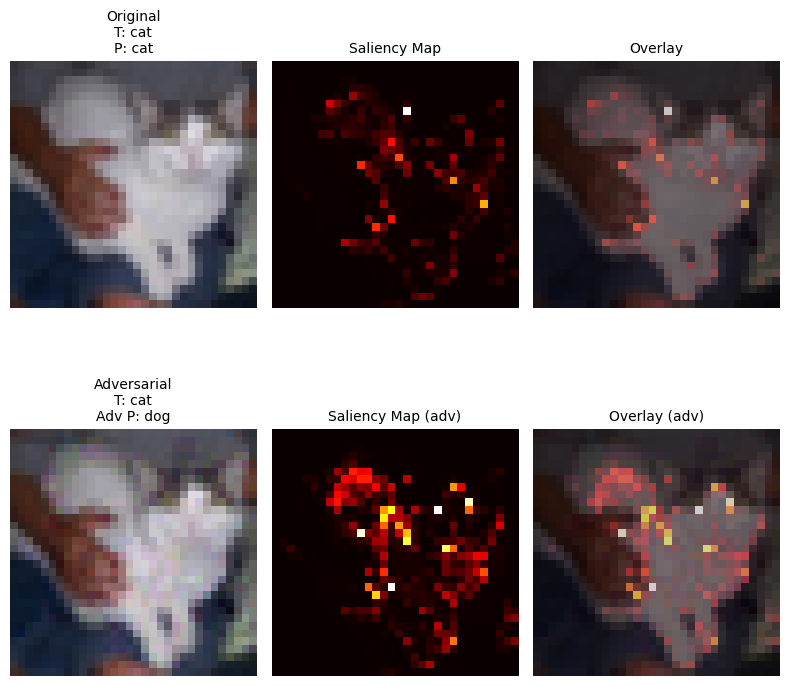

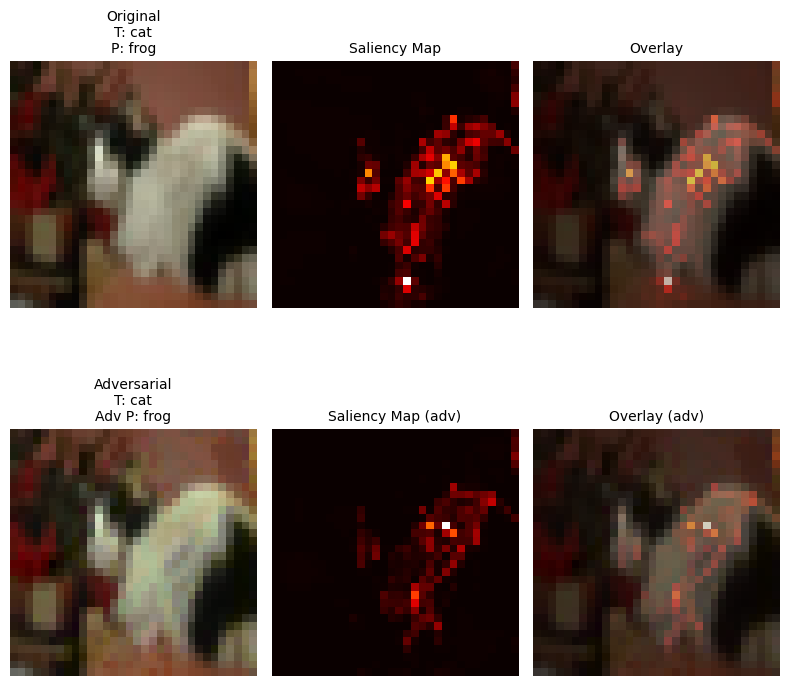

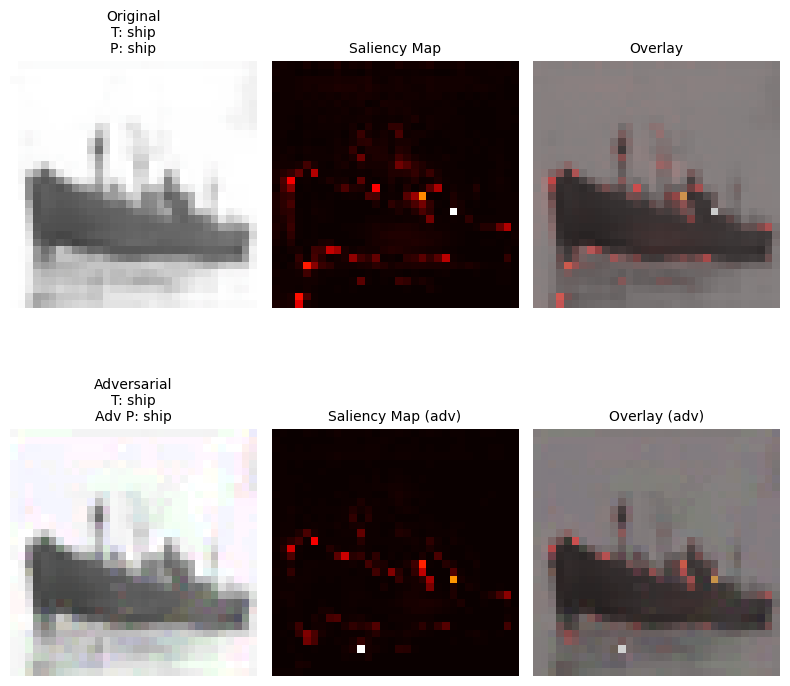

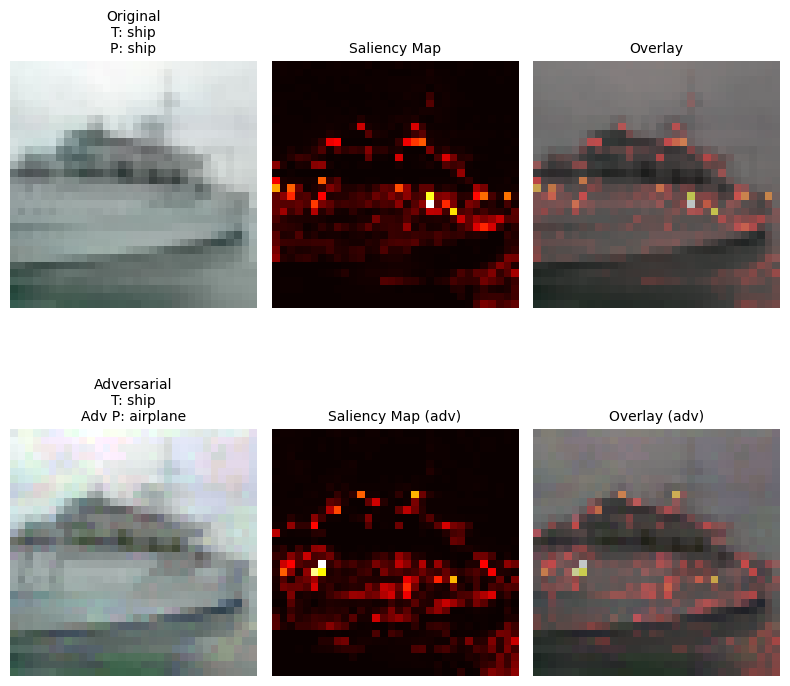

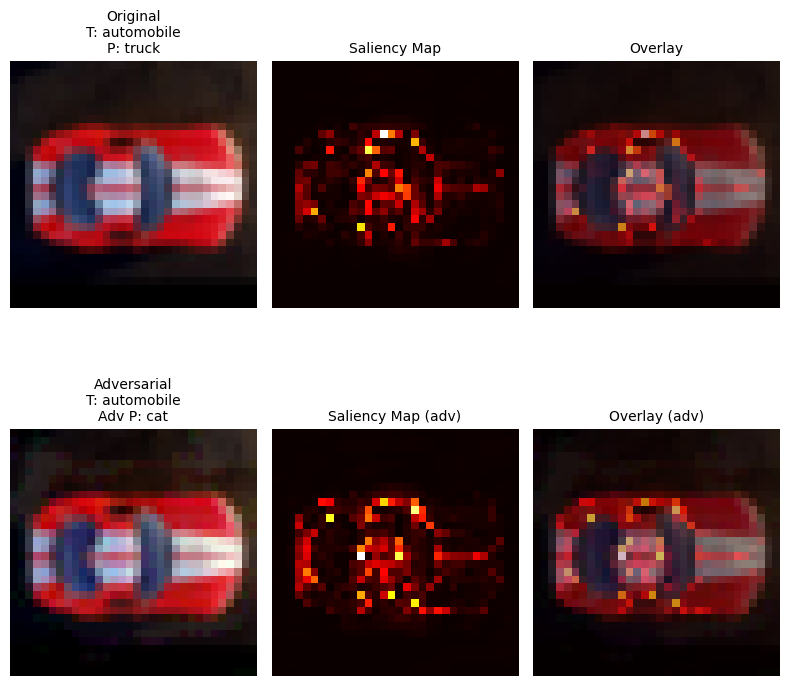

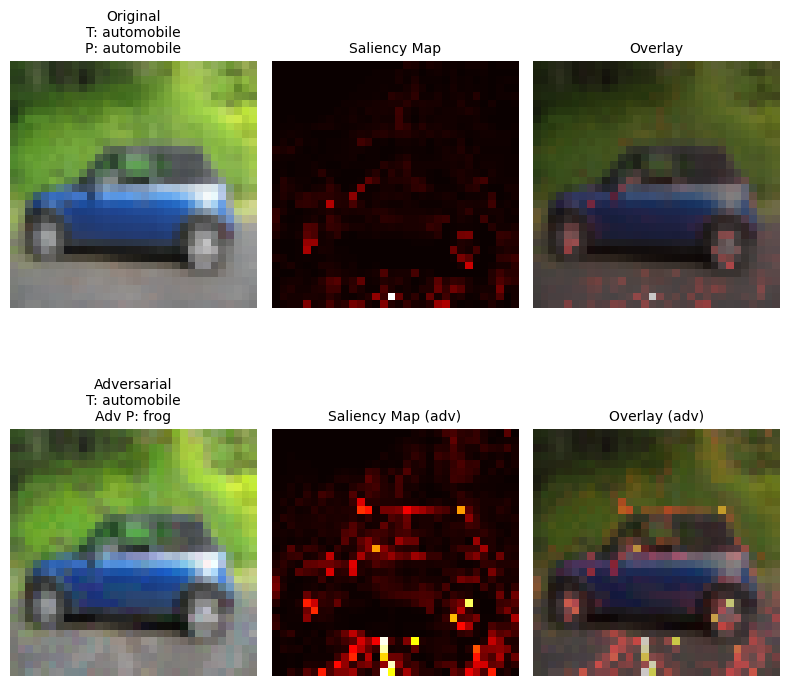

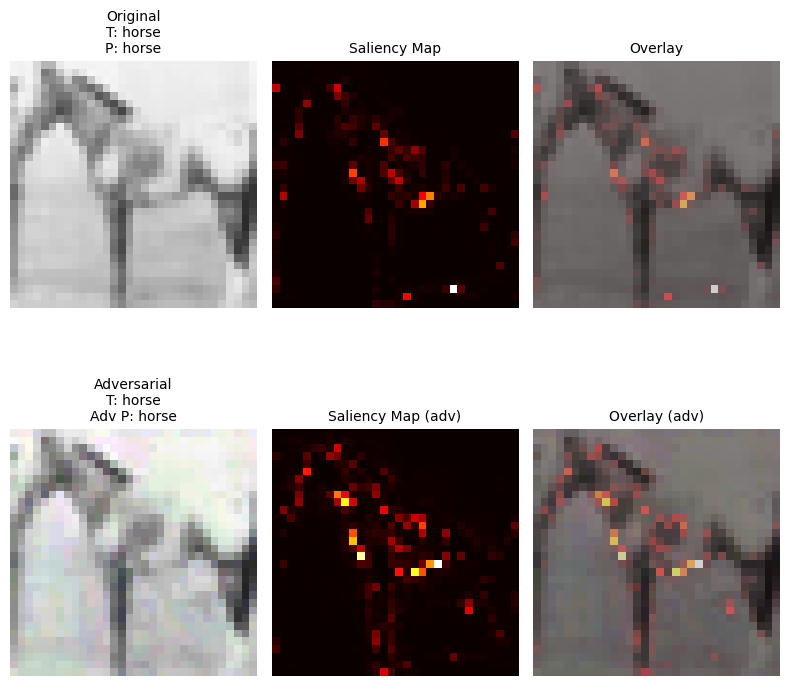

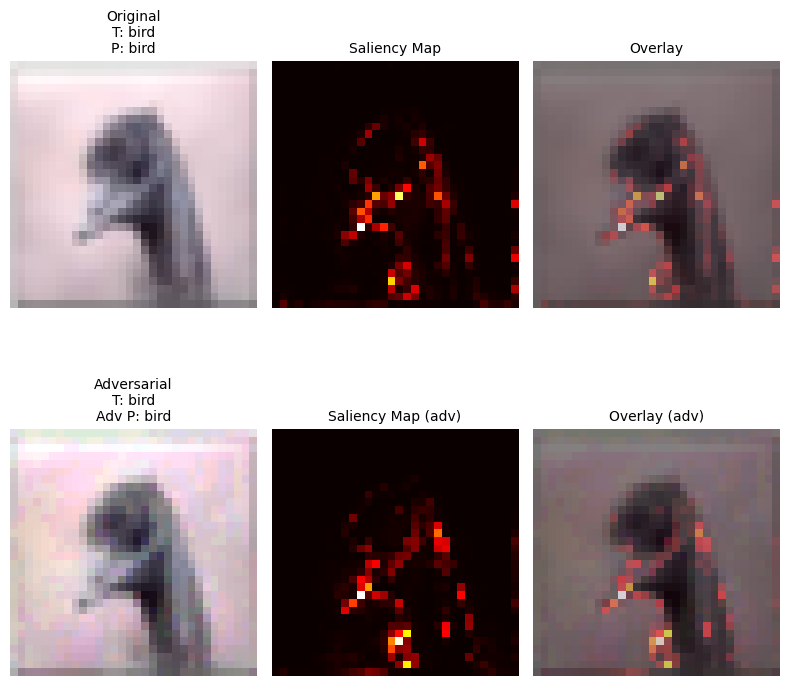

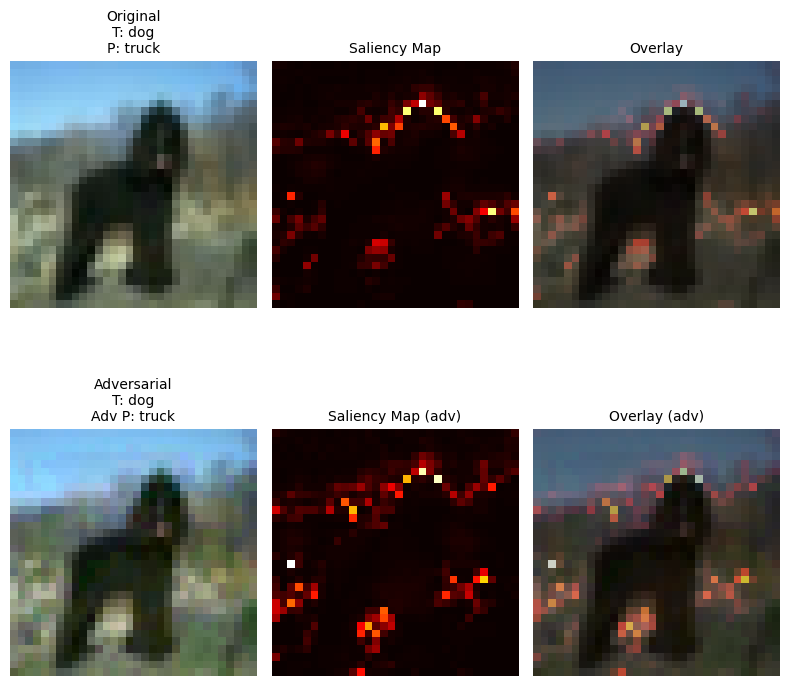

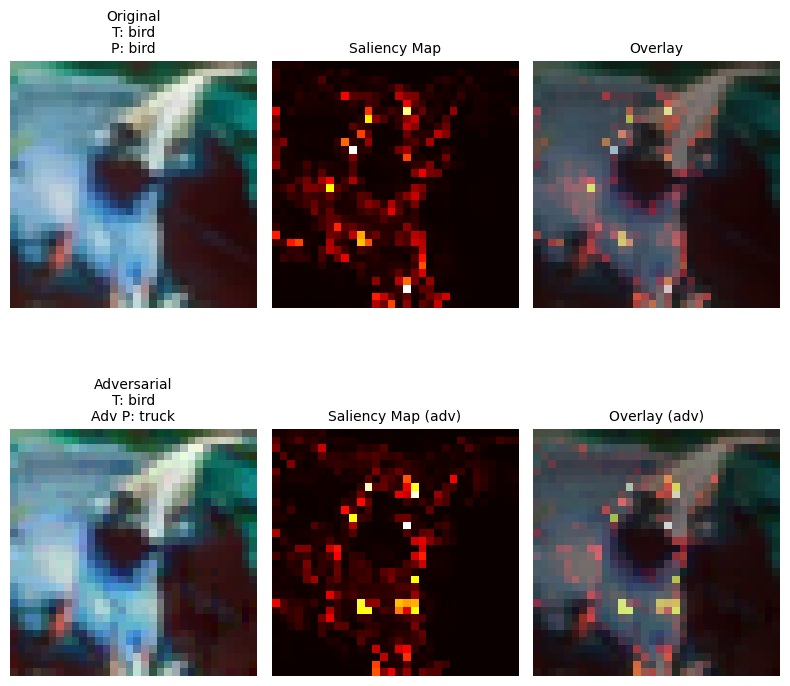

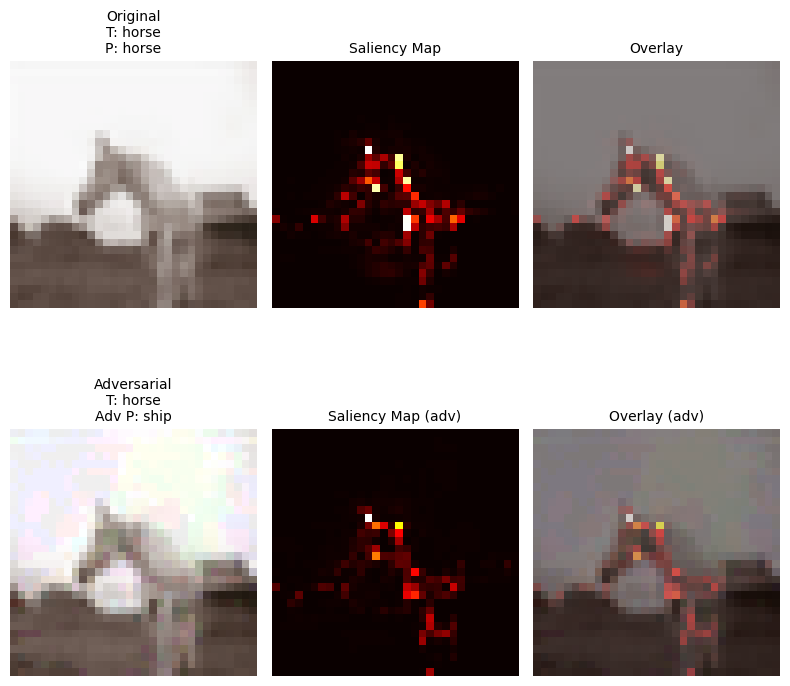

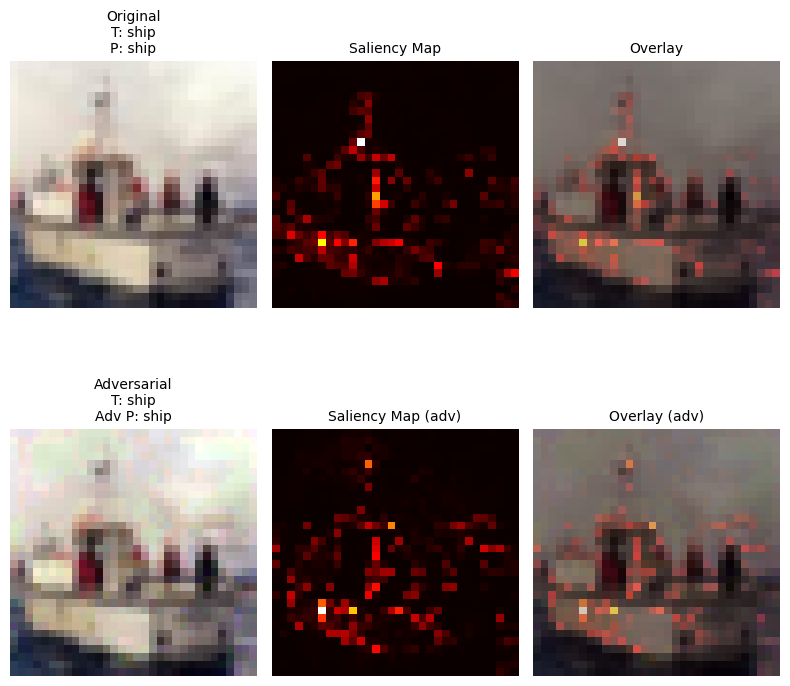

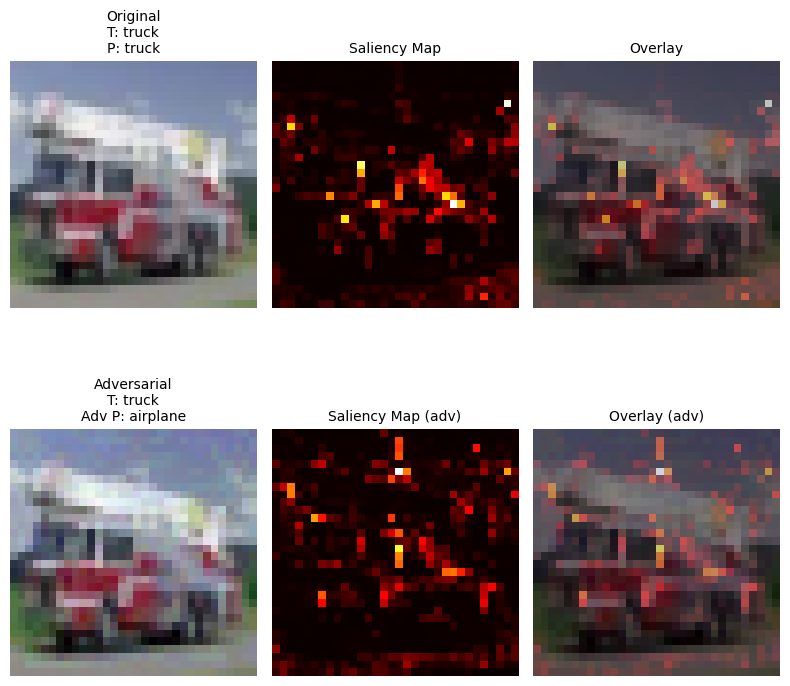

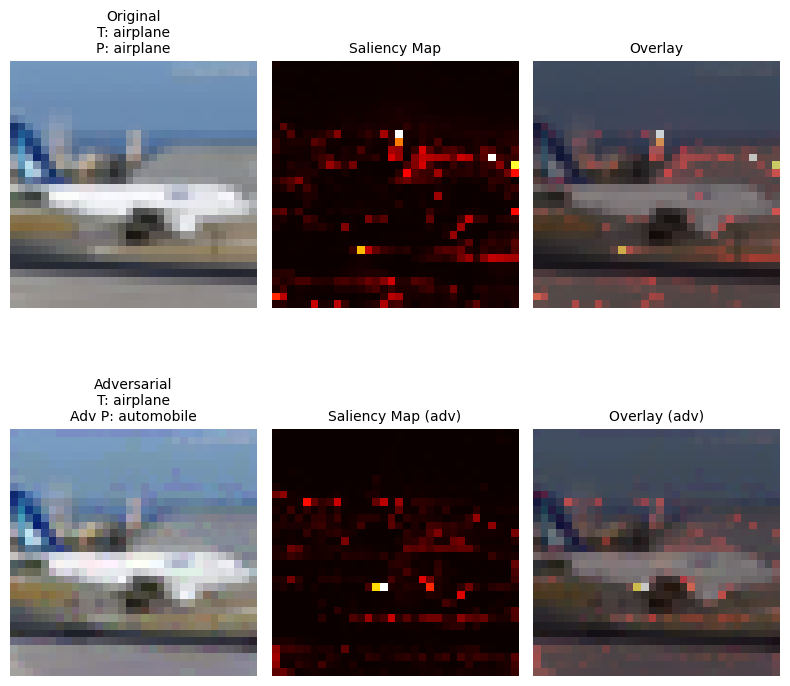

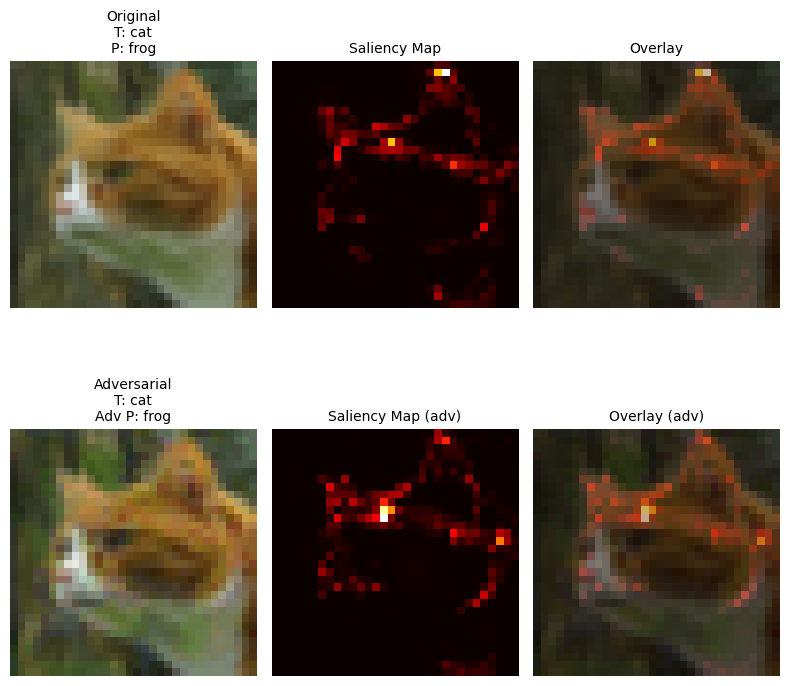

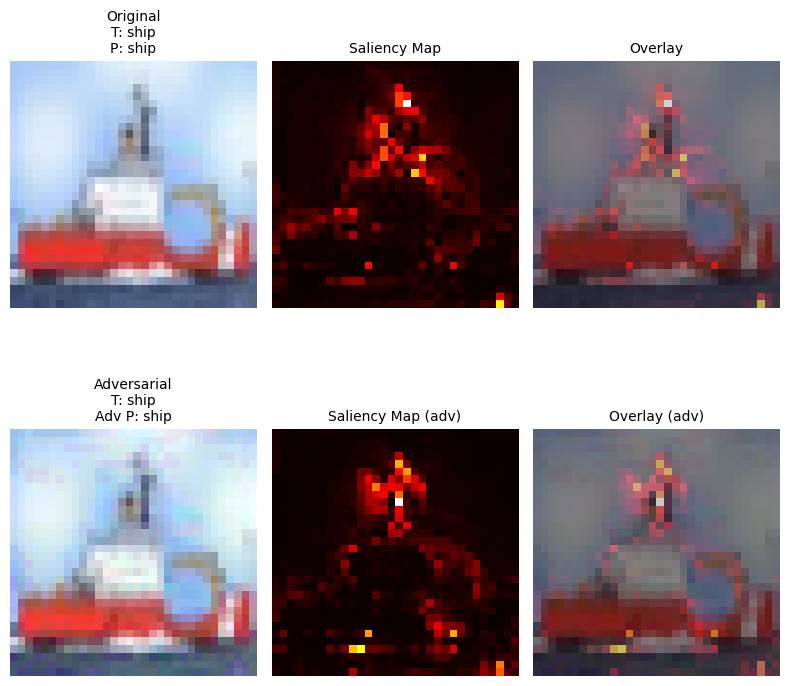

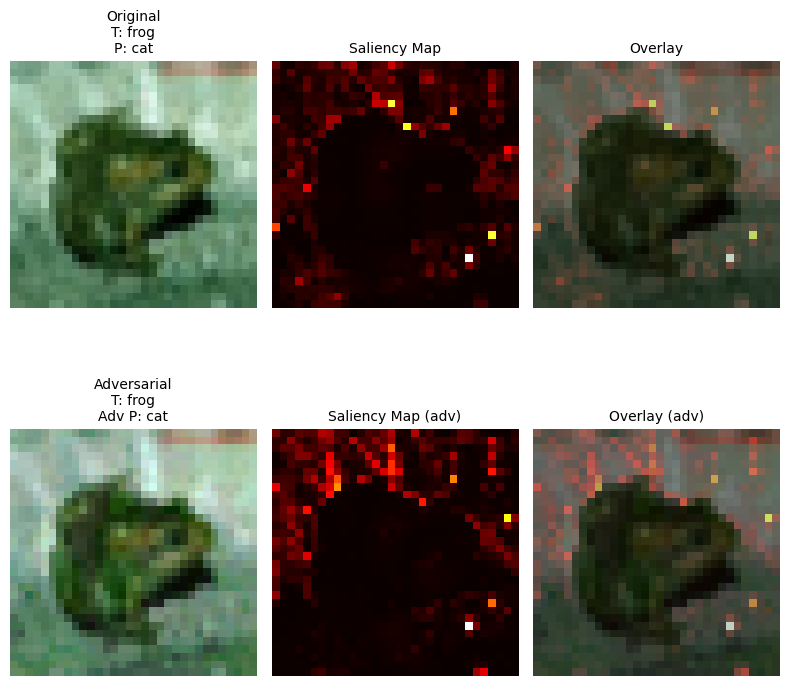

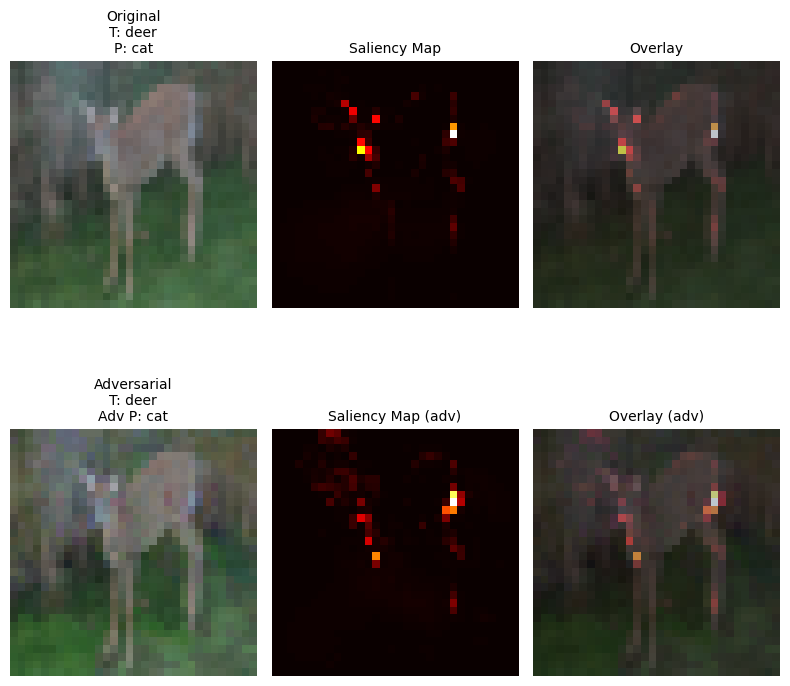

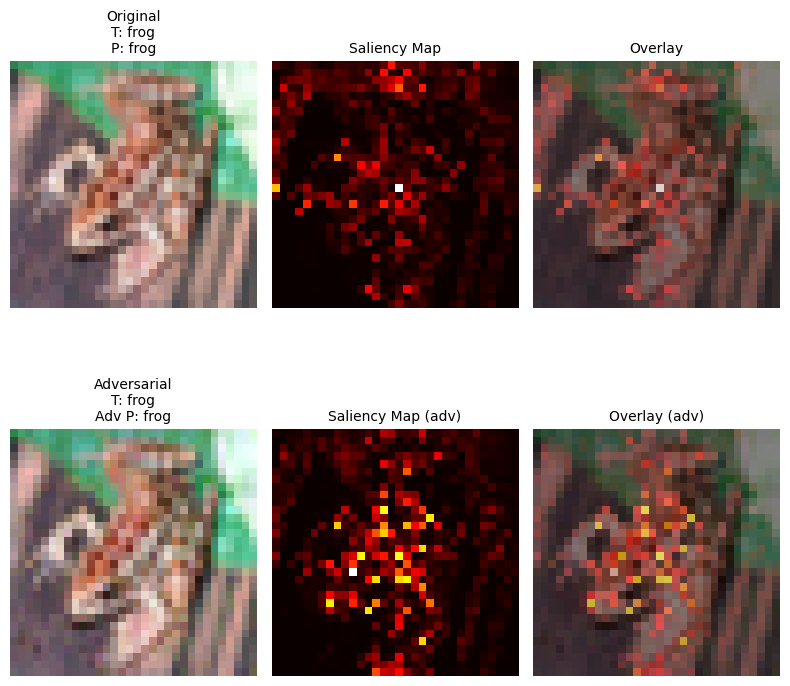

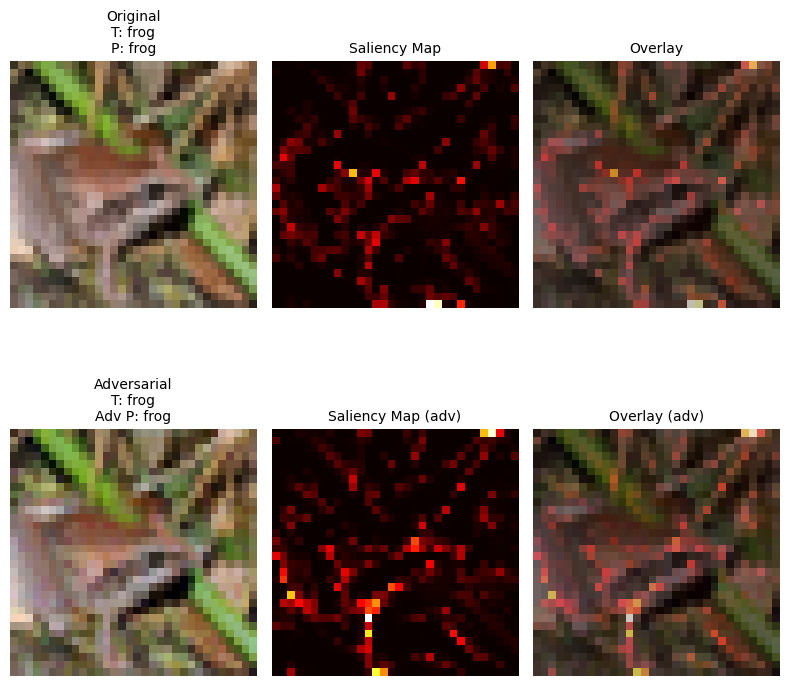

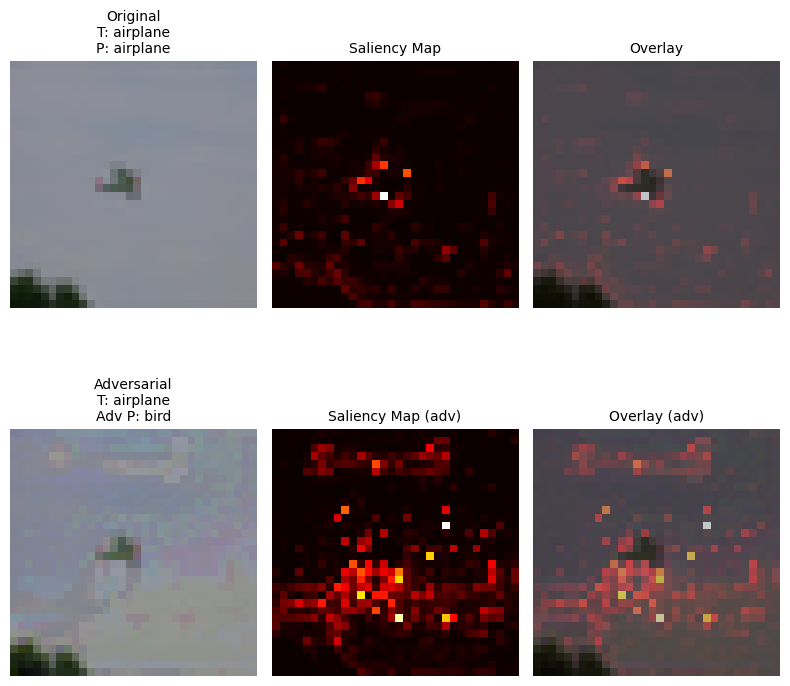

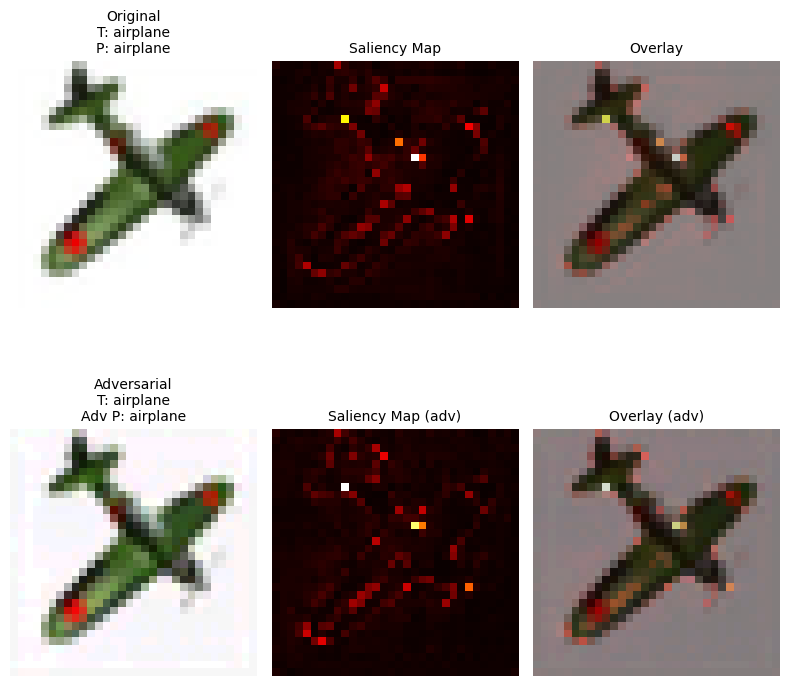

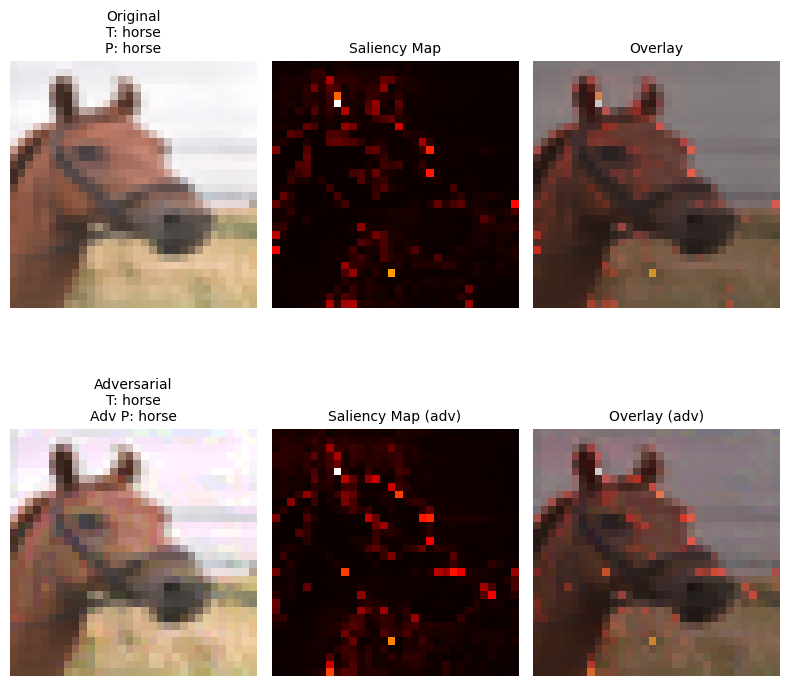

In [26]:
saliency_maps(model_robust, sg_pgd, n_images=100) 
# PS : sg_pgd will only work with robust, not original, unless you change the saliency function to use the original model.